In [2]:
import sources
import matplotlib.pyplot as plt
from ugradio import timing, coord, nch
import numpy as np
import glob
%matplotlib notebook

In [15]:
.0039194*3600

14.10984

In [8]:
.873199*60

52.39194

In [19]:
.00423779999999999*3600

15.256079999999965

In [18]:
.257063*60

15.423779999999999

In [17]:
37+52/60+14.109/3600

37.87058583333334

In [20]:
-122 -15/60-15.256079999999965/3600

-122.2542378

In [5]:
nch.lat, nch.lon, nch.alt

(37.873199, -122.257063, 120.0)

# Functions

In [21]:
def plot_raw(v_tot, lsts):
    plt.figure(figsize=(9,6))
    mean=np.mean(v_tot)
    median=np.median(v_tot)


    # plt.scatter(lsts*12/np.pi, v_tot, s=.1)
    plt.plot(lsts*12/np.pi, v_tot, 'k',lw=.6)
    plt.xlabel('LST [hrs]', fontsize='12')
    plt.ylabel('Visibility [Jy]', fontsize='12')
    # plt.axhline(mean, lw=2, label='mean:'+str(round(mean, 4))+'mV')
    plt.axhline(median, lw=2, c='r', ls='--', label='median:'+str(round(median, 4))+'Jy')

    plt.legend(fontsize='12')
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.tight_layout()

def plot_fft(v_tilde,fringe_freqs, semilog=False):
    plt.figure(figsize=(9,6))
    if semilog:
        plt.semilogy(np.fft.fftshift(fringe_freqs), np.fft.fftshift(v_tilde))
    else:
        plt.plot(np.fft.fftshift(fringe_freqs)*100, np.fft.fftshift(v_tilde))
    plt.xlabel('Fringe Freqs [mHz]', fontsize='12')
    plt.ylabel(r'$\widetilde{Voltage}$ [$mV^{-1}$]', fontsize='12')
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
#     plt.xlim(-6, 6)
#     plt.ylim(-1, 1)
    plt.tight_layout()

def get_data(jd, mult=1):
    files = sorted(glob.glob('data/interf_data/'+str(jd)+'/capture' +'*.npz'))
    voltage_data  = [np.load(file, allow_pickle=True) for file in files]
    meta_files = sorted(glob.glob('data/tracking/'+str(jd)+'/*.npz'))
    meta_data = np.load(meta_files[0], allow_pickle=True)

    times = meta_data['lsts']
    alts = meta_data['alts']
    azs  = meta_data['azs']

    v_tot = voltage_data[-1]['voltage_data']
    times_tot = voltage_data[-1]['times']

    lsts = times[0]+np.linspace(0, len(times_tot)*mult*np.pi/12/3600, len(times_tot))
    return v_tot, lsts
def get_data_basil():
    files = sorted(glob.glob('data/interf_data/basil_data/capture' +'*.npz'))
    voltage_data  = [np.load(file, allow_pickle=True) for file in files]
    
    v_tot = voltage_data[-1]['voltage_data']
    times_tot = voltage_data[-1]['timestamps']

    return v_tot, times_tot
def get_data_new(jd, mult=1):
    files = sorted(glob.glob('data/interf_data/'+jd+'/capture' +'*.npz'))
    voltage_data  = [np.load(file, allow_pickle=True) for file in files]
    v_tot = voltage_data[-1]['voltage_data']
    times_tot = voltage_data[-1]['times']
    t0 = voltage_data[-1]['t0']

    lsts = t0[0]+np.linspace(0, len(times_tot)*mult*np.pi/12/3600, len(times_tot))
    return v_tot, lsts, times_tot, t0, voltage_data, files
def get_fft(v_tot, lsts):
    fringe_freqs = np.fft.fftfreq(len(lsts), np.median(np.diff(lsts*12/np.pi*3600)))
    v_tilde = np.fft.fft(v_tot)
    return v_tilde, fringe_freqs

In [22]:
def tau_tot(HA, tau_c):
    return tau_g(HA) + tau_c
def tau_gEW(B_ew, HA, dec, lamb):
    """
    Geometric delay in the east west direction
    """
    return B_ew/lamb*np.cos(dec)*np.sin(HA)
def tau_gNS(B_ns, HA, dec, lat, lamb):
    """
    Geometric Delay in the north south directions, ONLY including HA
    dependant components
    """
    factor = B_ns/lamb
    delay_perp = factor*np.sin(lat)*np.cos(dec)*np.cos(HA) #Changes as cos(h)
    return delay_perp
def tau_g(B_ew, B_ns, dec, HA, lat, lamb):
    """
    Total geometric delay
    """
    EW = tau_gEW(B_ew, HA, dec, lamb)
    NS = tau_gNS(B_ns, HA, dec, lat, lamb)
    return EW+NS
def tc_prime(tc, B_ns, dec, lat):
    """
    B_ns modified cable delay
    
    """
    factor = B_ns/c.to_value()
    delay_para = factor*np.cos(lat)*np.sin(dec) #Lump in with cable delay
    return tc - delay_para
def lst_HA(lst, RA):
    return lst - RA
def eq_12(A, B, nu_taug):
    return A*np.sin(2*np.pi*nu_taug) + B*np.cos(2*np.pi*nu_taug)
    

############LEAST SQUARES?#######################
def fx(Q_EW, Q_NS, HA):
    return np.cos(2*np.pi*(Q_EW+Q_NS)*np.sin(HA))

def gx(Q_EW, Q_NS, HA):
    return np.sin(2*np.pi*(Q_EW+Q_NS)*np.sin(HA))

def get_M(Q_EW, Q_NS, HA):
    M = np.array([
        [np.sum(fx(Q_EW, Q_NS, HA)),           np.sum(fx(Q_EW, Q_NS, HA)*gx(Q_EW, Q_NS, HA))], 
        [np.sum(fx(Q_EW, Q_NS, HA)*gx(Q_EW, Q_NS, HA)),           np.sum(fx(Q_EW, Q_NS, HA))]
    ])
    return M

def get_b(d, Q_EW, Q_NS, HA):
    return np.array([np.sum(fx(Q_EW, Q_NS, HA)*d), np.sum(gx(Q_EW, Q_NS, HA)*d)])

def get_AB(M, b):
    return np.matmul(np.linalg.inv(M), b)

def get_residuals(d, Q_EW, Q_NS, HA, A, B):
    # sum((y-(Af(x)+Bf(x)))^2)
    f_x  = A*fx(Q_EW, Q_NS, HA)+B*gx(Q_EW, Q_NS, HA)
    res = np.sum(np.abs(d-f_x)**2)
    return res

def f_f(B_ew, B_ns, dec, HA, lat, lamb):
    perp = B_ew/lamb*np.cos(dec)*np.cos(HA)
    para = B_ns/lamb*np.cos(dec)*np.sin(lat)*np.sin(HA)
    return perp-para
def get_u(B_ew, B_ns, dec, HA, lat, lamb):
    perp = B_ew/lamb*np.cos(dec)*np.sin(HA)
    para = -B_ns/lamb*np.cos(dec)*np.sin(lat)*np.cos(HA)
    return perp-para

linsolve *aaron parsons

# Point Sources

In [23]:
s= {source.name:source for source in sources.sources}

In [24]:
jd = timing.julian_date()
times = np.linspace(round(jd), round(jd)+1, 100)

In [25]:
lsts = ((times -int(timing.julian_date()))-1)*2*np.pi

<IPython.core.display.Javascript object>


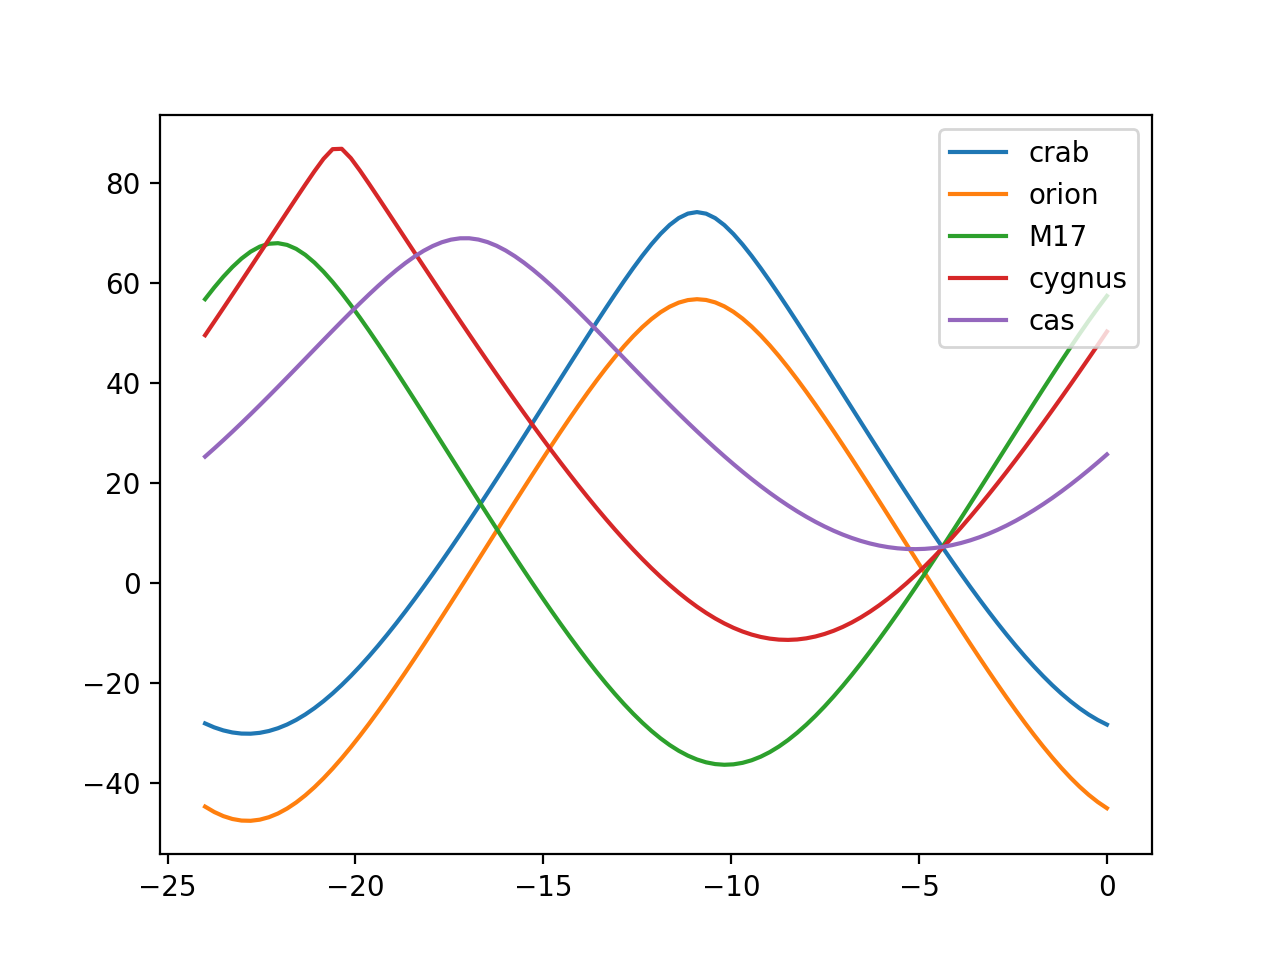

In [7]:
plt.figure()
for source, info in s.items():
    alts = [info.get_alt(time) for time in times]
    plt.plot(lsts*12/np.pi, alts, label=source)
plt.legend()

# 1Hr Sun

<IPython.core.display.Javascript object>


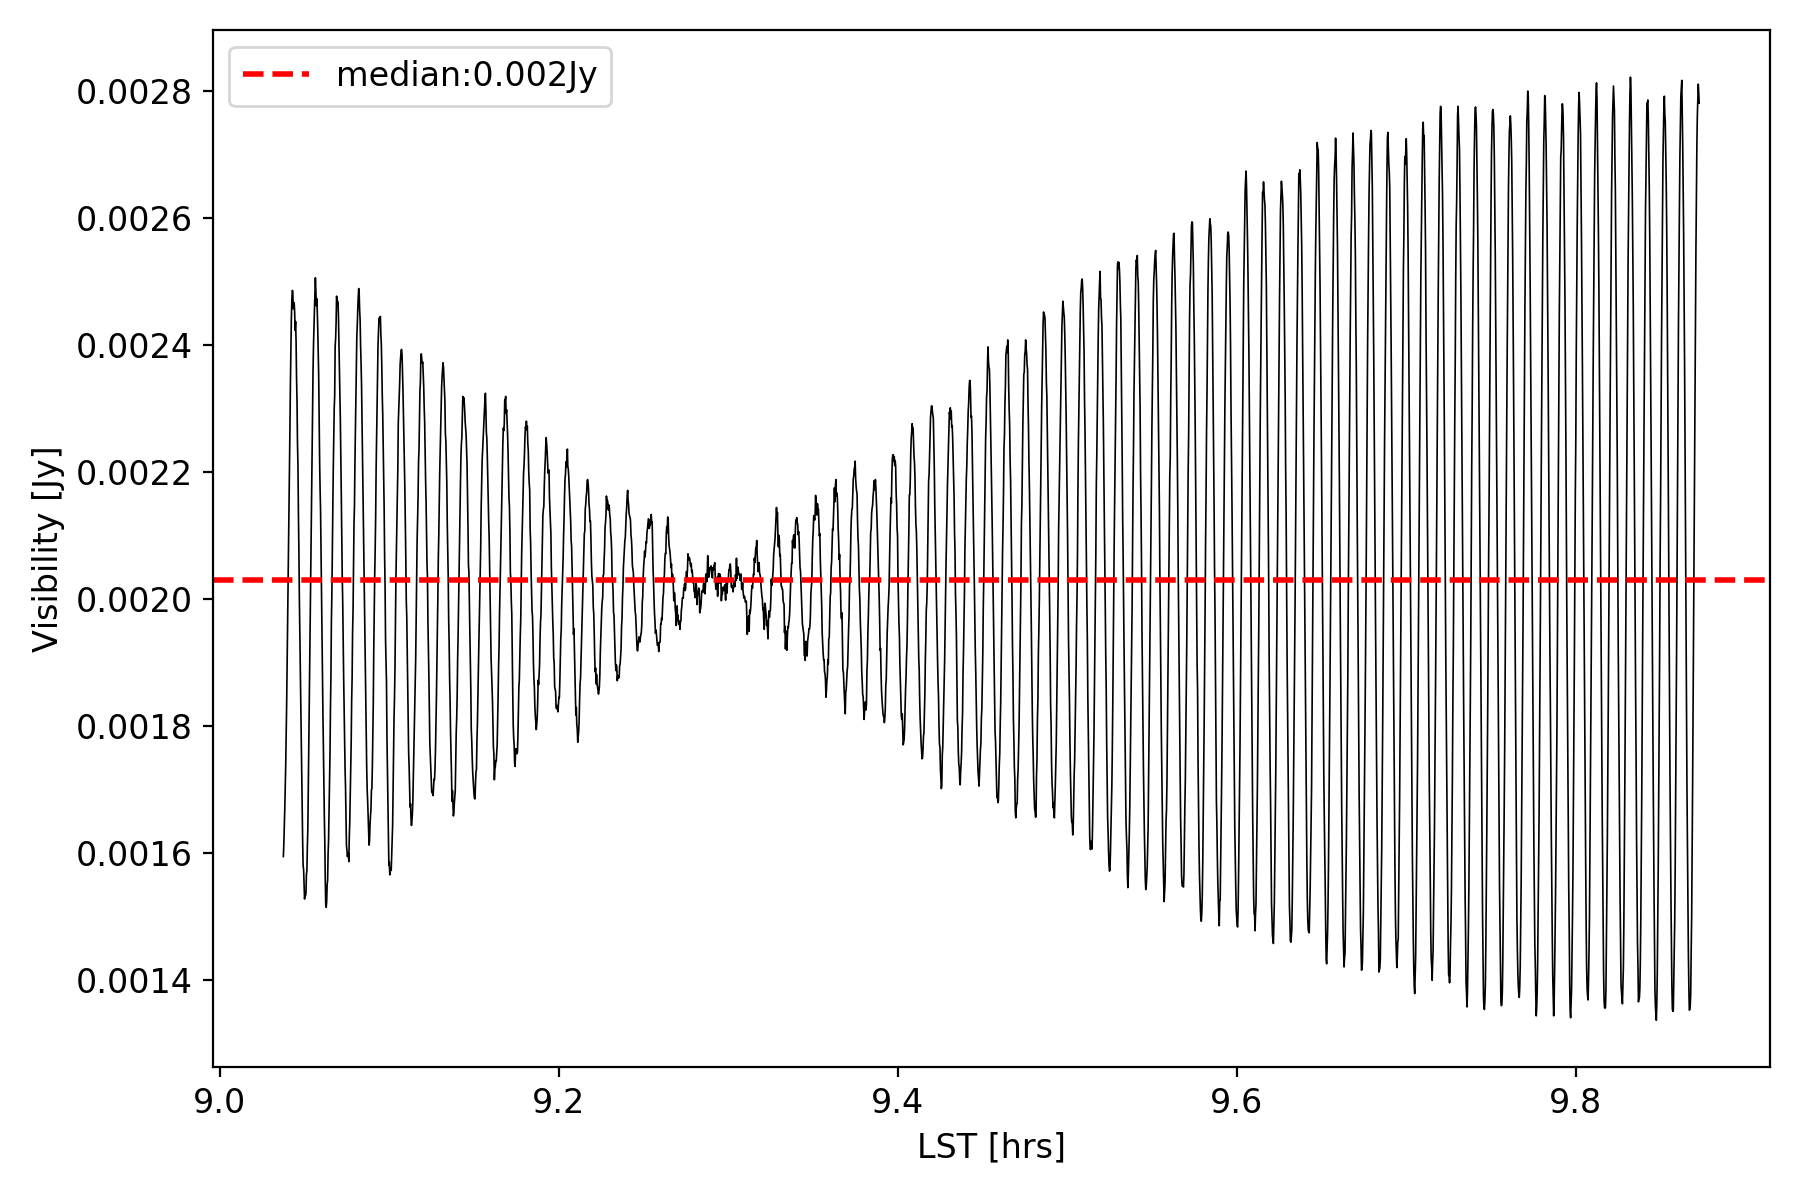

In [26]:
v_tot, lsts = get_data(2458920)
plot_raw(v_tot, lsts)

# Crab

In [27]:
v_tot_crab, lsts_crab, times_crab, t0_crab, vd_crab, files_crab = get_data_new(str(2458938), mult=.5)

In [28]:
v_tot = np.load(files_crab[6])['voltage_data']
times_tot = np.load(files_crab[6])['times']
t0 = np.load(files_crab[6])['t0']

lsts = t0[0]+np.linspace(0, len(times_tot)*.5*np.pi/12/3600, len(times_tot))

median = np.median(v_tot_crab)
v_tot_crab=v_tot_crab[:52300]
lsts_crab=lsts[:52300]
# v_tot_crab[52300:60695] = 0
# v_tot_crab[65240:75893] = 0
# v_tot_crab[65240:75893] = 0
v_tot_crab=v_tot[41927:47470]
lsts_crab=lsts[41927:47470]
v_sky = v_tot[-1000:]
l_sky = lsts[-1000:]

In [29]:
v_s = np.fft.fft(v_sky)
v_s[0] = 0
v_sky =np.fft.ifft(v_s)

In [30]:
np.mean(np.mean(np.abs(v_tot_crab-fit)**2))

NameError: name 'fit' is not defined

In [31]:
np.mean(np.abs(v_sky)**2)

4.6105504000000005e-11

<IPython.core.display.Javascript object>


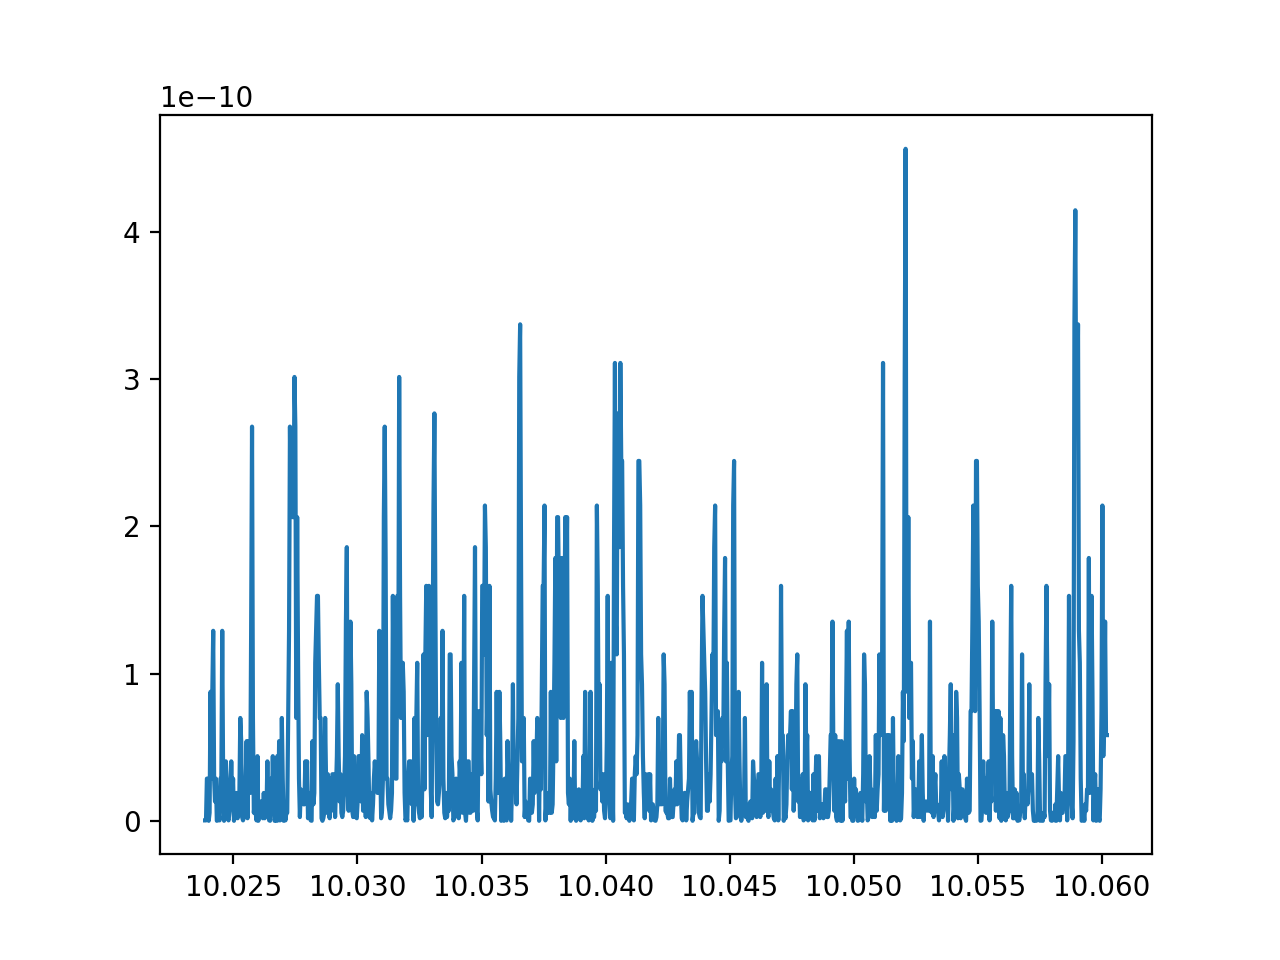

In [32]:
plt.figure()
plt.plot(l_sky, np.abs(v_sky)**2)

In [2044]:
fit_x = lsts_crab#np.concatenate((lsts_crab[:52300], lsts_crab[60695:65240], lsts_crab[75893:]))
fit_y = v_tot_crab#np.concatenate((v_tot_crab[:52300], v_tot_crab[60695:65240], v_tot_crab[75893:]))

a,b,c,d = np.polyfit(fit_x, fit_y, deg=3)
fit = a*lsts_crab**3+b*lsts_crab**2+c*lsts_crab+d
# v_tot_crab = v_tot_crab
# v_tot_crab[52300:60695] = 0
# v_tot_crab[65240:75893] = 0

In [35]:
print('{:e}'.format(np.sqrt(496)*np.sqrt(2)/np.mean(np.abs(v_tot_crab)**2)))

2.925031e+11


In [33]:
v_t = np.fft.fft(v_tot_crab)
v_t[0] = 0
v_tot_crab = np.fft.ifft(v_t)

In [34]:
print('{:e}'.format(np.sqrt(2)*(496-np.sqrt(np.mean(np.abs(v_tot_crab)**2)-np.mean(np.abs(v_sky)**2)))/np.mean(np.abs(v_tot_crab)**2)))

6.514353e+12


In [36]:
np.mean(np.abs(v_sky)**2)/1e9

4.610550400000001e-20

In [37]:
np.mean(np.abs(v_tot_crab)**2)/1e9

1.076776040787055e-19

In [38]:
ls = [str(round((float(label.get_text())*12/np.pi%24), 2)) for label in labels]


NameError: name 'labels' is not defined

<IPython.core.display.Javascript object>


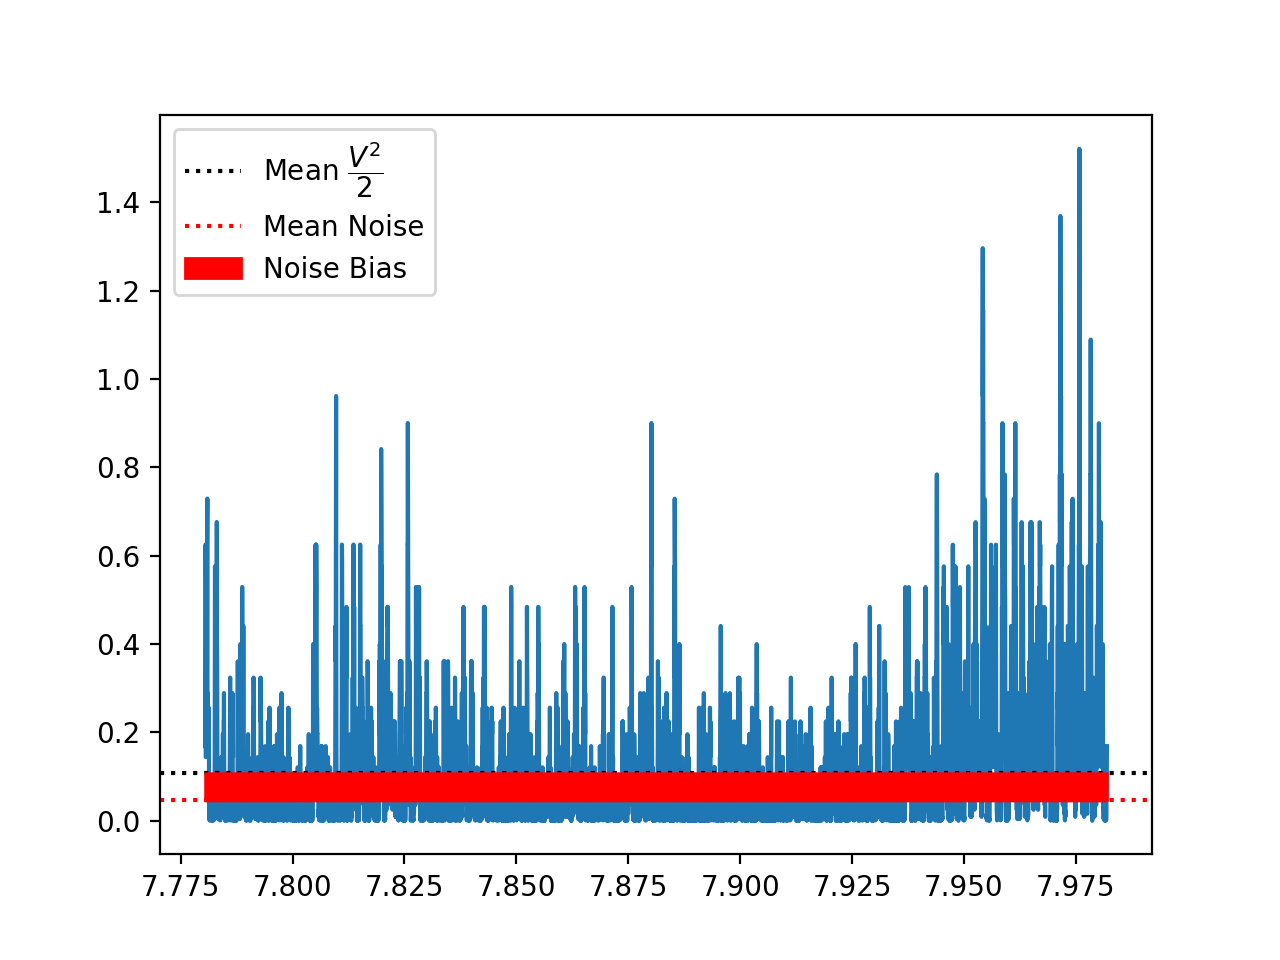

NameError: name 'ls' is not defined

In [39]:
plt.figure()
plt.plot(lsts_crab, np.abs(v_tot_crab)**2*1e9)
plt.axhline(np.mean(np.abs(v_tot_crab)**2)*1e9, ls=':', c='k', label='Mean $\dfrac{V^2}{2}$')
plt.axhline(np.mean(np.abs(v_sky)**2)*1e9, ls=':', c='r', label='Mean Noise')
plt.fill_between(lsts_crab, np.ones(len(lsts_crab))*np.mean(np.abs(v_sky)**2)*1e9, np.ones(len(lsts_crab))*np.mean(np.abs(v_tot_crab)**2)*1e9, 
                 label='Noise Bias', color='red', alpha=1, zorder=2.5)
plt.legend()
locs, labels = plt.xticks()  # Get the current locations and labels.

plt.xticks(locs, ls)
plt.xlabel('LST [hrs]')
plt.ylabel('Arbitrary Units')
plt.savefig('noise_cal.pdf')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


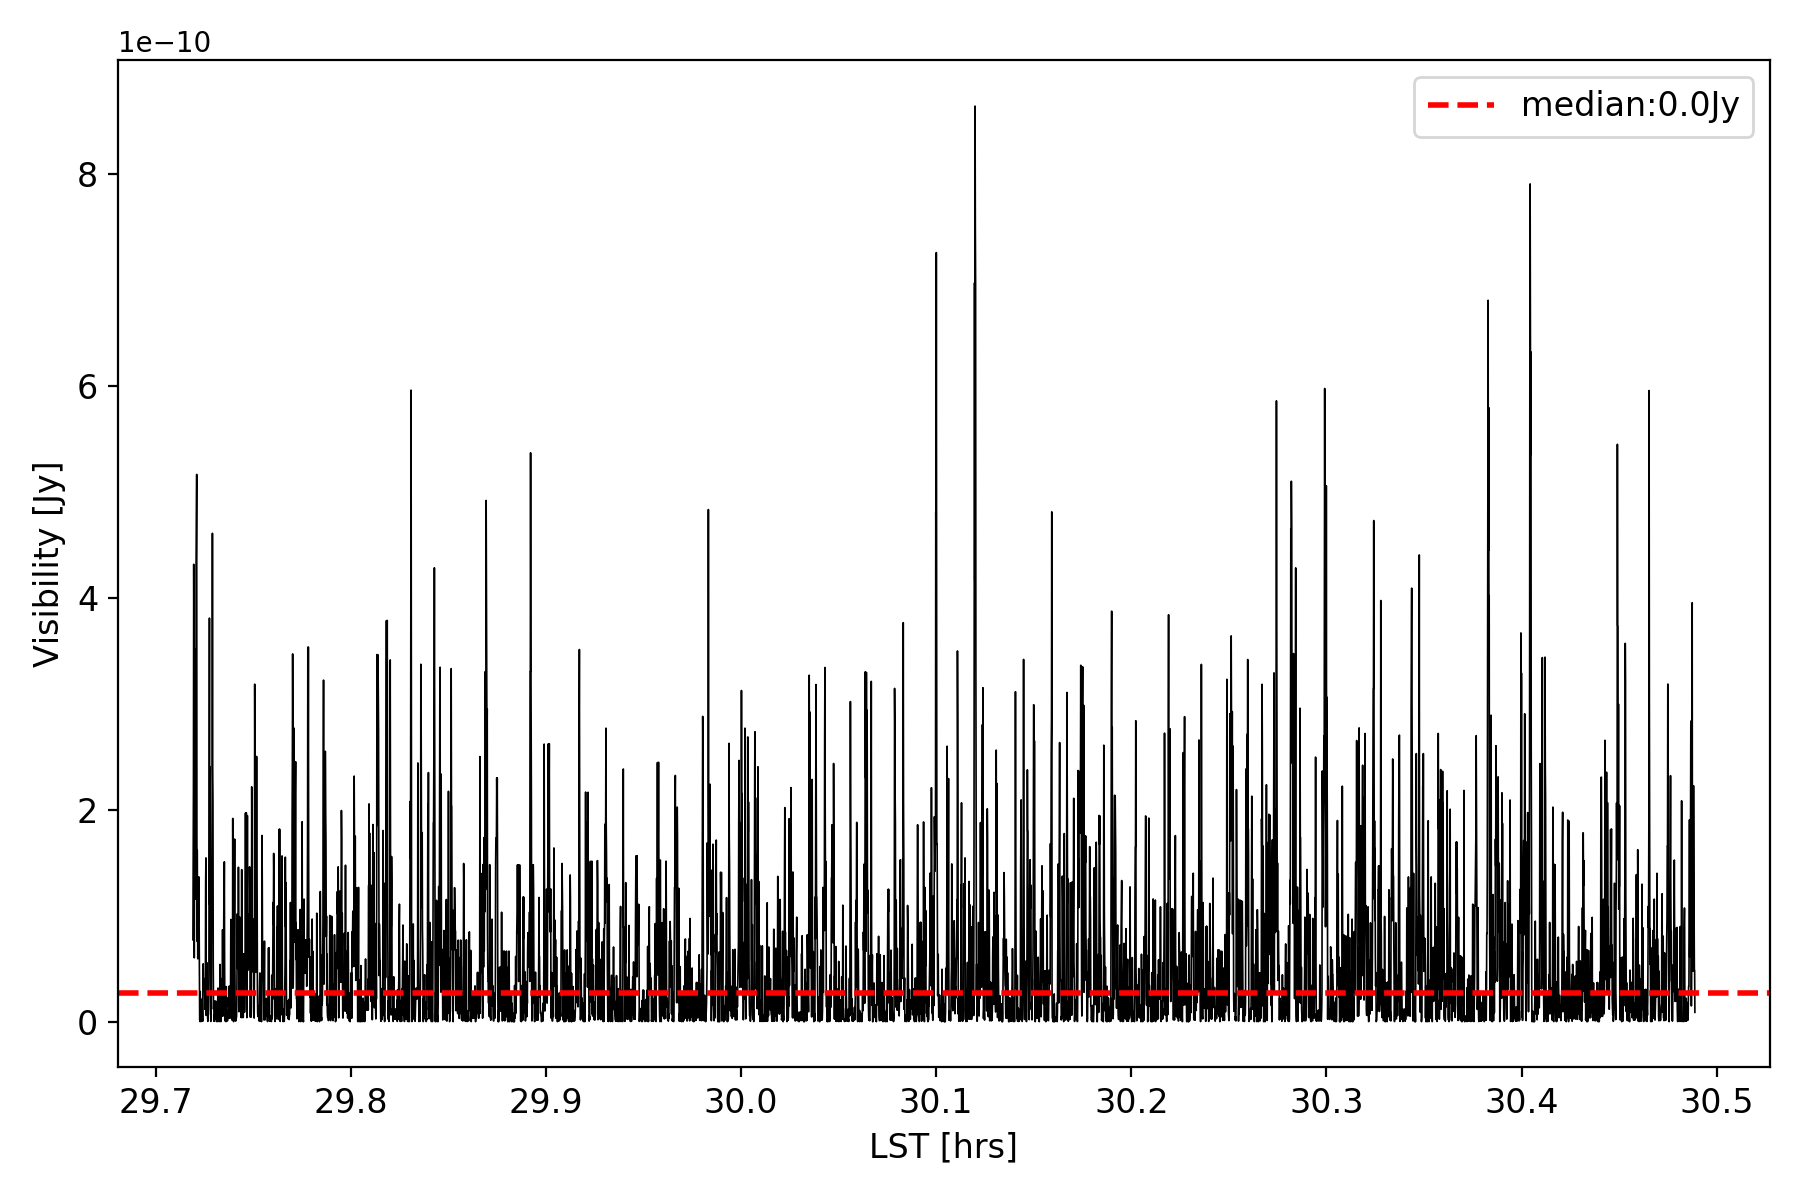

In [1913]:
plot_raw()

In [26]:
factor = 496/.0052e-3

In [14]:
(lsts_crab[-1]*12/np.pi)%(24)

6.488829920197698

In [15]:
v_tilde_crab, ff = get_fft(v_tot_crab, lsts_crab)

<IPython.core.display.Javascript object>


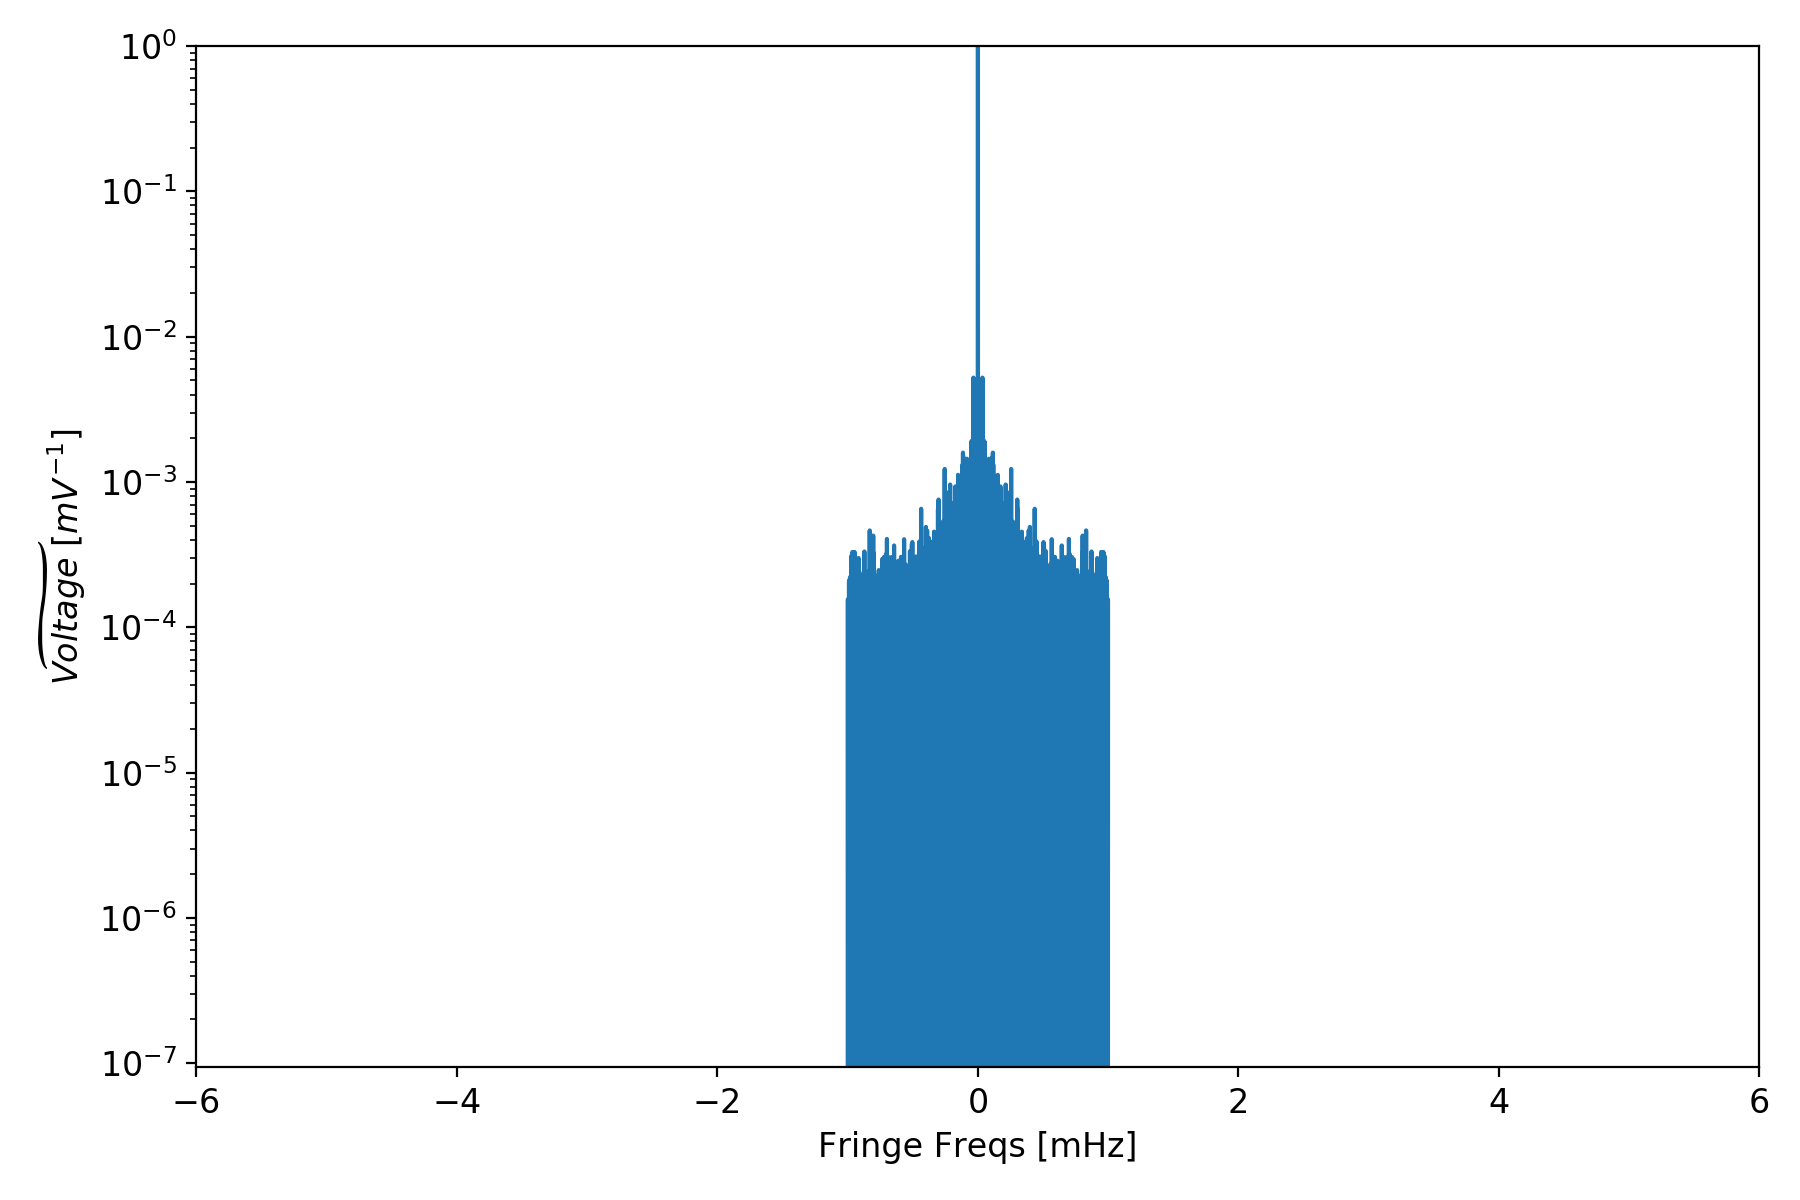

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


In [16]:
plot_fft(v_tilde_crab, ff, semilog=True)

In [17]:
v_tot_crab=v_tot_crab[41927:47470]
lsts_crab=lsts_crab[41927:47470]

In [18]:
np.where(lsts_crab*12/np.pi>29.719),np.where(lsts_crab*12/np.pi<30.489) 

((array([], dtype=int64),), (array([], dtype=int64),))

In [19]:
np.array([35.6348, 36.3127])%24

array([11.6348, 12.3127])

In [20]:
len(lsts_crab)

0

In [21]:
from matplotlib.colors import LogNorm

In [2051]:
# from sources import sources
# from ugradio import nch
# ss = {source.name: source for source in sources}
# crab = ss['crab']
# B_EW, B_NS = 13.6, 1.25576

# lamb=2.5e-2



# v_tilde_2d_crab = np.zeros(1125)
# plt.figure()
# for i in range(int(len(v_tot_crab)/1125)):
#     v_temp, fringe_temp = get_fft(v_tot_crab[i*1125:(i+1)*1125], lsts_crab[i*1125:(i+1)*1125])
#     plt.plot(np.fft.fftshift(fringe_temp), np.fft.fftshift(v_temp), label='bin:{}'.format(i))
#     v_tilde_2d_crab = np.vstack((v_tilde_2d_crab, v_temp))
# plt.xlim(-.05, .05)

# v_tilde_crab, fringe_freq_crab = get_fft(v_tot_crab, lsts_crab)
# plot_fft(v_tilde_crab, fringe_freq_crab, semilog=False)

# HA = lst_HA(lsts_crab, crab.ra*np.pi/280)%(2*np.pi)
# DEC = crab.dec*np.pi/180


# ff_crab = f_f(B_EW, B_NS, DEC, HA, nch.lat*np.pi/180, lamb)*np.pi/12/3600
# indices = []
# for i in range(len(fringe_freq_crab)):
#     if fringe_freq_crab[i] <ff_crab[-1] and fringe_freq_crab[i] >-ff_crab[-1]:
#         indices.append(i)
#     if fringe_freq_crab[i] > ff_crab[0] or fringe_freq_crab[i] <-ff_crab[0]:
#         indices.append(i)
# v_tilde_crab[indices] =0

# v_new_crab = np.fft.ifft(v_tilde_crab)

# v_tilde_2d_crab_filtered = np.zeros(1125)
# plt.figure()
# for i in range(int(len(v_tot_crab)/1125)):
#     v_temp, fringe_temp = get_fft(v_new_crab[i*1125:(i+1)*1125], lsts_crab[i*1125:(i+1)*1125])
#     plt.plot(np.fft.fftshift(fringe_temp), np.fft.fftshift(v_temp), label='bin:{}'.format(i))
#     v_tilde_2d_crab_filtered = np.vstack((v_tilde_2d_crab_filtered, v_temp))
# plt.xlim(-.05, .05)


# plt.figure(figsize=(10,6))
# plt.subplot(121)
# plt.title('Unfiltered')
# plt.imshow(np.fft.fftshift(np.abs(v_tilde_2d_crab)**2, axes=1), aspect='auto', norm=LogNorm(5e-8, 1e-2),
#           extent = [np.fft.fftshift(fringe_freq_crab)[-1]*1e3, np.fft.fftshift(fringe_freq_crab)[0]*1e3, 33, 0], cmap='bone')
# plt.colorbar()
# plt.xlim(-100, 100)
# plt.ylim(33,1 )
# plt.subplot(122)
# plt.title('Filtered')
# plt.imshow(np.fft.fftshift(np.abs(v_tilde_2d_crab_filtered)**2, axes=1), aspect='auto', norm=LogNorm(5e-8, 1e-2),
#           extent = [np.fft.fftshift(fringe_freq_crab)[-1]*1e3, np.fft.fftshift(fringe_freq_crab)[0]*1e3, 33, 0], cmap='bone')
# plt.colorbar()
# plt.xlim(-100, 100)
# plt.ylim(33,1 )
# plt.savefig('Eye_of_Sauron.pdf')

# plot_raw(v_new_crab, lsts_crab)

In [2052]:
# v_tot_crab, lsts_crab, times_crab, t0_crab, vd_crab, files_crab = get_data_new(str(2458931), mult=.5)

# from scipy.signal import savgol_filter

# # v_tot_crab = savgol_filter(v_tot_crab, 51, 3)
# fit_x = np.concatenate((lsts_crab[:27168], lsts_crab[34771:]))
# fit_y = np.concatenate((v_tot_crab[:27168], v_tot_crab[34771:]))
# a,b,c,d = np.polyfit(fit_x, fit_y, deg=3)
# fit = a*lsts_crab**3+b*lsts_crab**2+c*lsts_crab+d
# v_tot_crab[27168:34771]=np.median(fit)
# v_tot_crab = np.abs(v_tot_crab[:72067]-fit)
# lsts_crab   = lsts_crab[:72067]
# plt.figure(figsize=(9,6))
# mean=np.mean(v_tot_crab)*1e3
# median=np.median(v_tot_crab)*1e3


# # plt.scatter(lsts*12/np.pi, v_tot, s=.1)
# plt.plot((lsts_crab*12/np.pi), v_tot_crab*1e3, 'k',lw=.6)
# plt.xlabel('LST [hrs]', fontsize=14)
# plt.ylabel(r'Filtered Input $\propto$ mJy', fontsize=14)
# # plt.axhline(mean, lw=2, label='mean:'+str(round(mean, 4))+'mV')
# plt.axhline(median, lw=2, c='r', ls='--', label=r'median $\propto$'+str(round(median, 8))+'mJy')

# plt.legend(fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=14)
# plt.tick_params(axis='both', which='minor', labelsize=14)
# plt.tight_layout()# plt.figure()
# # plt.plot(lsts_crab, v_tot_crab-fit)
# # plt.plot(lsts_crab, fit)
# plt.savefig('crab_nebula_raw.pdf')

check the fringe frequencies and see if they match with data

In [25]:
v_tilde_2d_crab = np.zeros(1050)
# plt.figure()
for i in range(int(len(v_tot_crab)/1050)):
    v_temp, fringe_temp = get_fft(v_tot_crab[i*1050:(i+1)*1050], lsts_crab[i*1050:(i+1)*1050])
#     plt.plot(np.fft.fftshift(fringe_temp), np.fft.fftshift(v_temp), label='bin:{}'.format(i))
    v_tilde_2d_crab = np.vstack((v_tilde_2d_crab, v_temp))
plt.xlim(-.05, .05)

(-0.05, 0.05)

In [19]:
v_tilde_crab, fringe_freq_crab = get_fft(v_tot_crab, lsts_crab)
# plot_fft(v_tilde_crab, fringe_freq_crab, semilog=False)

In [20]:
from sources import sources
from ugradio import nch
ss = {source.name: source for source in sources}
crab = ss['crab']

In [21]:
ss = {source.name: source for source in sources}
crab = ss['crab']

In [22]:
HA = lst_HA(lsts_crab, crab.ra*np.pi/280)
DEC = crab.dec*np.pi/180


ff_crab = f_f(B_EW, B_NS, DEC, HA, nch.lat, lamb)*np.pi/12/3600

In [26]:
ff_crab

array([ 0.02134763,  0.02134871,  0.0213498 , ..., -0.03518043,
       -0.0351808 , -0.03518118])

In [27]:
indices = []
for i in range(len(fringe_freq_crab)):
    if fringe_freq_crab[i] <ff_crab[-1] and fringe_freq_crab[i] >-ff_crab[-1]:
        indices.append(i)
    if fringe_freq_crab[i] > ff_crab[0] or fringe_freq_crab[i] <-ff_crab[0]:
        indices.append(i)
v_tilde_crab[indices] =0

In [23]:
v_tilde_crab[int(len(v_tilde_crab)/2)] = 0

In [25]:
# plot_fft(v_tilde_crab, fringe_freq_crab)

In [26]:
v_new_crab = np.fft.ifft(v_tilde_crab)

<IPython.core.display.Javascript object>


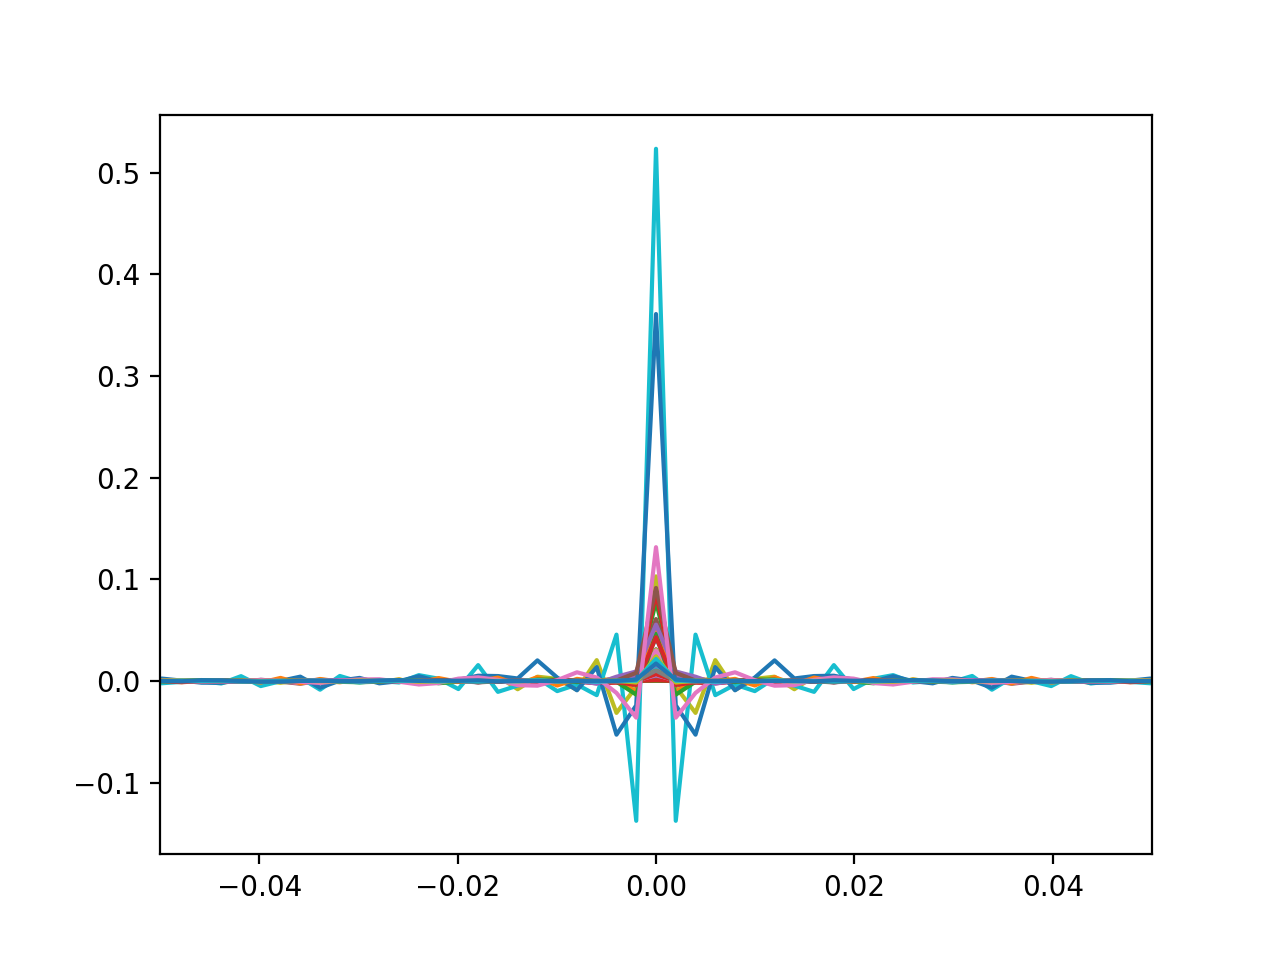

(-0.05, 0.05)

In [27]:
v_tilde_2d_crab_filtered = np.zeros(1004)
plt.figure()
for i in range(int(len(v_tot_crab)/1004)):
    v_temp, fringe_temp = get_fft(v_new_crab[i*1004:(i+1)*1004], lsts_crab[i*1004:(i+1)*1004])
    plt.plot(np.fft.fftshift(fringe_temp), np.fft.fftshift(v_temp), label='bin:{}'.format(i))
    v_tilde_2d_crab_filtered = np.vstack((v_tilde_2d_crab_filtered, v_temp))
plt.xlim(-.05, .05)

<IPython.core.display.Javascript object>


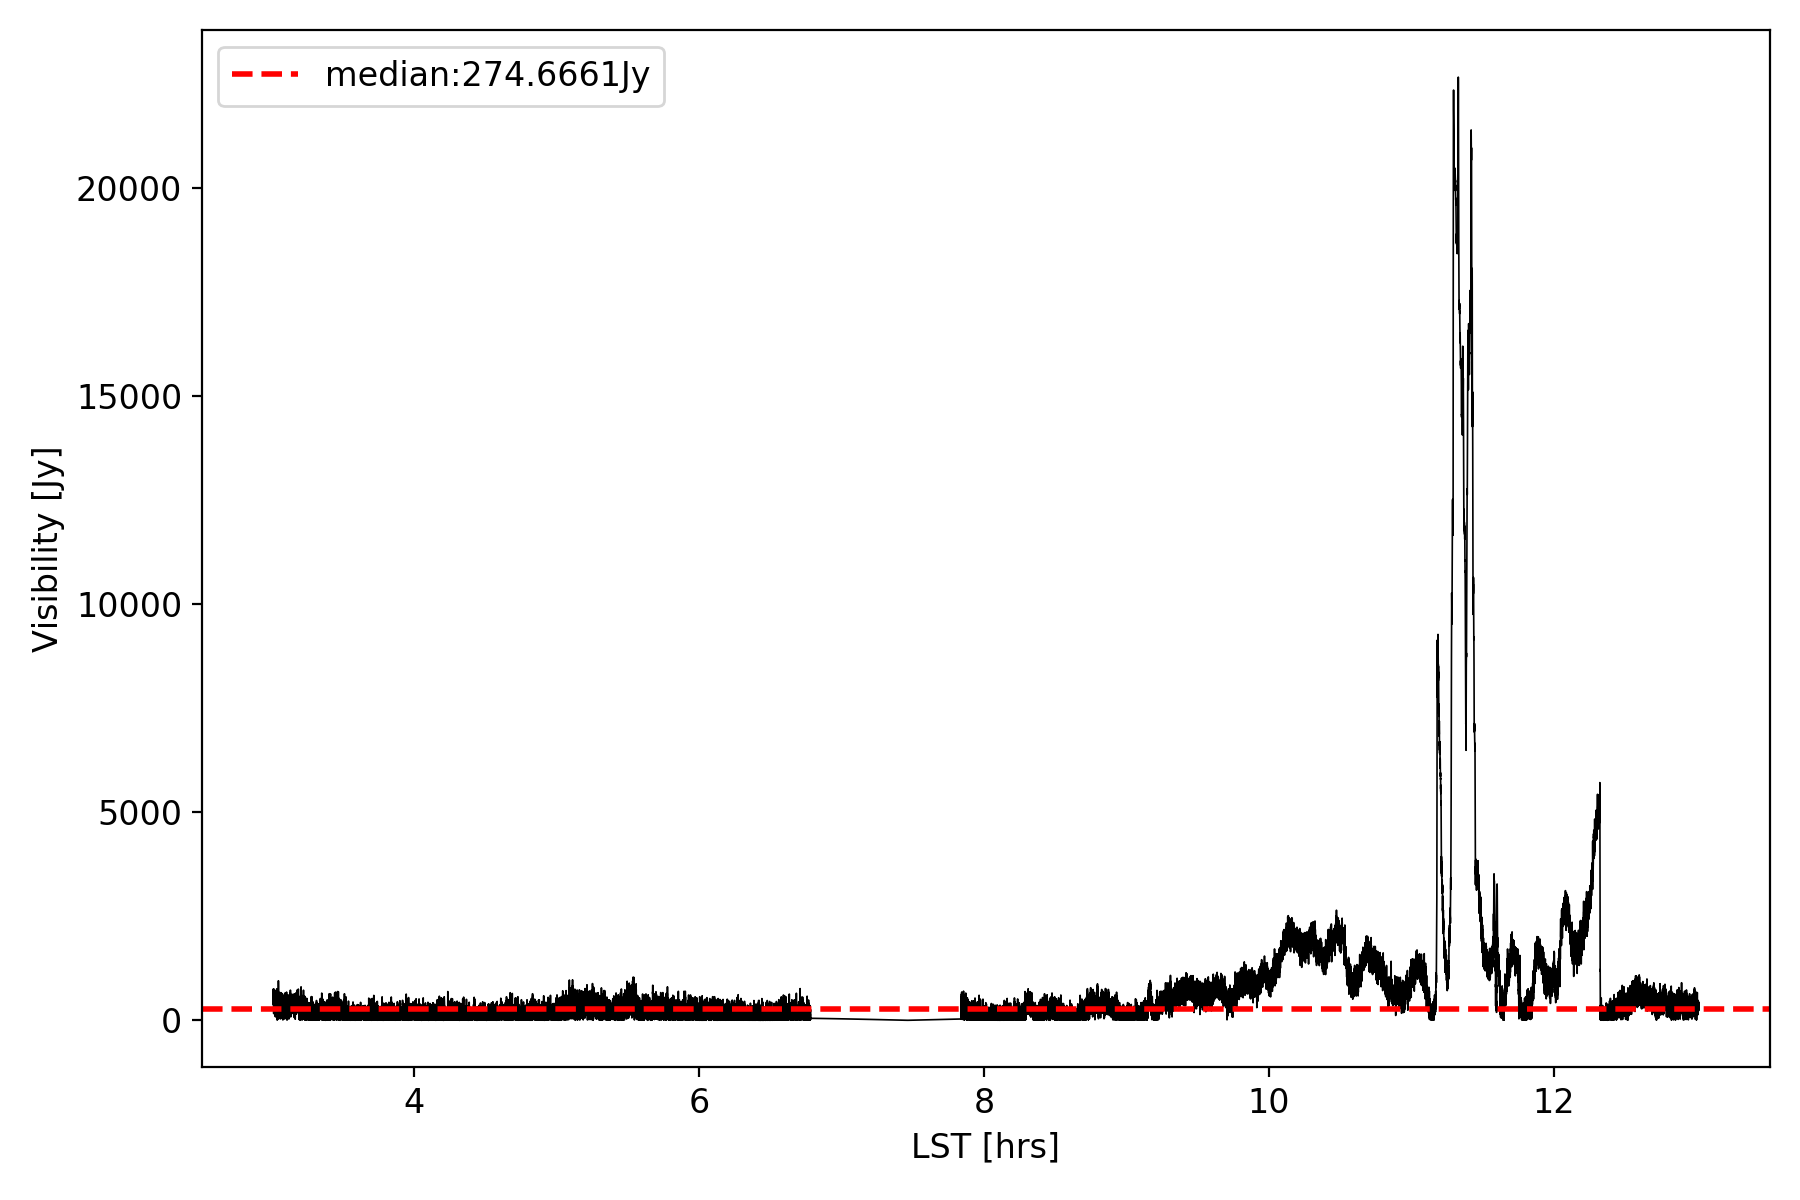

In [28]:
plot_raw(np.abs(v_new_crab)/1.094e-5/2*496, lsts_crab)

In [969]:
file = glob.glob('data/tracking/2458938/*.npz')
alt_az_crab=np.load(file[0], allow_pickle=True)

In [979]:
alt_az_crab['alts'][-2], alt_az_crab['azs'][-2]

(5.03567594971793, 294.1052841473742)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


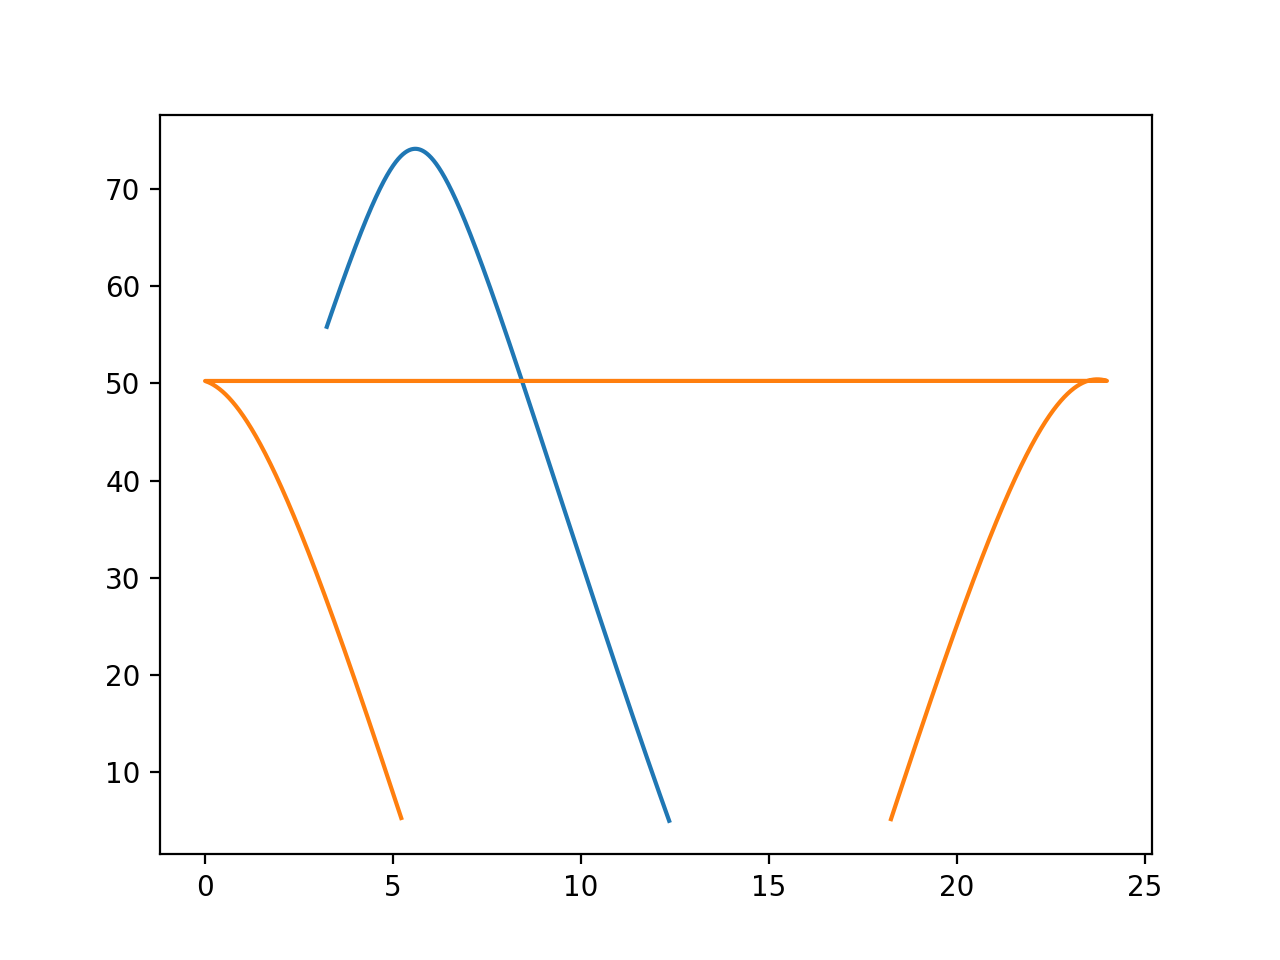

In [984]:
plt.figure()
plt.plot(alt_az_crab['lsts']*12/np.pi, alt_az_crab['alts'])
plt.plot((alt_az_sun['lsts']*12/np.pi), alt_az_sun['alts'])

In [31]:
from matplotlib.colors import LogNorm

<IPython.core.display.Javascript object>


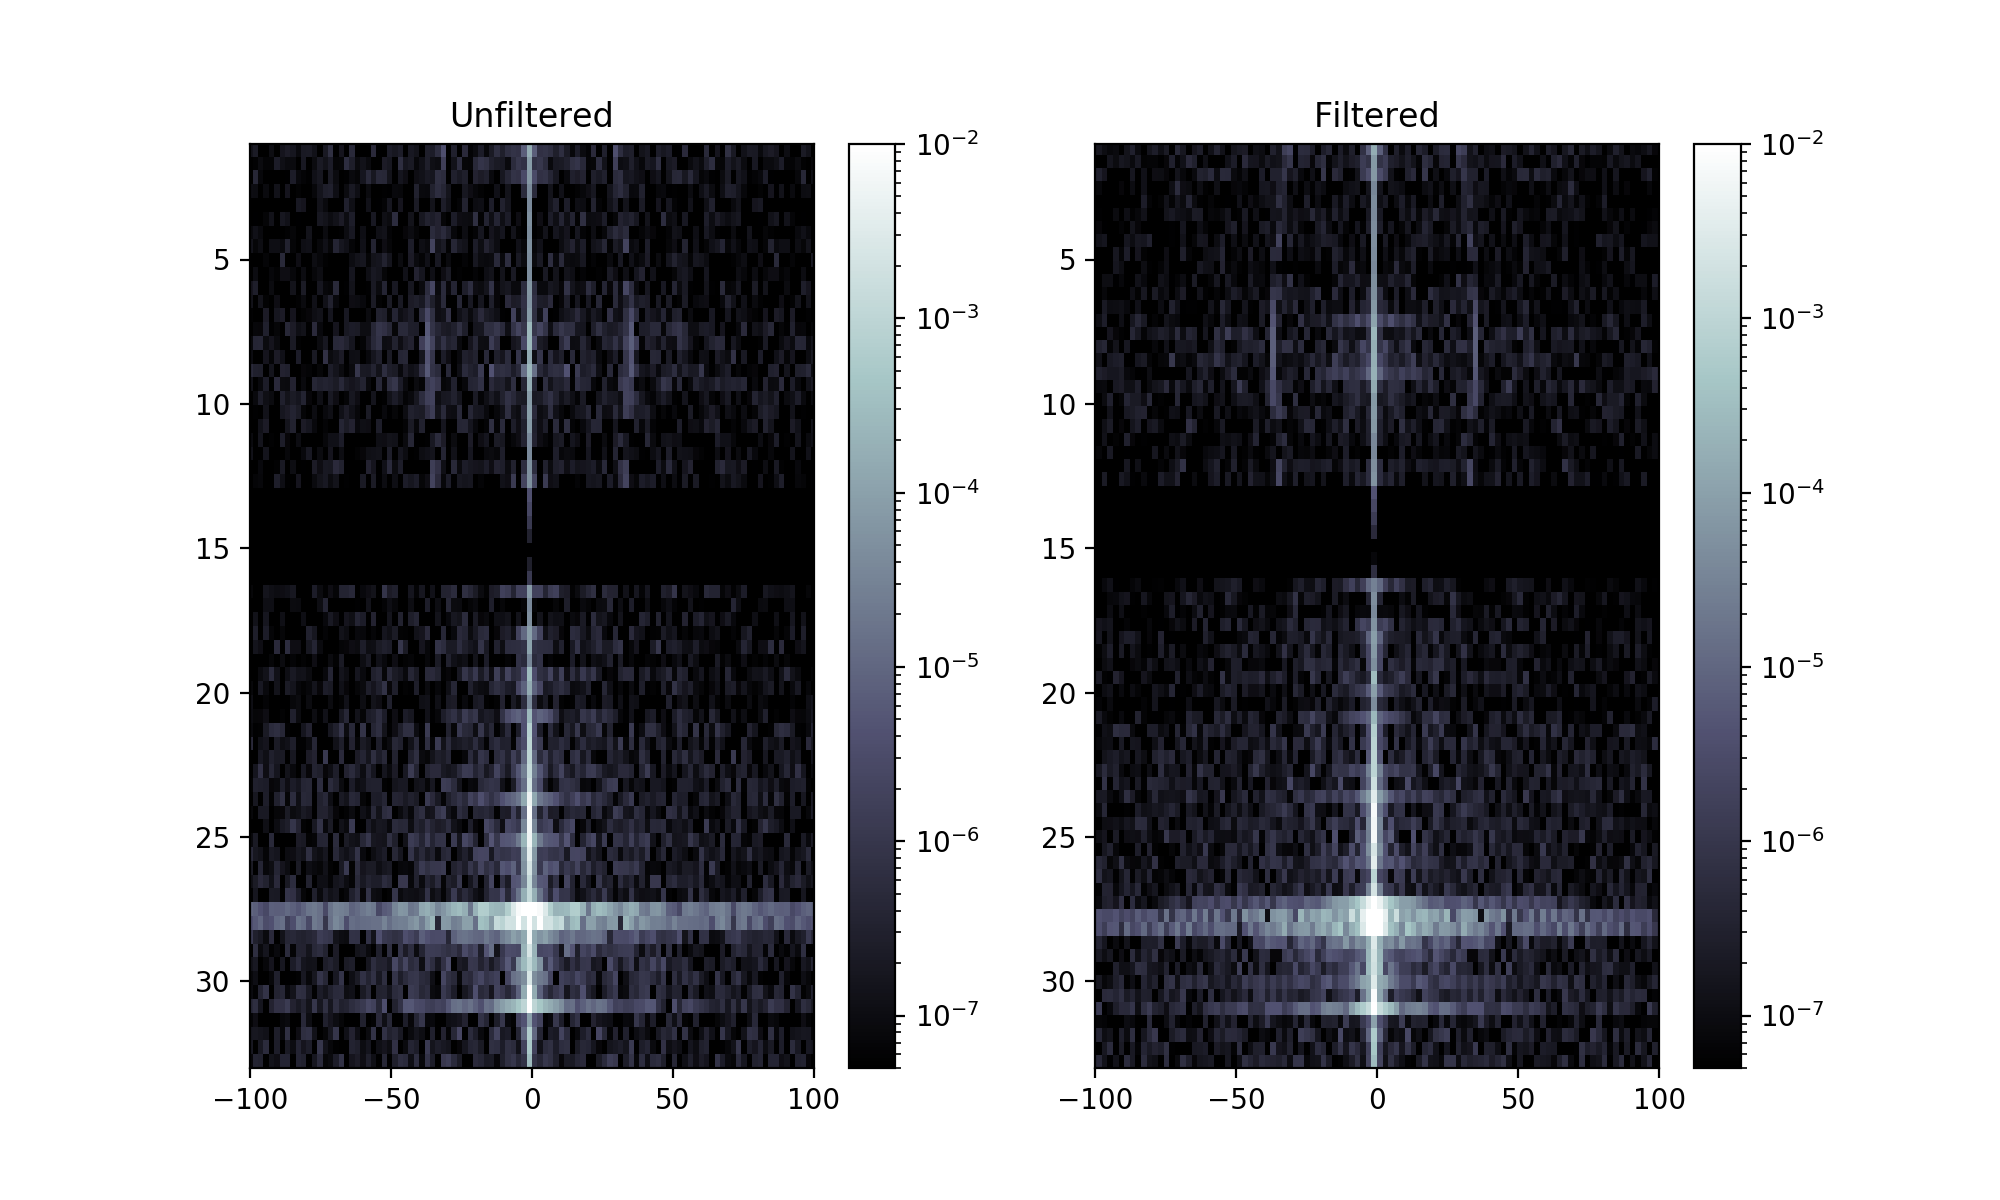

In [32]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.title('Unfiltered')
plt.imshow(np.fft.fftshift(np.abs(v_tilde_2d_crab)**2, axes=1), aspect='auto', norm=LogNorm(5e-8, 1e-2),
          extent = [np.fft.fftshift(fringe_freq_crab)[-1]*1e3, np.fft.fftshift(fringe_freq_crab)[0]*1e3, 33, 0], cmap='bone')
plt.colorbar()
plt.xlim(-100, 100)
plt.ylim(33,1 )
plt.subplot(122)
plt.title('Filtered')
plt.imshow(np.fft.fftshift(np.abs(v_tilde_2d_crab_filtered)**2, axes=1), aspect='auto', norm=LogNorm(5e-8, 1e-2),
          extent = [np.fft.fftshift(fringe_freq_crab)[-1]*1e3, np.fft.fftshift(fringe_freq_crab)[0]*1e3, 33, 0], cmap='bone')
plt.colorbar()
plt.xlim(-100, 100)
plt.ylim(33,1 )
plt.savefig('Eye_of_Sauron.pdf')

# Full day sun

In [966]:
ss['crab'].ra/14

5.9737946428571425

In [1184]:
B_NS

1.64906

In [148]:
file = glob.glob('data/tracking/2458924/*.npz')
alt_az_sun=np.load(file[0], allow_pickle=True)

In [223]:
times_ratio = lsts_sun/(2*np.pi)

In [238]:
dec

-0.03407720734780491

In [234]:
alt = [coord.get_altaz(RA*180/np.pi, dec*180/np.pi,2458924+t )[0] for t in times_ratio]

In [220]:
lsts_sun[0]

5.193751354113505

In [154]:
np.where(lsts_sun<2*np.pi)

(array([    0,     1,     2, ..., 14978, 14979, 14980]),)

In [183]:
alts_sun = np.concatenate((np.linspace(alt_az_sun['alts'][244], alt_az_sun['alts'][884], 14980), np.linspace(alt_az_sun['alts'][885], alt_az_sun['alts'][-1], int(len(lsts_sun)-14980))))

In [241]:
alt_az_sun['alts'][844]

50.41790833441244

In [248]:
u = np.concatenate((np.linspace(B_EW/lamb*np.sin(alt_az_sun['alts'][244]*np.pi/180), B_EW/lamb*np.sin(alt_az_sun['alts'][844]*np.pi/180), 14980),
    np.linspace(B_EW/lamb*np.sin(alt_az_sun['alts'][844]*np.pi/180), B_EW/lamb*np.sin(alt_az_sun['alts'][-1]*np.pi/180), int(len(lsts_sun)-14980))))

<IPython.core.display.Javascript object>


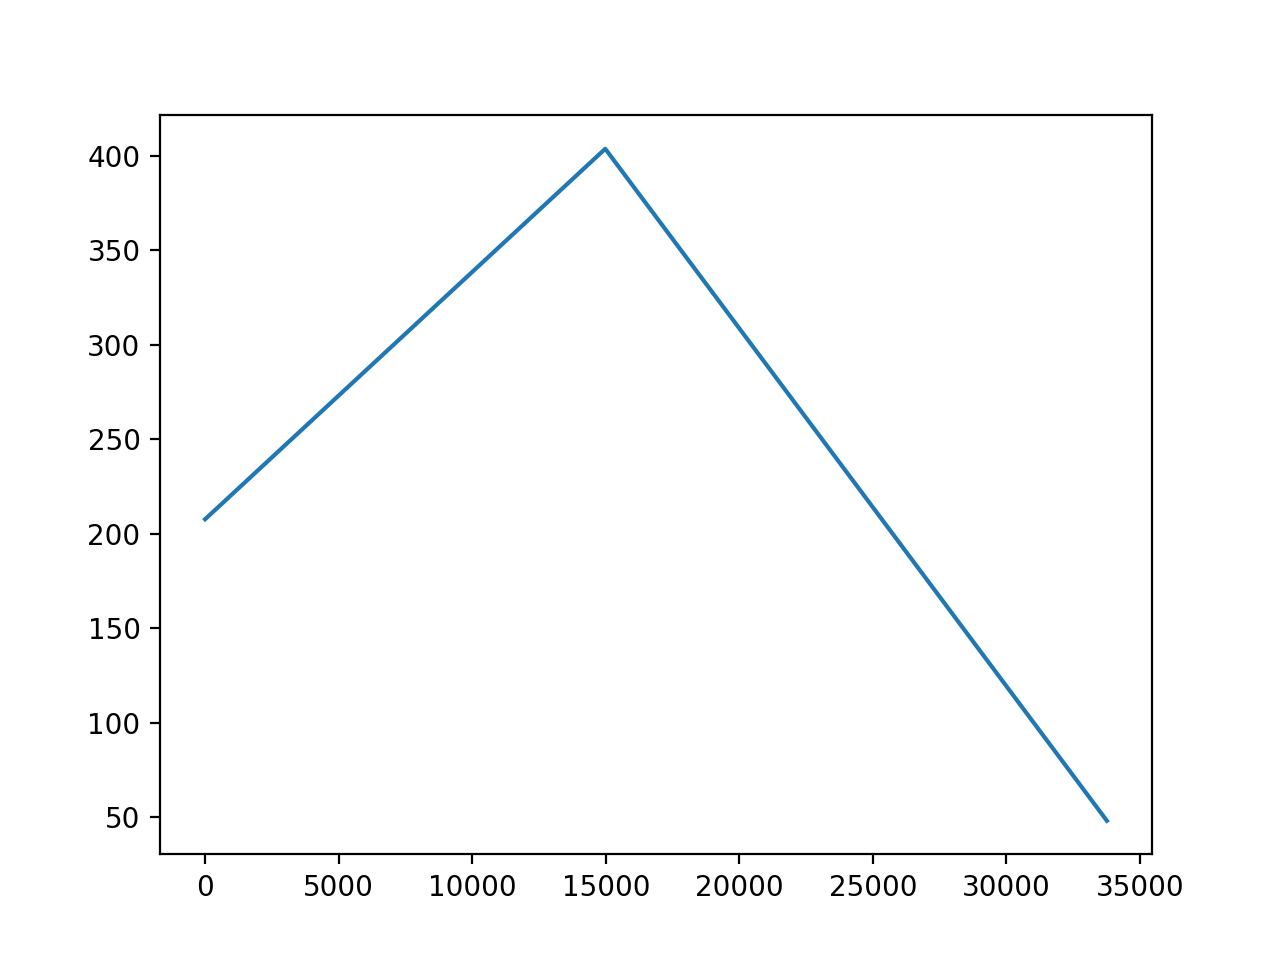

In [249]:
plt.figure()
# plt.plot(alt_az_sun['lsts'], alt_az_sun['alts'])
plt.plot(u)


In [963]:
alt_az_sun['azs'][-1]

263.83024416404436

In [491]:
times_basil

array([1.58428944e+09, 1.58428944e+09, 1.58428944e+09, ...,
       1.58430565e+09, 1.58430565e+09, 1.58430565e+09])

In [ ]:
v = []
for i in range(10):
    v.append()

In [490]:
np.load()['times']

array([1.58429804e+09, 1.58429804e+09, 1.58429805e+09, ...,
       1.58432320e+09, 1.58432320e+09, 1.58432320e+09])

In [40]:
v_tot_basil, times_basil = get_data_basil() 

v_tot, lst, times, t0, vd, files = get_data_new(str(2458924))

v_tot_sun = np.concatenate((v_tot_basil, v_tot[np.where(vd[-1]['times']>times_basil[-1])[0]]))*6.514353e+12

lsts_sun = lst[np.where(vd[-1]['times']>times_basil[-1])[0][0]] - len(v_tot_basil)*np.pi/12/3600 + np.linspace(0, len(v_tot_sun)*np.pi/12/3600,len(v_tot_sun))



In [41]:
import ugradio.timing as t
from scipy.optimize import curve_fit

In [42]:
#v_tot_sun = v_tot_sun*factor

In [43]:
locs, labels = plt.xticks()  # Get the current locations and labels.
ls = [str(round((float(label.get_text())*12/np.pi%24), 2)) for label in labels]



In [44]:
u=B_EW*np.cos(HA)*np.cos(dec)/lamb + B_NS*np.sin(HA)*np.cos(dec)*np.sin(nch.lat*np.pi/180)/lamb

NameError: name 'B_EW' is not defined

In [45]:
v_t = np.fft.fft(v_tot_sun)
v_t[0] = 0
v_tot_sun = np.fft.ifft(v_t)

<IPython.core.display.Javascript object>


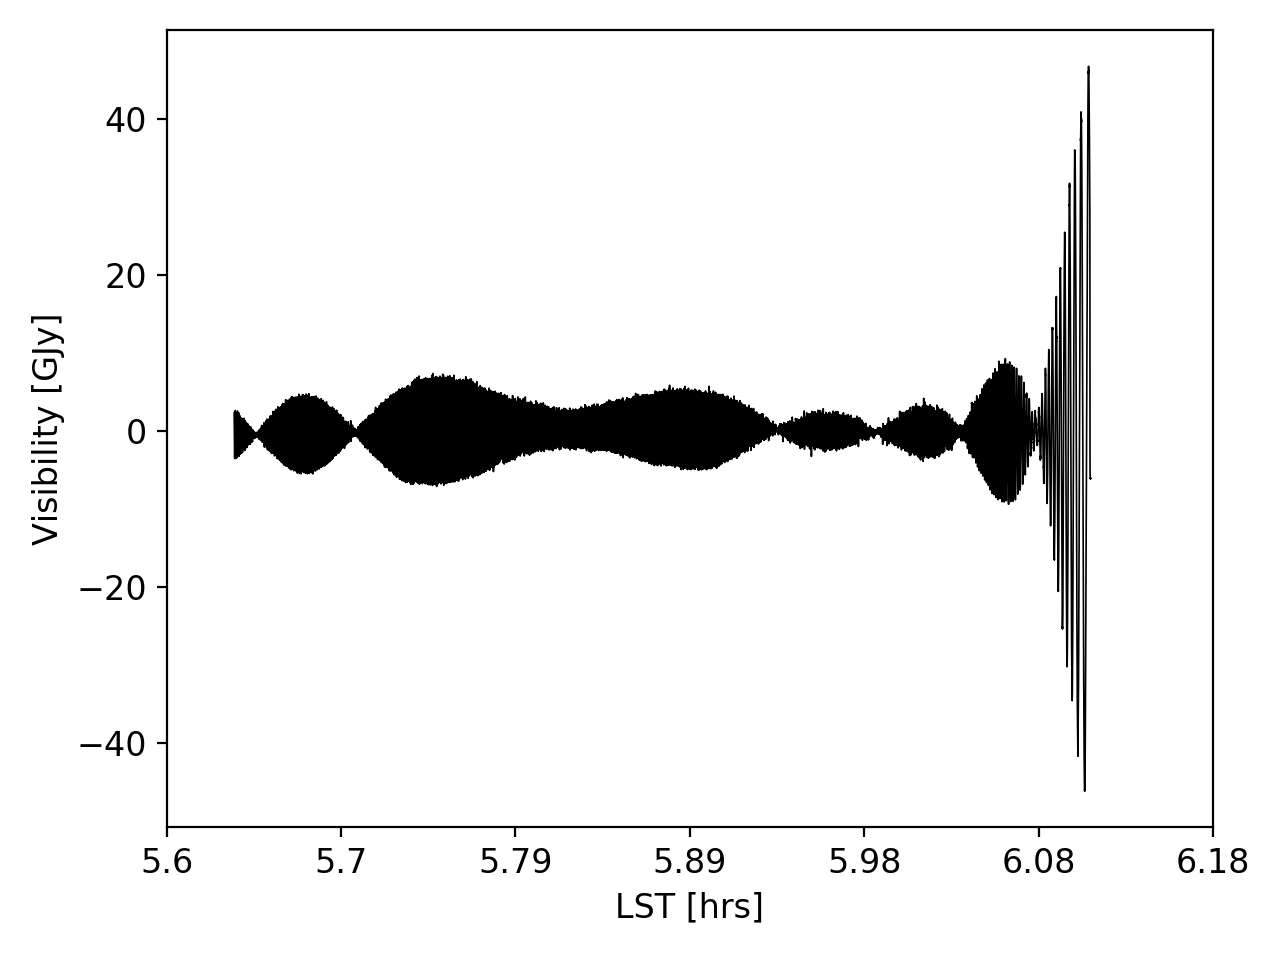

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [46]:
# plt.scatter(lsts*12/np.pi, v_tot, s=.1)
plt.figure()
plt.plot(lsts_sun, v_tot_sun/1e9, 'k',lw=.6)

locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(locs, ls)
plt.xlabel('LST [hrs]', fontsize='12')
plt.ylabel(r'Visibility [GJy]', fontsize='12')
# plt.axhline(mean, lw=2, label='mean:'+str(round(mean, 4))+'mV')
# plt.axhline(np.median(v_tot_sun/1e6), lw=2, c='r', ls='--', label=r'median $\propto$'+str(round(np.median(v_tot_sun/1e6), 3))+'MJy')

# plt.legend(fontsize='12')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.tight_layout()# plt.figure()
# plt.plot(lsts_crab, v_tot_crab-fit)
# plt.plot(lsts_crab, fit)
plt.savefig('sun_init.pdf')

In [47]:
nulls = [148, 254.647, 356, 449]

In [48]:
nulls = [88.1, 145.7, 207.7, 281.4]

In [49]:
nulls = [96.95, 208.422, 318.838,422.266 ]

In [50]:
lsts_nulls = np.array([7.49, 7.26885, 7.02524, 6.7423])%(2*np.pi)
ha_nulls = lst_HA(lsts_nulls, RA)
u_nulls =  B_EW*np.sin(ha_nulls)/lamb+B_NS*np.cos(ha_nulls)/lamb



NameError: name 'RA' is not defined

In [51]:
w_nulls = [91.4, 201.9,312.8, 418.3 ]

In [52]:
u_nulls_test=[188.837, 283.667, 387.886, 470.12]
u_nulls_test_err = [5.2, 3.4, 5.5, 10]

In [53]:
u_nulls = [511, 474, 405, 300]

In [54]:
v_tilde_sun, fringe_freq_sun = get_fft(v_tot_sun, lsts_sun)
v_tilde_2 = v_tilde_sun.copy()
v_tilde_2[np.arange(20)] = 0
v_tilde_2[np.arange(len(fringe_freq_sun)-20, len(fringe_freq_sun))] = 0
v_tilde_2[np.where(fringe_freq_sun<-.04)]=0
v_tilde_2[np.where(fringe_freq_sun>.04)]=0
v_new_sun = np.fft.ifft(v_tilde_2)

In [55]:
nulls = np.array([20.081, 21.157, 23.5, 25.797, 26.87, 27.77, 28.62])

x = 2pi u angular radius of sun

In [56]:
RA = np.mean([coord.sunpos(2458924+t)[0] for t in np.linspace(0,1,100)])*np.pi/180
dec = coord.sunpos(2458924)[1]*np.pi/180

In [57]:
dec

-0.03407720734780491

In [58]:
from scipy.signal import savgol_filter, get_window

In [59]:
sun_envelope  =savgol_filter(np.abs(v_new_sun), 1591, 1)

In [60]:
B_EW, B_NS = 14.68937875751503, 1.5931863727454907
B = np.sqrt(B_EW**2+B_NS**2)

In [61]:
dec = coord.sunpos(2458924)[1]*np.pi/180#ss['crab'].dec*np.pi/180
lamb=3e8/10.7e9
RA = np.mean([coord.sunpos(2458924+t)[0]*np.pi/180 for t in np.linspace(0,1,100)])#ss['crab'].ra*np.pi/180



In [62]:
HA = lst_HA(lsts_sun%(2*np.pi),RA)%(2*np.pi)

In [63]:
u = get_u(20, 0, dec, HA, nch.lat*np.pi/180, 2.5e-3)

In [64]:
u = B_EW*np.sin(HA)*np.cos(dec)/lamb+B_NS*np.cos(HA)*np.cos(dec)*np.sin(nch.lat*np.pi/180)/lamb
v = -np.sin(dec)*np.cos(HA)*B_EW/lamb + np.sin(dec)*np.sin(HA)*B_NS/lamb
w = np.cos(dec)*np.cos(HA)*B_EW/lamb - np.cos(dec)*np.sin(HA)*B_NS/lamb

<IPython.core.display.Javascript object>


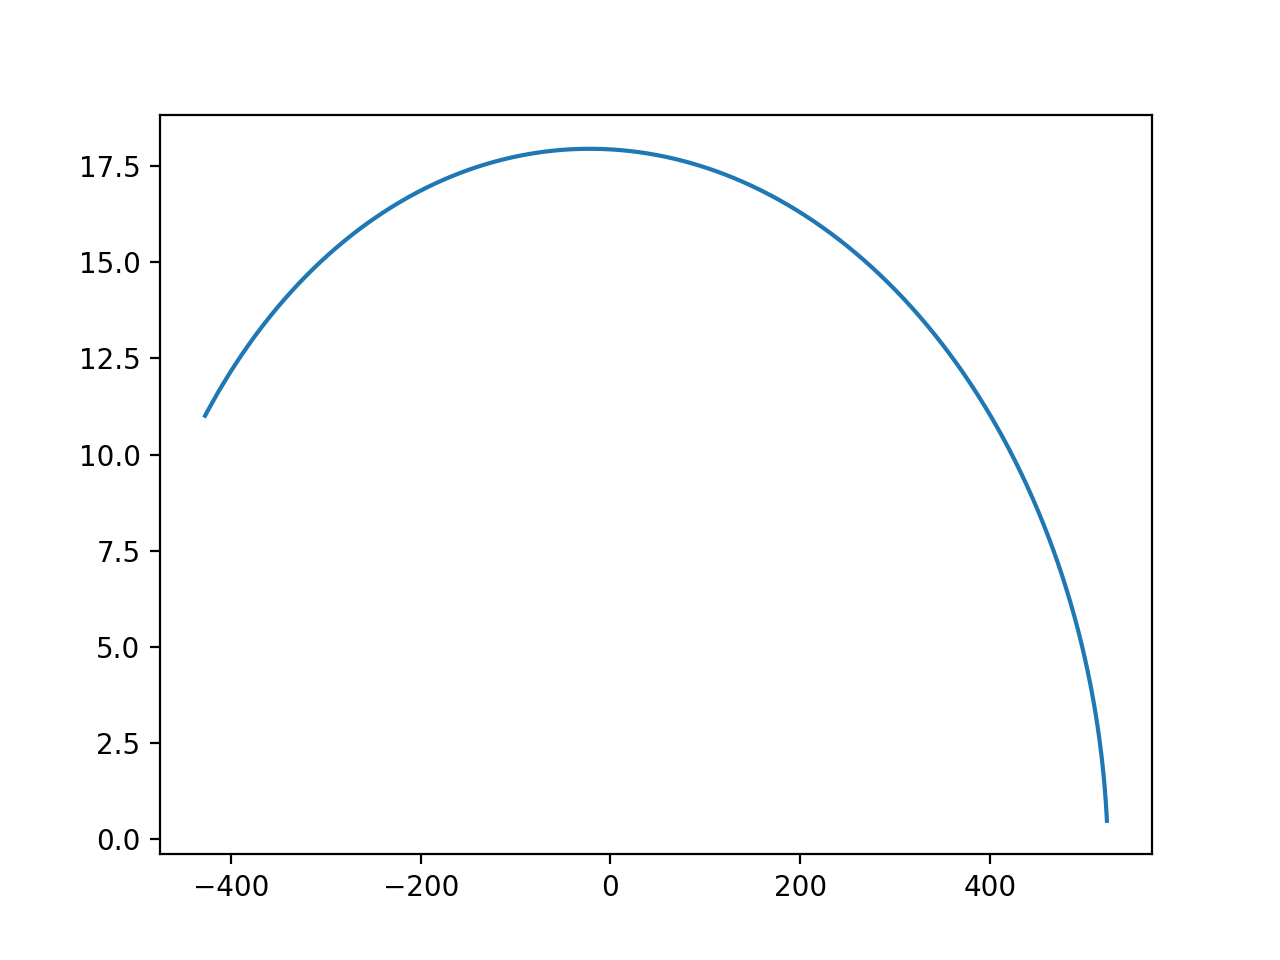

In [65]:
plt.figure()
plt.plot(u, v)

In [66]:
import scipy

<IPython.core.display.Javascript object>


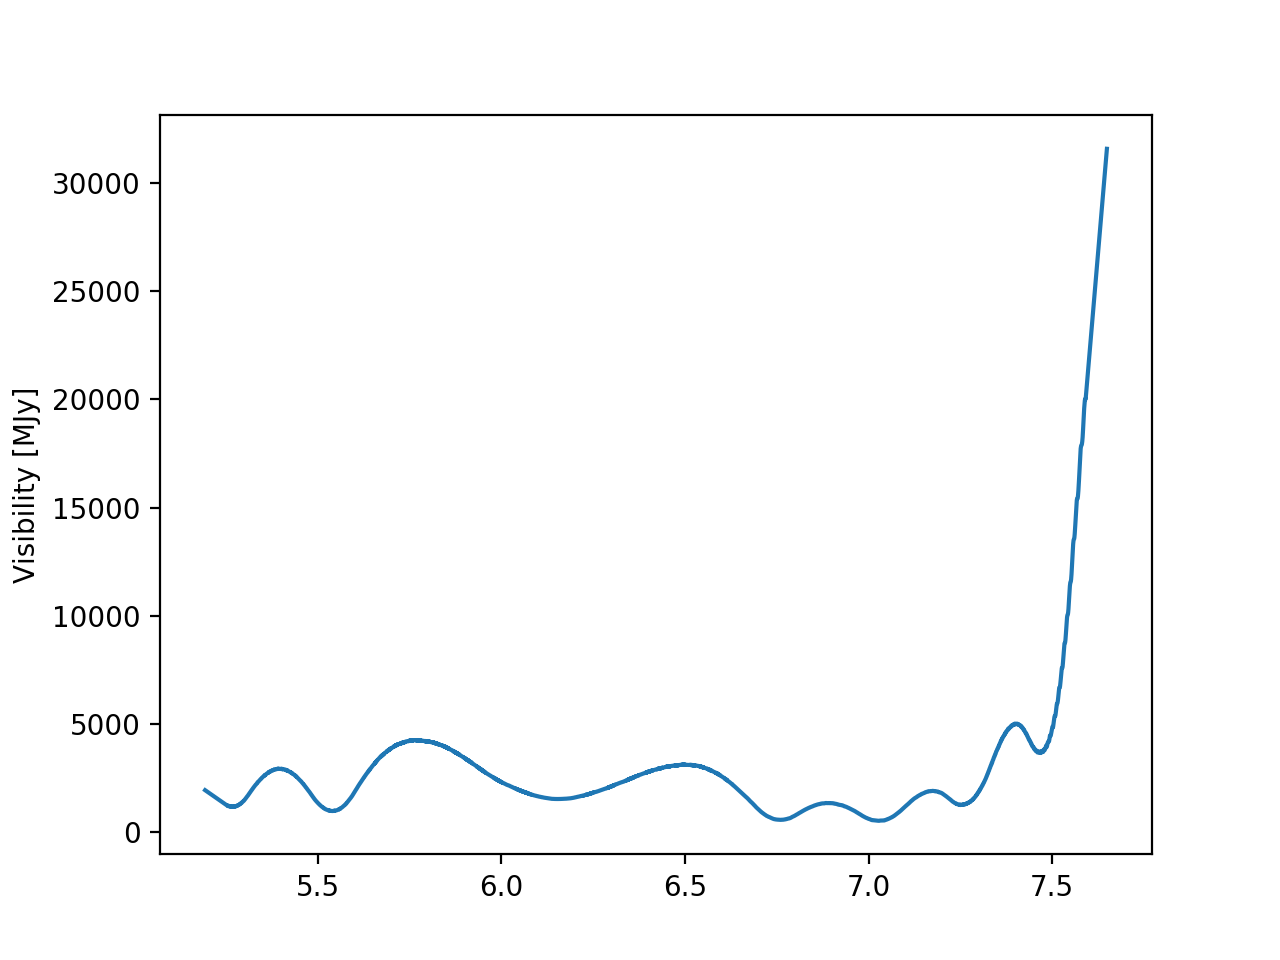

Text(0, 0.5, 'Visibility [MJy]')

In [67]:
plt.figure()
plt.plot(lsts_sun, sun_envelope/1e6)
# plt.plot(v, sun_envelope/1e6)
# plt.plot(w, sun_envelope/1e6)




# plt.plot(lsts_sun, sun_envelope/1e6)
# plt.plot(lsts_sun, fit)
plt.ylabel('Visibility [MJy]')

# plt.plot(lsts_sun, env_fit)
# plt.plot(lsts_sun, get_bessel(x, 1/(m/m_fit), a, p))

In [68]:
env_tilde, env_ff = get_fft(sun_envelope, lsts_sun)

<IPython.core.display.Javascript object>


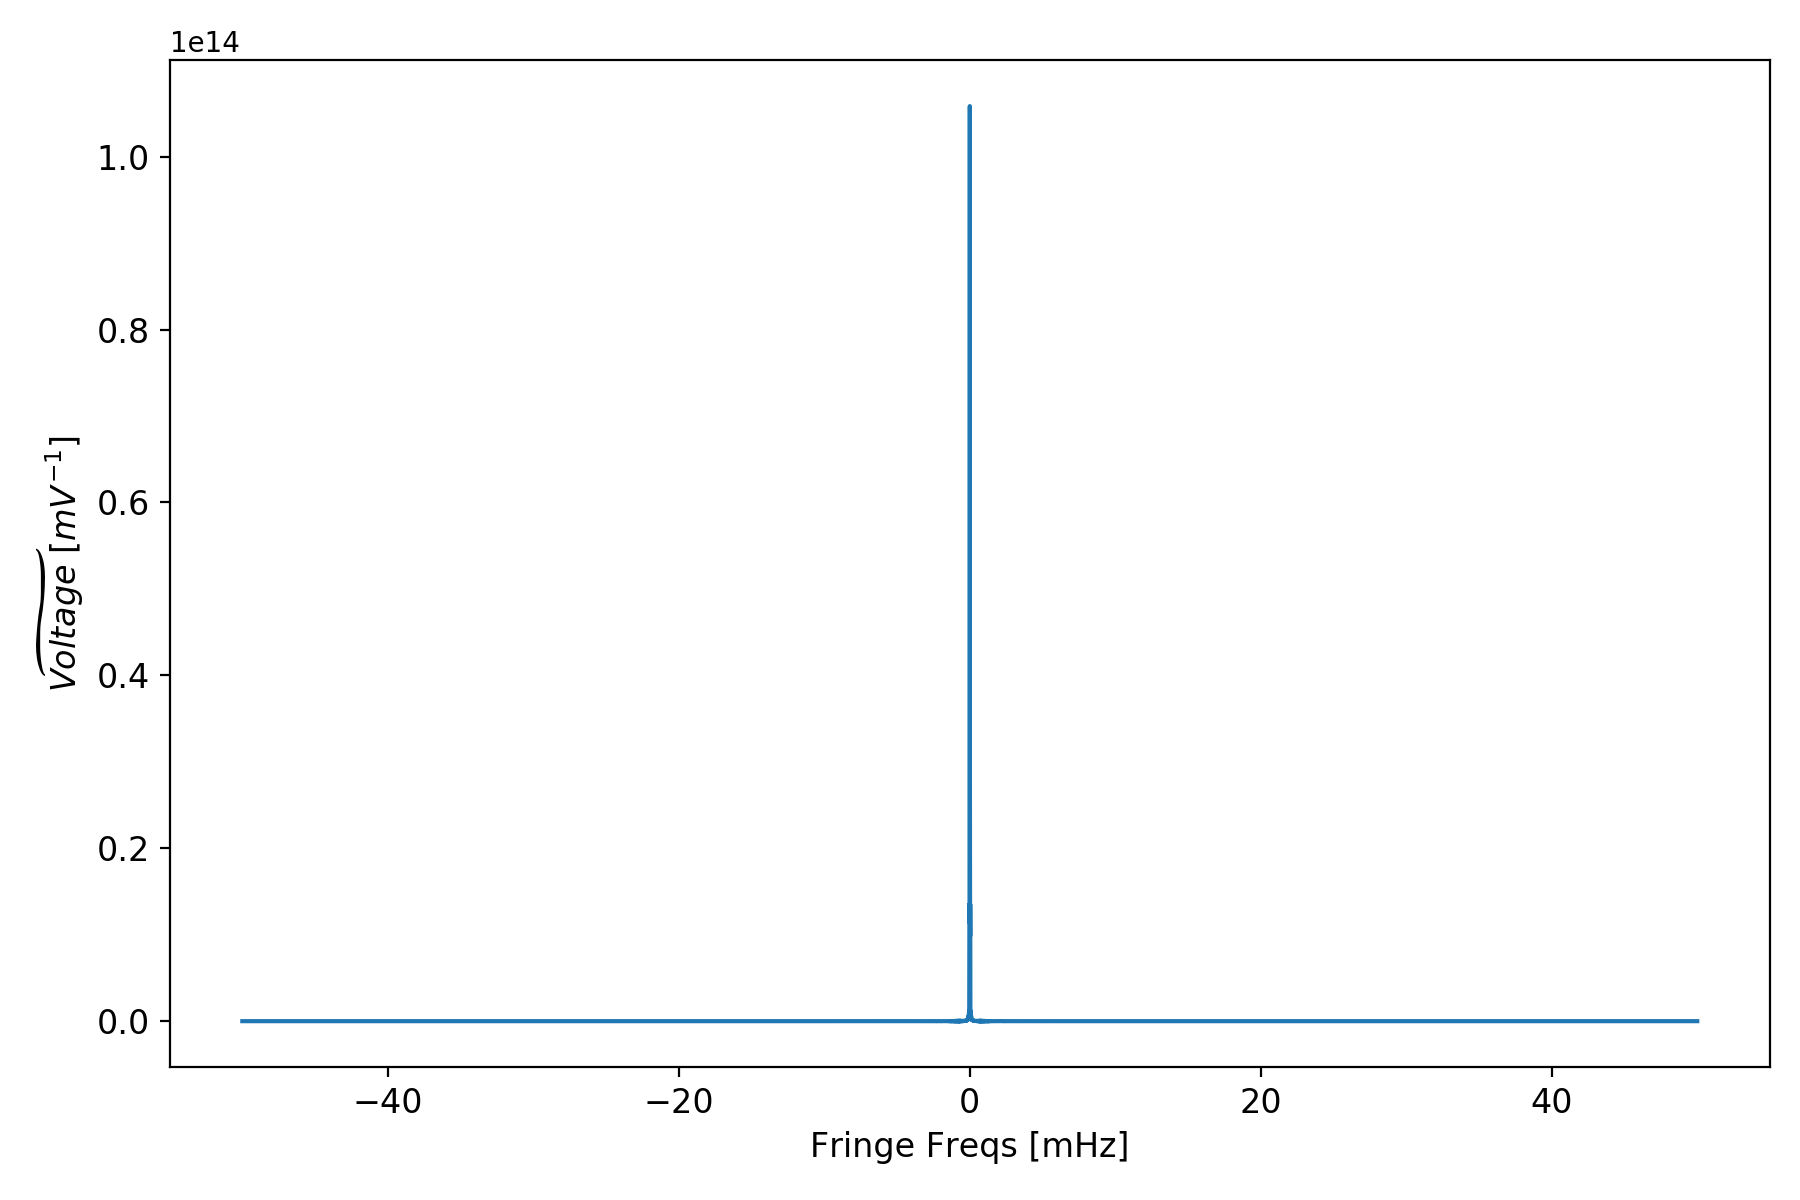

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [69]:
plot_fft(env_tilde, env_ff)

In [70]:
from scipy.special import j1

In [71]:
chi = []
for r in theta_r:
    x = u*2*np.pi*r
    bessel = j1(x)/x
    chi.append(chi2(np.abs(bessel), sun_envelope, .1))

NameError: name 'theta_r' is not defined

<IPython.core.display.Javascript object>


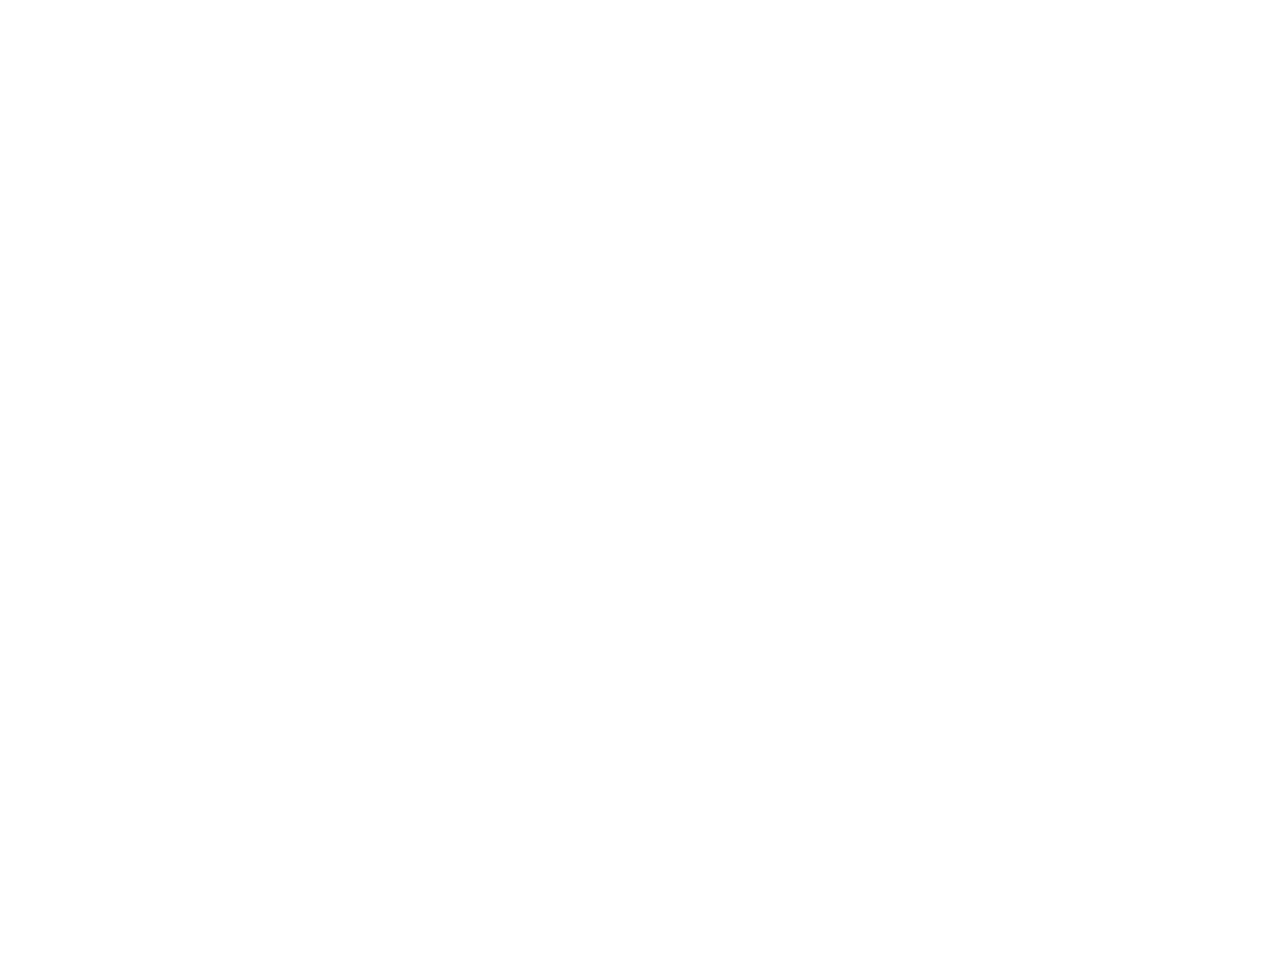

NameError: name 'theta_r' is not defined

In [72]:
plt.figure()
plt.plot(theta_r*180/np.pi, chi)

In [73]:
v_tilde, ffs = get_fft(v_new_sun, lsts_sun)

In [74]:
33760/10

3376.0

Fringe is telling us with prescision where the antennas are

In [171]:
v_tilde_2d_o = np.zeros(1055)
# plt.figure()
for i in range(int(len(v_tot_sun)/1055)):
    v_temp, fringe_temp = get_fft(v_tot_sun[i*1055:(i+1)*1055], lsts_sun[i*1055:(i+1)*1055])
#     plt.plot(np.fft.fftshift(fringe_temp), np.fft.fftshift(v_temp), label='bin:{}'.format(i))
    v_tilde_2d_o = np.vstack((v_tilde_2d, v_temp))
# plt.xlim(-.05, .05)

In [83]:
v_tilde_2d_filtered = np.zeros(1055)
# plt.figure()
for i in range(int(len(v_new_sun)/1055)):
    v_temp, fringe_temp = get_fft(v_new_sun[i*1055:(i+1)*1055], lsts_sun[i*1055:(i+1)*1055])
#     plt.plot(np.fft.fftshift(fringe_temp), np.fft.fftshift(v_temp), label='bin:{}'.format(i))
    v_tilde_2d_filtered = np.vstack((v_tilde_2d_filtered, v_temp))
# plt.xlim(-.05, .05)

In [84]:
from matplotlib.colors import LogNorm

<IPython.core.display.Javascript object>


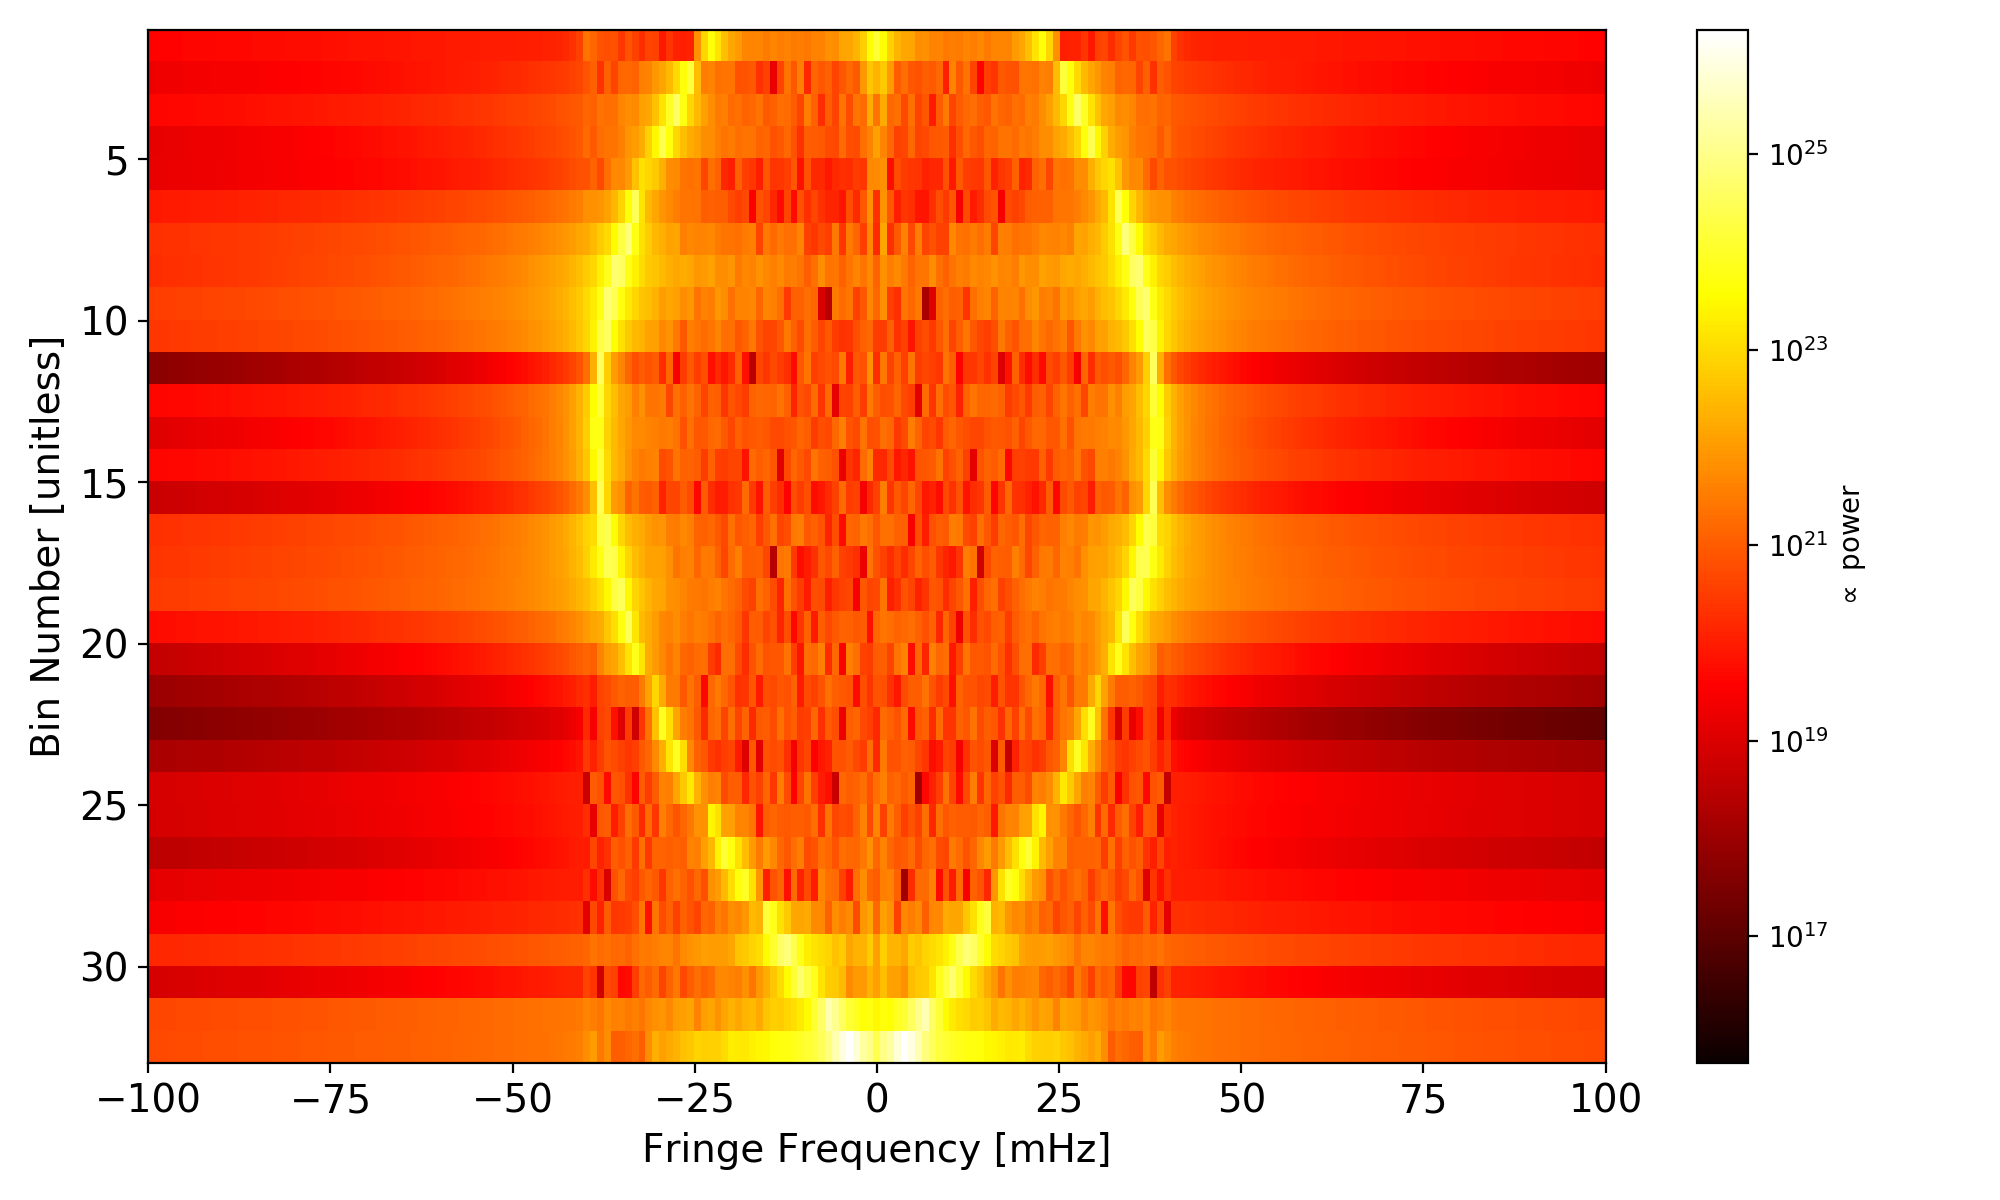

In [86]:
plt.figure(figsize=(10,6))
plt.imshow(np.fft.fftshift(np.abs(v_tilde_2d_filtered)**2, axes=1), aspect='auto',norm=LogNorm(),
          extent = [np.fft.fftshift(fringe_freq_sun)[-1]*1e3, np.fft.fftshift(fringe_freq_sun)[0]*1e3, 33, 0], cmap='hot')
plt.colorbar(label=r'$\propto$ power')
plt.xlim(-100, 100)
plt.ylim(33,1 )
plt.xlabel('Fringe Frequency [mHz]', fontsize=14)
plt.ylabel('Bin Number [unitless]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.tight_layout()
plt.savefig('Eye_of_Sauron.pdf')

# Least Squares

In [62]:
from ugradio import nch

In [63]:
B_EW = np.linspace(10, 25, 100)
Q_EW = B_EW/lamb*np.cos(dec)
B_NS = np.linspace(-5, 5, 100)


In [64]:
3e8/10.7e9

0.028037383177570093

In [65]:
dec = ss['crab'].dec*np.pi/180
RA = ss['crab'].ra*np.pi/180

NameError: name 'ss' is not defined

In [66]:
lamb

0.028037383177570093

In [67]:
dec = np.mean([coord.sunpos(2458924+t)[1]*np.pi/180 for t in np.linspace(0,1,100)])#ss['crab'].dec*np.pi/180



In [68]:
dec

-0.030630009637490727

In [1878]:
v_tot_s = np.fft.fft(v_tot_sun)
v_tot_s[0] = 0
v_tot_sun = np.fft.ifft(v_tot_s)

In [112]:
#Make range of guesses for Q
dec = np.mean([coord.sunpos(2458924+t)[1]*np.pi/180 for t in np.linspace(0,1,100)])#
lamb=3e8/10.7e9
RA = np.mean([coord.sunpos(2458924+t)[0]*np.pi/180 for t in np.linspace(0,1,100)])

B_EW = np.linspace(10, 25, 100)
Q_EW = B_EW/lamb*np.cos(dec)

B_NS = np.linspace(-4, 4, 100)
Q_NS = B_NS/lamb*np.cos(dec)*np.sin(nch.lat*np.pi/180)

#Make HA
HA = lst_HA(lsts_sun%(2*np.pi),RA)
#Call the voltage data, d
d = np.real(v_tot_sun)

#Make empty lists for the results and the residuals
AB_results = np.zeros((len(Q_EW), len(Q_NS), 2))

residuals = np.zeros((len(Q_EW), len(Q_NS)))

for i in range(len(Q_EW)):
    for j in range(len(Q_NS)):
        nu_taug = Q_EW[i]*np.sin(HA) + Q_NS[j]*np.cos(HA)
        A = np.vstack((np.cos(2*np.pi*nu_taug), np.sin(2*np.pi*nu_taug)))
        x, res, _, _ = np.linalg.lstsq(A.T, d)
        AB_results[i,j, 0] = x[0]
        AB_results[i,j, 1] = x[1]
        residuals[i,j]  = res
    if i%10 ==0:
        print(i)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


0
10
20
30
40
50
60
70
80
90


<IPython.core.display.Javascript object>


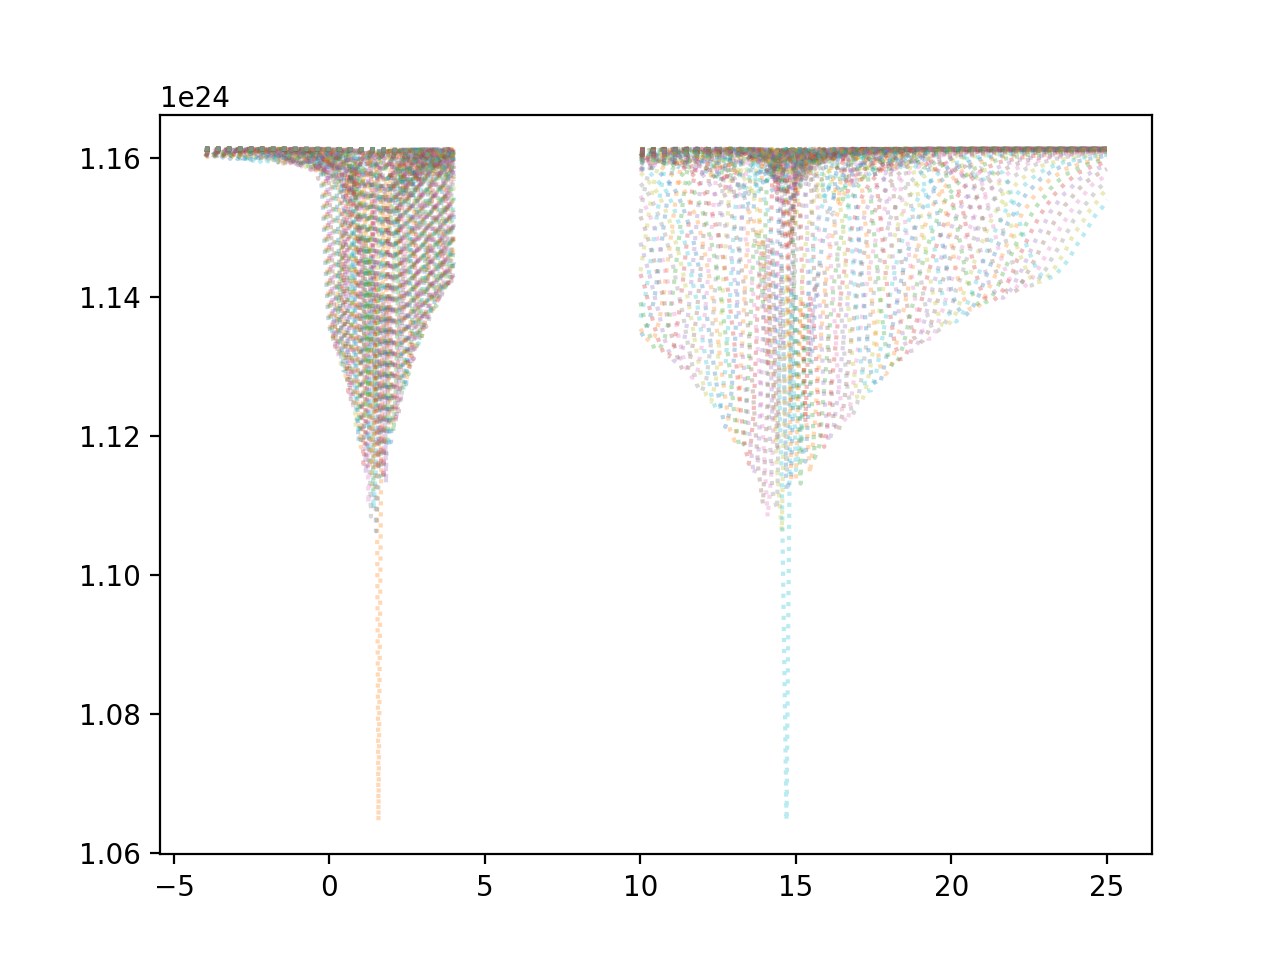

In [113]:
plt.figure()
for i in range(100):
    plt.plot(B_EW, residuals[:,i], ':', alpha=.3)
# plt.plot(B_NS, np.median(residuals, axis=1), 'k')


for i in range(100):
    plt.plot(B_NS, residuals[i,:], ':', alpha=.3)
# plt.plot(B_EW, np.median(residuals, axis=0), 'k')



<IPython.core.display.Javascript object>


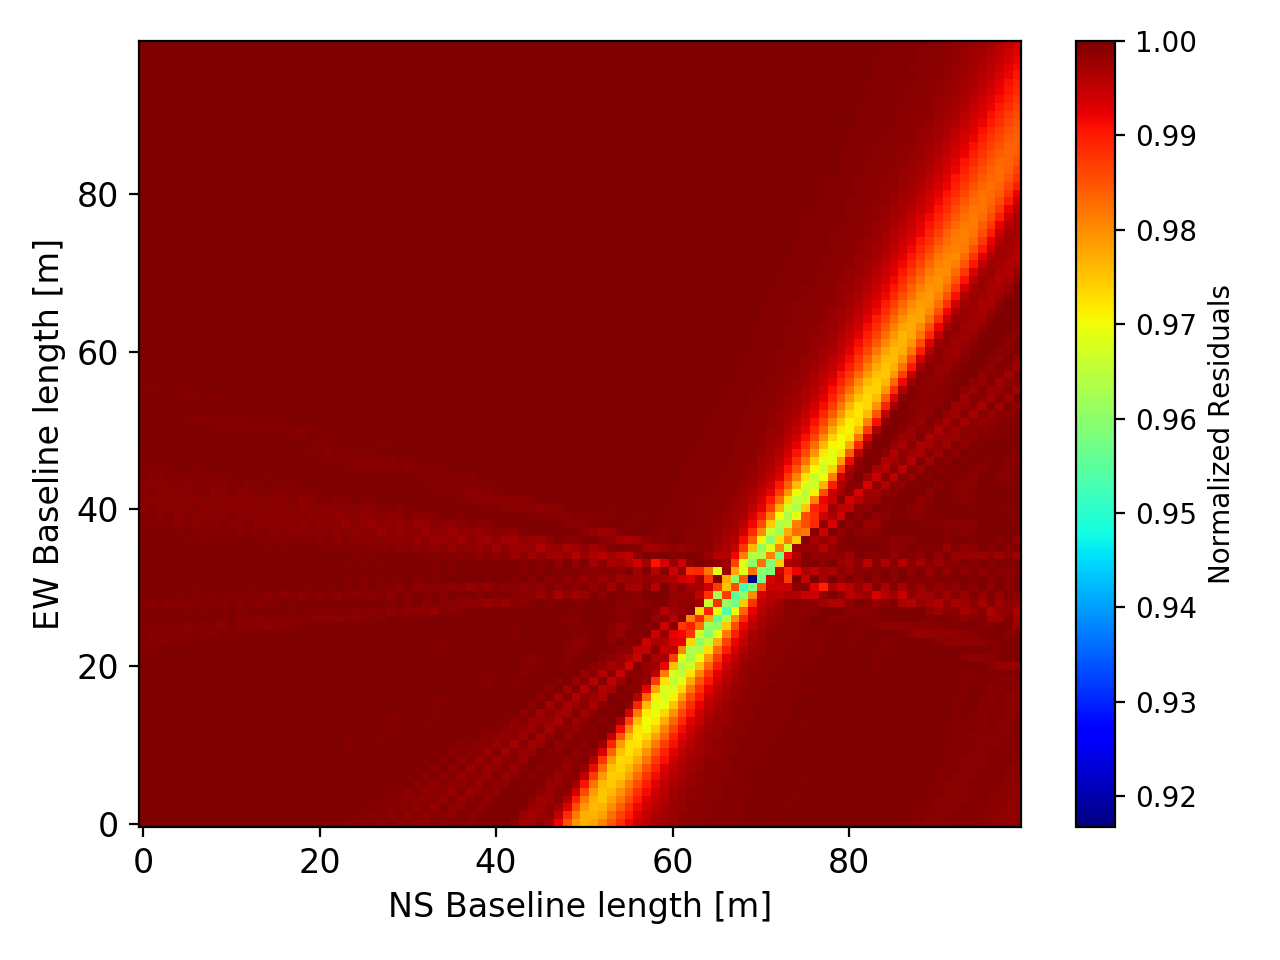

In [114]:
plt.figure()
indices = np.arange(100)

plt.imshow(residuals/residuals.max(), cmap='jet', aspect='auto', origin='lower')#, extent=[B_NS[0], B_NS[-1], B_EW[0], B_EW[-1]])
plt.xlabel('NS Baseline length [m]', fontsize=12)
plt.ylabel('EW Baseline length [m]', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.colorbar(label='Normalized Residuals')
plt.tight_layout()
plt.savefig('residuals.pdf')
# fig = plt.figure()

# ax = fig.add_subplot(111)
# im = plt.imshow(residuals, cmap='jet', aspect='auto', origin='lower', extent=[B_NS[0], B_NS[-1], B_EW[0], B_EW[-1]])


# ax.set_xlabel('NS Baseline length [m]', fontsize=12)
# ax.set_ylabel('EW Baseline length [m]', fontsize=12)
# cbar_axim = fig.add_axes([0.92, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(im, cax=cbar_axim)
# # cbar.set_ticklabels([r'$-10^{-6}$', r'$10^{-5}$', r'$10^{-4}$'])
# # cbar.set_label(r'$\zeta\ [s^{-1}]$', fontsize=16)
# cbar.ax.tick_params(labelsize=12)
# plt.show()

In [115]:
A,B = AB_results[31, 69]

In [118]:
A,B = AB_results[31, 69]
np.arccos(2*np.pi*-0.00011453), np.arcsin(2*np.pi*0.00030068)

(1.5715159400702357, 0.0018892292819980777)

In [119]:
B_EW = np.linspace(10, 25, 100)
B_NS = np.linspace(-5, 5, 100)

In [120]:
# B_EW, B_NS = B_EW[156],B_NS[329]
B_EW, B_NS = B_EW[31], B_NS[69]
# B_EW = 14.8771
# B_NS = 1.64906

In [121]:
B_EW, B_NS

(14.696969696969697, 1.9696969696969697)

In [122]:
AB_results[156, 329]

IndexError: index 156 is out of bounds for axis 0 with size 100

In [123]:
def F_hs(HA, Bs, lamb, dec):
    B_EW, B_NS = Bs[0], Bs[1]
    Q_EW = B_EW/lamb*np.cos(dec)
    Q_NS = B_NS/lamb*np.cos(dec)*np.sin(nch.lat*np.pi/180)
    nu_taug = Q_EW*np.sin(HA) + Q_NS*np.cos(HA)
    A,B = AB_results[62, 21]
    return eq_12(A, B, nu_taug)


In [124]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [125]:
# plt.figure(figsize=(10,6))

# ax1 = plt.subplot(121)
# im1 = ax1.imshow(AB_results[:,:,0], cmap='jet',aspect='auto', origin='lower', extent=[B_NS[0], B_NS[-1], B_EW[0], B_EW[-1]])

# # create an axes on the right side of ax. The width of cax will be 5%
# # of ax and the padding between cax and ax will be fixed at 0.05 inch.
# divider1 = make_axes_locatable(ax1)
# cax1 = divider1.append_axes("right", size="5%", pad=0.05)

# plt.colorbar(im1, cax=cax1)
# ax2 = plt.subplot(122)
# im2 = ax2.imshow(AB_results[:,:,1], cmap='jet',aspect='auto', origin='lower', extent=[B_NS[0], B_NS[-1], B_EW[0], B_EW[-1]] )

# # create an axes on the right side of ax. The width of cax will be 5%
# # of ax and the padding between cax and ax will be fixed at 0.05 inch.
# divider2 = make_axes_locatable(ax2)
# cax2 = divider2.append_axes("right", size="5%", pad=0.05)

# plt.colorbar(im2, cax=cax2)
# plt.tight_layout()

In [126]:
np.pi/2

1.5707963267948966

In [127]:
-np.arcsin(0.00030068)/2/np.pi/10.7e9

-4.472402711210239e-15

<IPython.core.display.Javascript object>


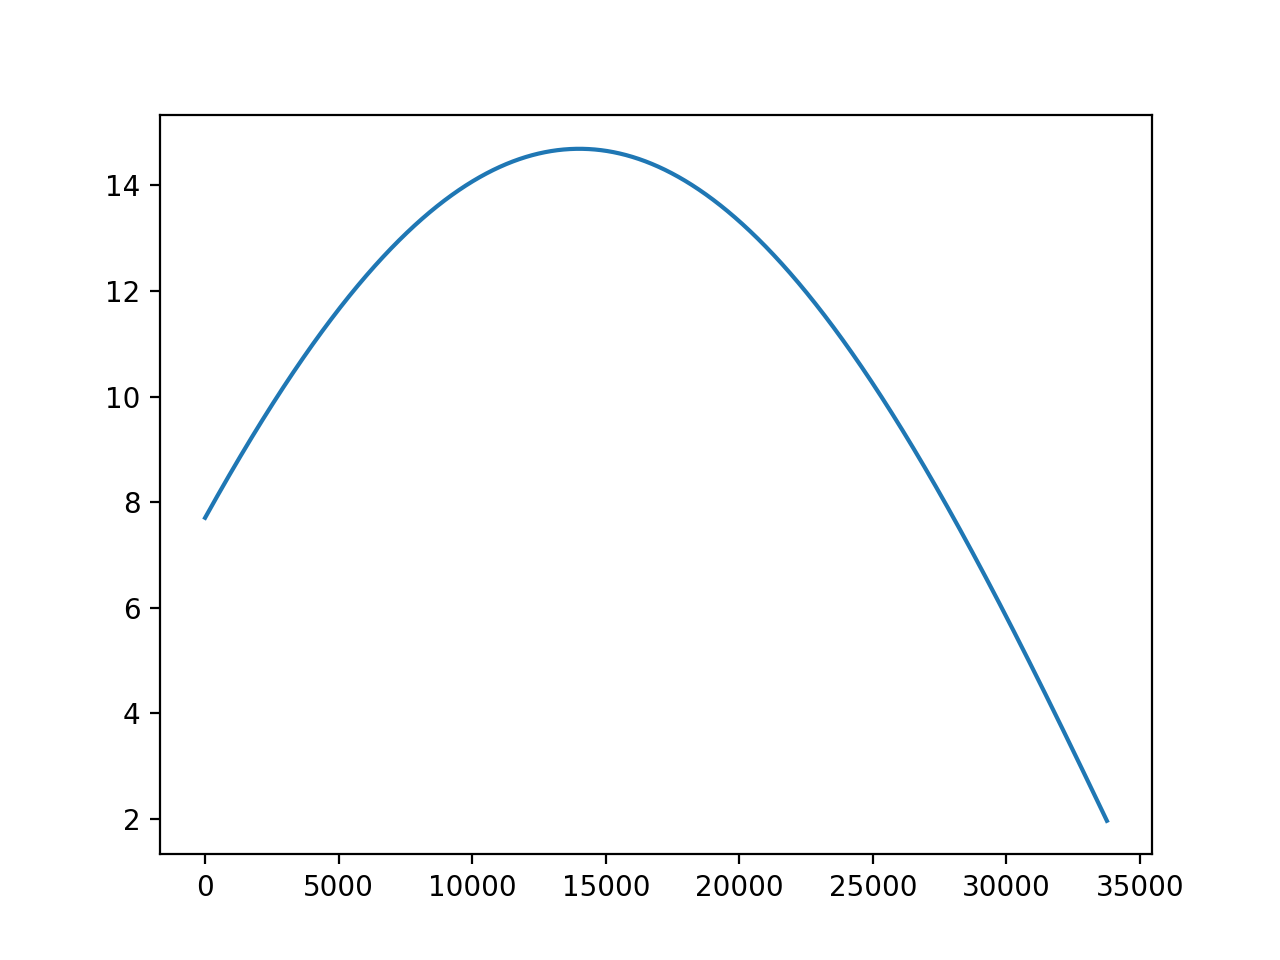

In [128]:
plt.figure()
plt.plot(B_EW*np.cos(HA)*np.cos(dec))

In [129]:
np.arccos(A/2/np.pi), np.arcsin(B/2/np.pi)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arcsin
  """Entry point for launching an IPython kernel.


(nan, nan)

In [130]:
# A,B = -15189.77436918,   8405.0408294
RA = np.mean([coord.sunpos(2458924+t)[0] for t in np.linspace(0,1,100)])*np.pi/180
dec = np.mean([coord.sunpos(2458924+t)[1] for t in np.linspace(0,1,100)])*np.pi/180
HA = lst_HA(lsts_sun%(2*np.pi),RA)
Q_EW = B_EW/lamb*np.cos(dec)
Q_NS = B_NS/lamb*np.cos(dec)*np.sin(nch.lat*np.pi/180)



nu_taug = Q_EW*np.sin(HA) + Q_NS*np.cos(HA)

eq12 = eq_12(A,B, nu_taug)

u = B_EW*np.sin(HA)/lamb*np.cos(dec)+B_NS*np.cos(HA)*np.cos(dec)*np.sin(nch.lat*np.pi/180)/lamb
v = -np.sin(dec)*np.cos(HA)*B_EW/lamb + np.sin(dec)*np.sin(HA)*B_NS/lamb
w = np.cos(dec)*np.cos(HA)*B_EW/lamb - np.cos(dec)*np.sin(HA)*B_NS/lamb

<IPython.core.display.Javascript object>


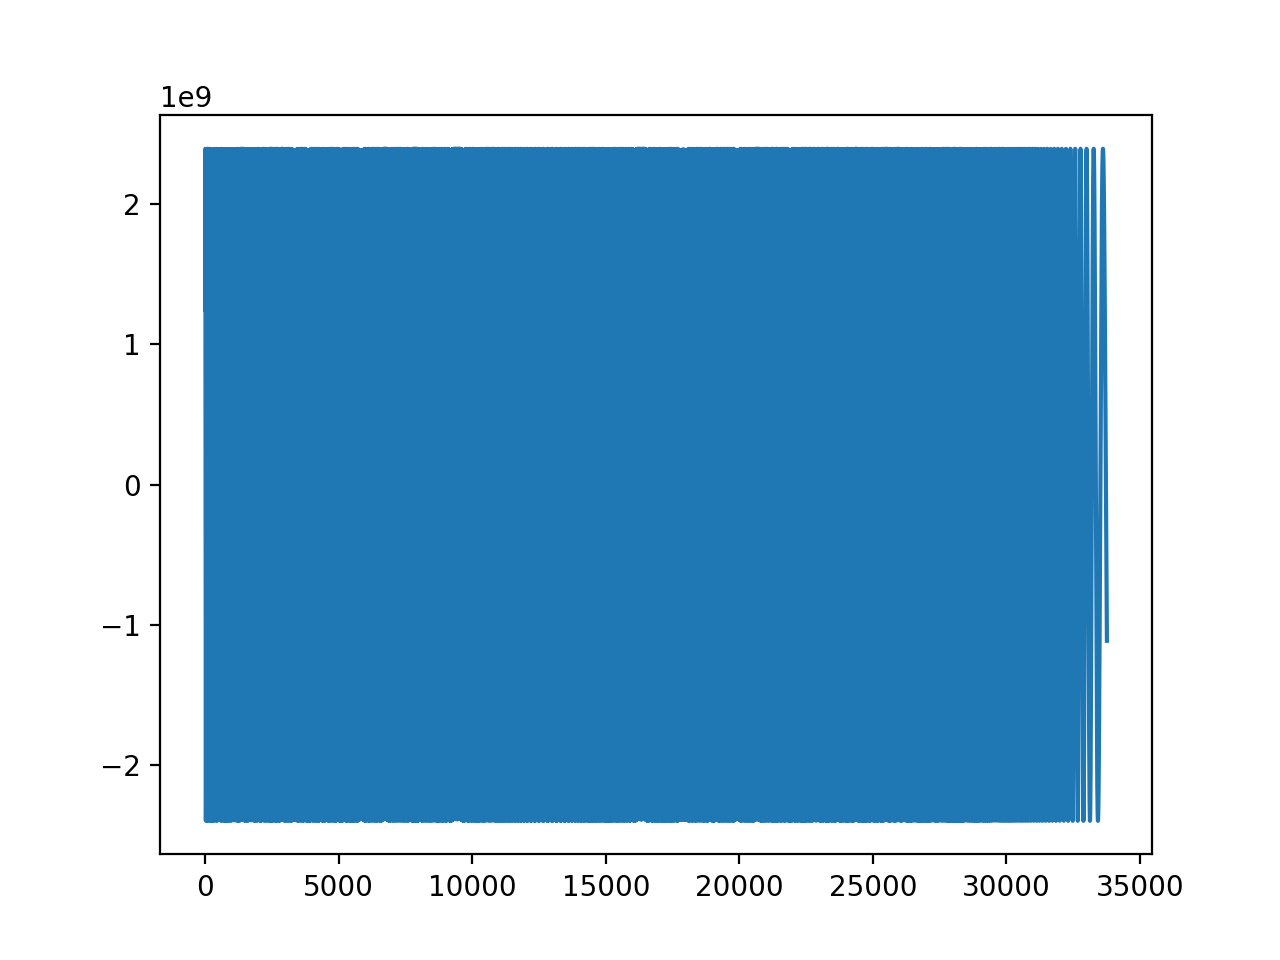

In [131]:
plt.figure()
plt.plot(np.conj(eq12))
# plt.plot(eq12)


# plt.xlim(7.5, 7.75)


In [132]:
factor = 496/.000133424

In [133]:
factor 

3717472.118959108

In [134]:
RA = np.mean([coord.sunpos(2458924+t)[0] for t in np.linspace(0,1,100)])*np.pi/180
dec =  np.mean([coord.sunpos(2458924+t)[1] for t in np.linspace(0,1,100)])*np.pi/180
HA = lst_HA(lsts_sun%(2*np.pi),RA)
Q_EW = B_EW/lamb*np.cos(dec)
Q_NS = B_NS/lamb*np.cos(dec)*np.sin(nch.lat*np.pi/180)



nu_taug = Q_EW*np.sin(HA) + Q_NS*np.cos(HA)

eq12 = eq_12(A,B, nu_taug)

u = B_EW*np.sin(HA)/lamb*np.cos(dec)+B_NS*np.cos(HA)*np.cos(dec)*np.sin(nch.lat*np.pi/180)/lamb
v = -np.sin(dec)*np.cos(HA)*B_EW/lamb + np.sin(dec)*np.sin(HA)*B_NS/lamb
w = np.cos(dec)*np.cos(HA)*B_EW/lamb - np.cos(dec)*np.sin(HA)*B_NS/lamb

In [135]:
v_crab_tilde = np.fft.fft(v_tot_crab)
v_crab_tilde[0] = 0
v_tot_crab = np.fft.ifft(v_crab_tilde)

<IPython.core.display.Javascript object>


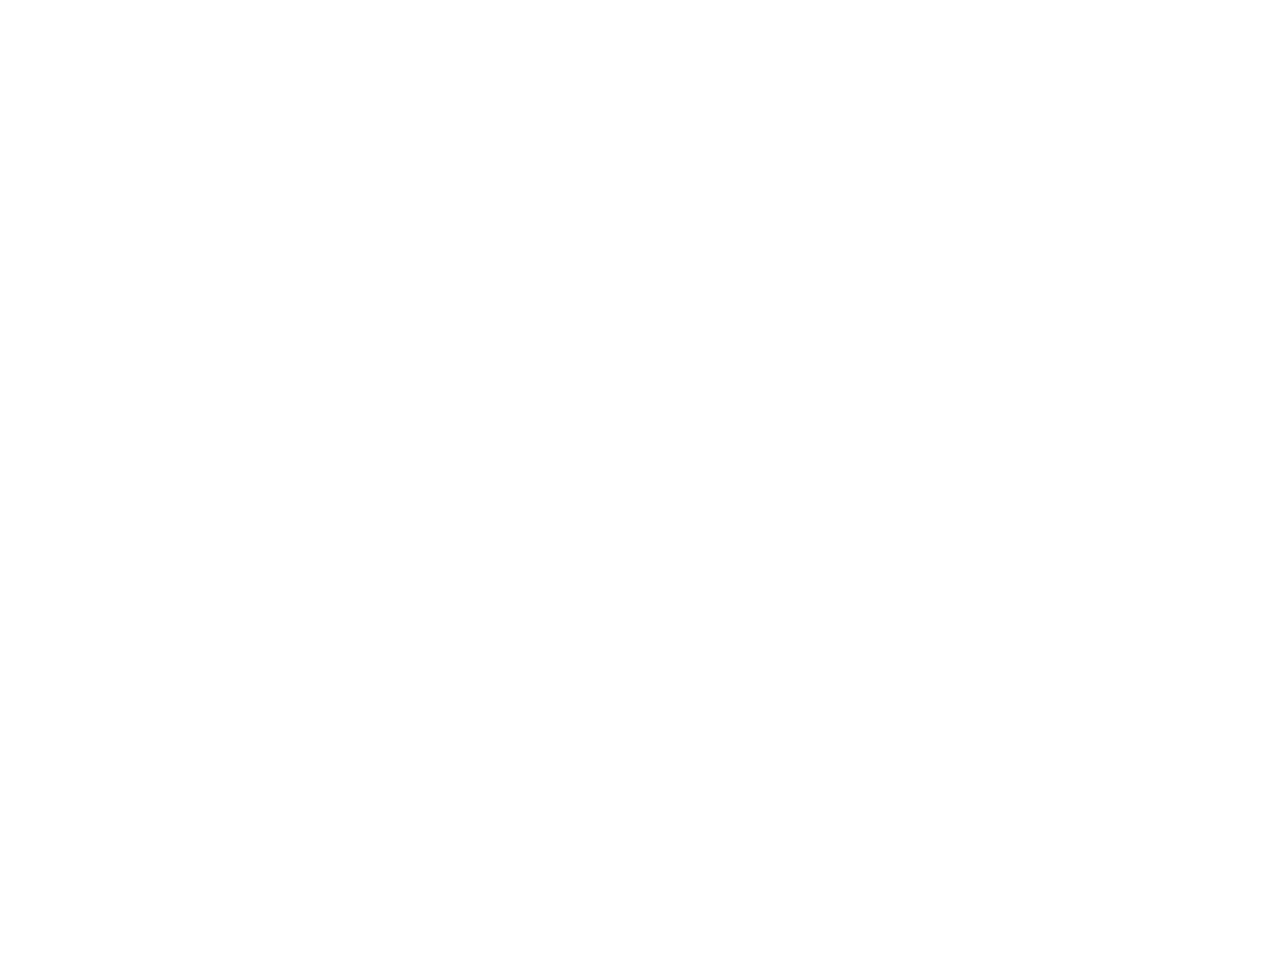

ValueError: operands could not be broadcast together with shapes (5543,) (33760,) 

In [136]:
plt.figure()
plt.plot(u, v_tot_crab - v_tot_crab*eq12)

<IPython.core.display.Javascript object>


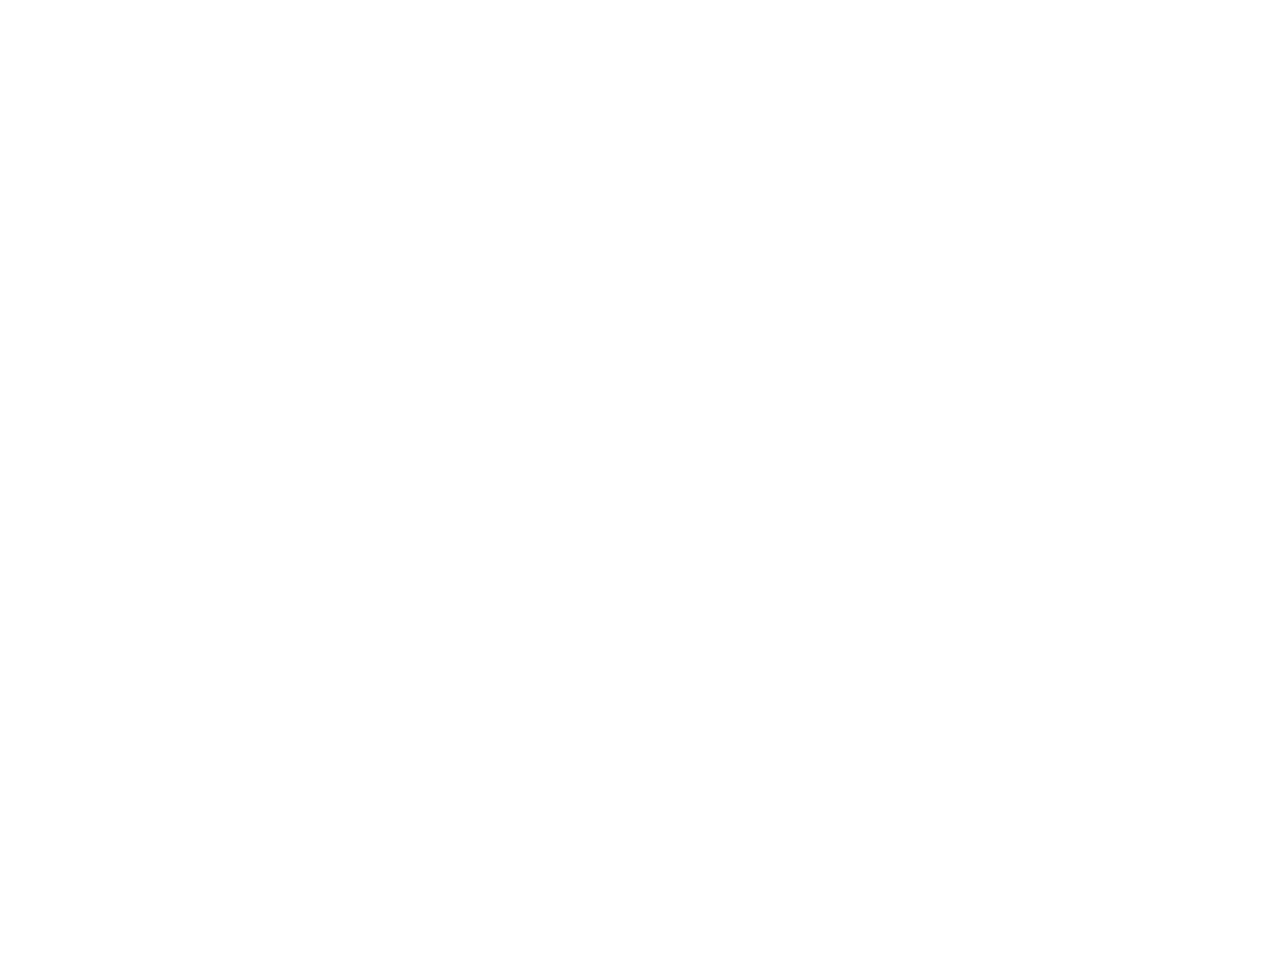

ValueError: operands could not be broadcast together with shapes (5543,) (33760,) 

In [137]:
plt.figure()
# plt.plot(u, eq12/eq12.max())
plt.plot(u, v_tot_crab*eq12, alpha=.6)

In [138]:
np.fft.fftshift(ff_sun)[17041]

0.004768816085374186

In [139]:
np.array(max_freqs).min()

NameError: name 'max_freqs' is not defined

In [140]:
indices = np.where(ff_sun>np.array(max_freqs).min()) #and np.where(np.fft.fftshift(ff_sun)<-np.array(max_freqs).min())

NameError: name 'max_freqs' is not defined

In [141]:
np.array(max_freqs).min()

NameError: name 'max_freqs' is not defined

<IPython.core.display.Javascript object>


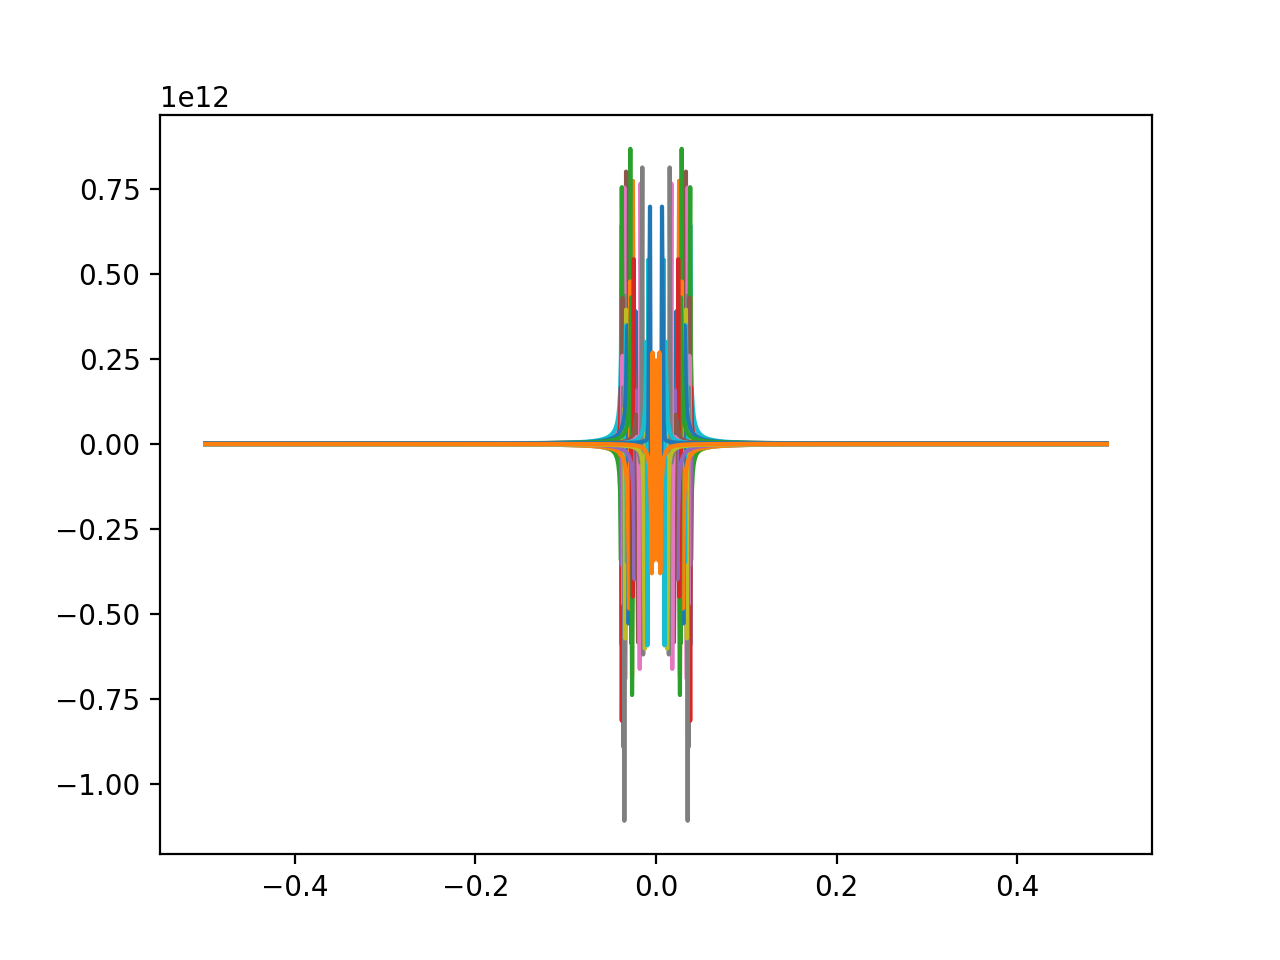

In [166]:
v_tilde_2d = np.zeros(1055)
plt.figure()
max_freqs = []
for i in range(int(len(eq12)/1055)):
    v_temp = np.fft.fft(eq12[i*1055:(i+1)*1055])#get_fft(eq12[i*1055:(i+1)*1055], eq12[i*1055:(i+1)*1055])
    fringe_temp = np.fft.fftfreq(len(lsts_sun[i*1055:(i+1)*1055]), np.median(np.diff(lsts_sun[i*1055:(i+1)*1055]))*12/np.pi*3600)
    max_freqs.append(np.abs(fringe_temp[np.abs(v_temp).argmax()]))
#     max_freqs.append(-fringe_temp[v_temp.argmax()])
    plt.plot(np.fft.fftshift(fringe_temp), np.fft.fftshift(v_temp), label='bin:{}'.format(i))
    v_tilde_2d = np.vstack((v_tilde_2d, v_temp))
# plt.xlim(-.05, .05)

In [167]:
_, ff_sun = get_fft(v_new_sun, lsts_sun)

In [168]:
ff=np.fft.fftshift(ff_sun)*1e3
sauron = np.fft.fftshift((np.abs(v_tilde_2d)), axes=1)
til = np.fft.fftshift(v_tilde_2d)

<IPython.core.display.Javascript object>


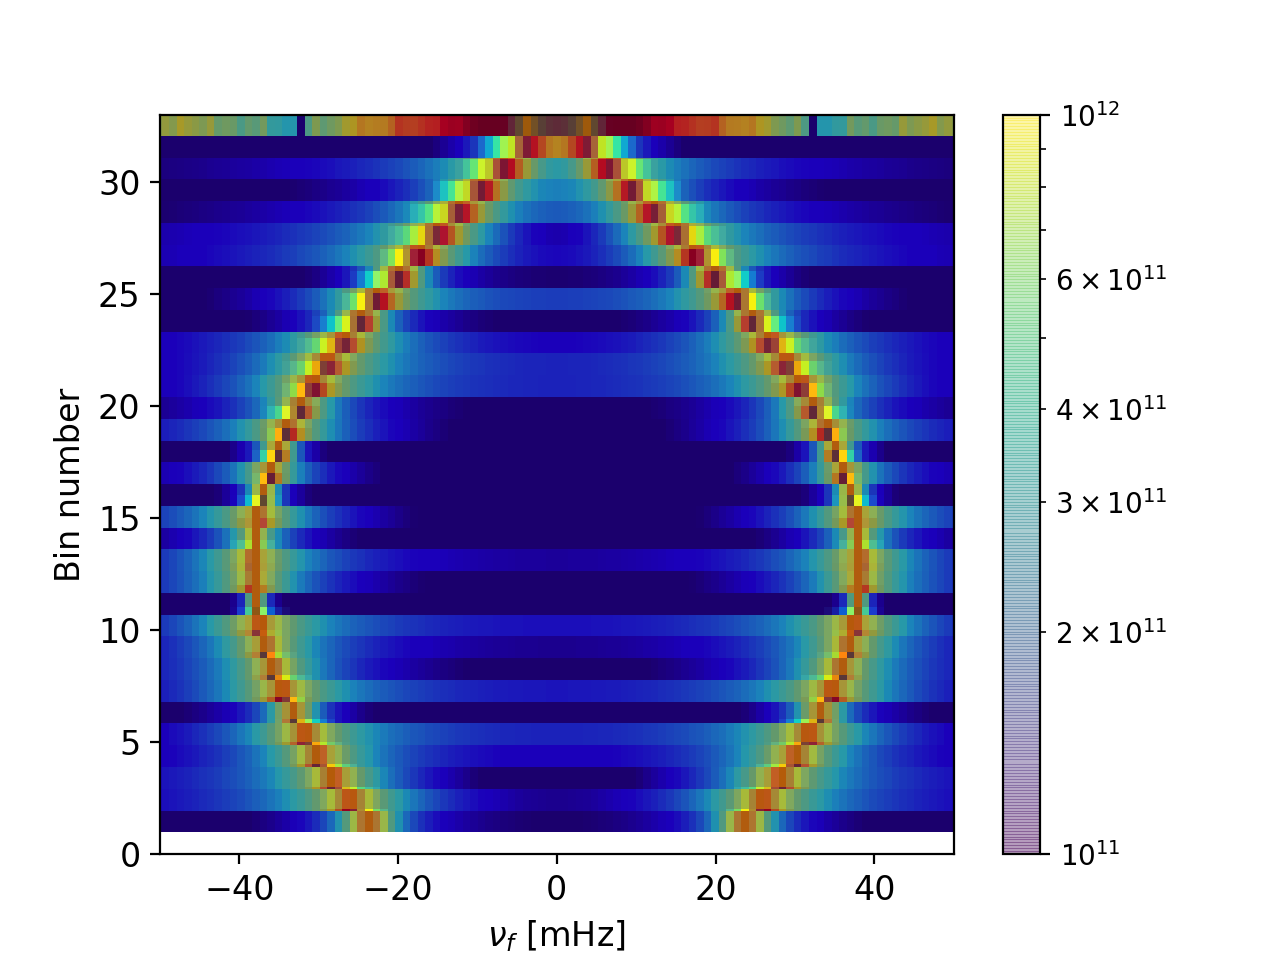

In [200]:
plt.figure()
plt.imshow(np.abs(np.fft.fftshift(v_tilde_2d_o, axes=1)), aspect='auto', cmap='jet',
           extent=[ff[0], ff[-1], 0, 33], origin='bottom', alpha=1, norm=LogNorm(1e10, 1e12))
plt.imshow(np.abs(sauron), aspect='auto', extent=[ff[0], ff[-1], 0, 33], origin='bottom', alpha=.4, norm=LogNorm(1e11, 1e12))

plt.colorbar()

plt.xlim(-50, 50)
plt.xlabel(r'$\nu_f$ [mHz]', fontsize=12)
plt.ylabel('Bin number', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.savefig('eye.pdf')

In [403]:
eq12

array([-14878.29216216, -13494.65838726, -11850.26001617, ...,
         4267.70956365,   4541.42095377,   4813.63549744])

<IPython.core.display.Javascript object>


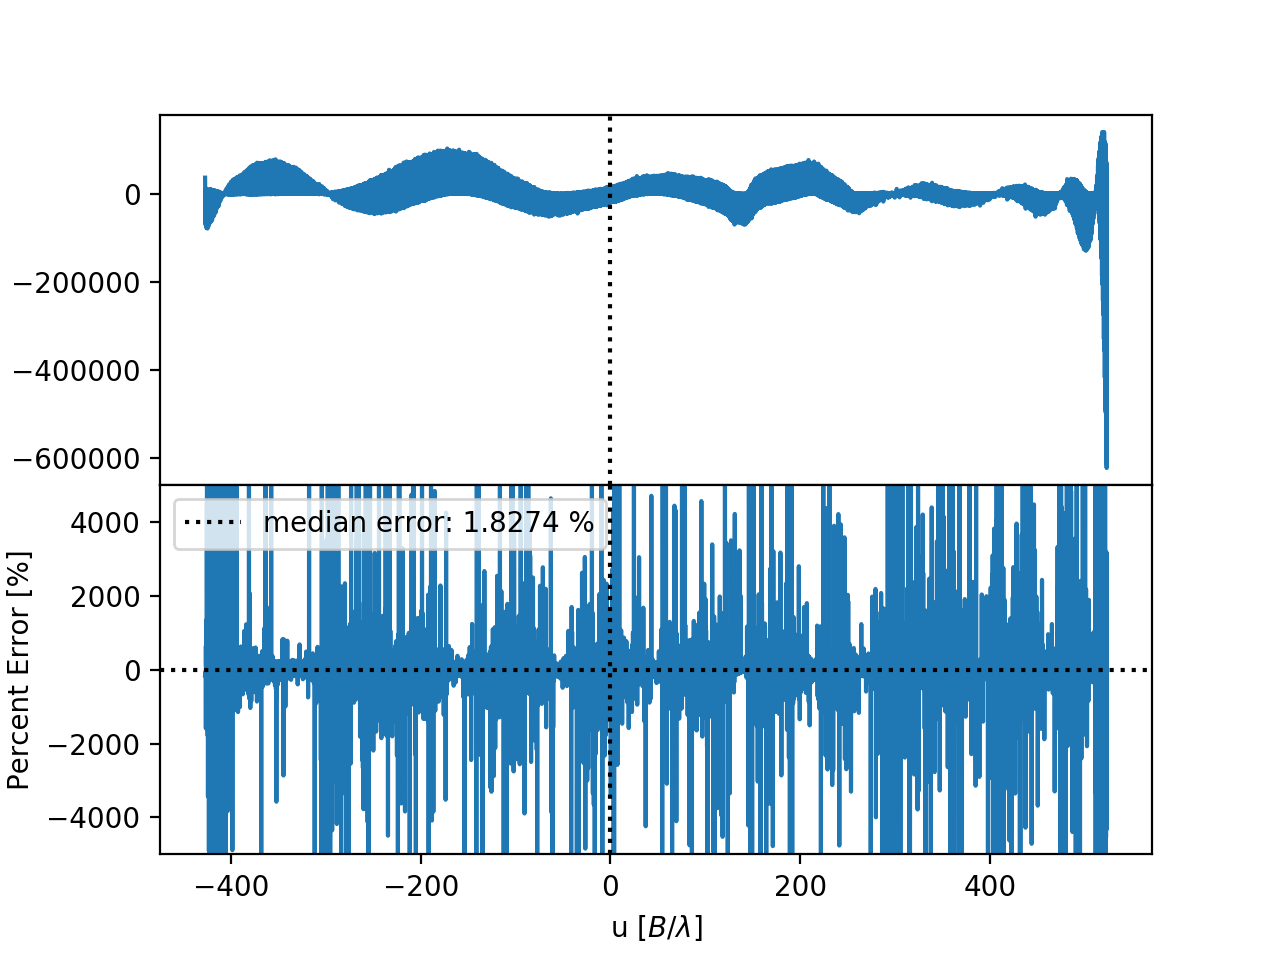

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [404]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'hspace':0})
# plt.plot(lsts_sun, v_new_sun)
ax1.plot(u, v_new_sun*eq12/eq12.max())
# ax1.plot(us, peaks)
# ax1.plot(us_m, mins)


# ax1.plot(u, eq12/eq12.max()*sun_envelope/1e6)
ax1.axvline(c='k', ls=':')
ax2.plot(u, np.abs(v_new_sun - eq12/eq12.min()*sun_envelope)/np.real(v_new_sun)*100)
med = np.abs(np.median(np.abs(np.real(v_new_sun) - eq12/eq12.max()*sun_envelope)/np.real(v_new_sun)))*100
ax2.axhline(med, c='k', ls=':', label='median error: {} %'.format(round(med, 4)))
ax2.set_ylim(-5000, 5000)
ax2.axvline(c='k', ls=':')
ax2.set_xlabel(r'u [$B/\lambda$]')
ax1.set_ylabel('Visibility [MJy]')
ax2.set_ylabel('Percent Error [%]')
ax2.legend()


# plt.plot(lsts_sun, eq12*sun_envelope-v_new_sun)


In [127]:
peaks = savgol_filter(peaks, 51, 1)
mins = savgol_filter(mins, 51, 1)

/usr/local/lib/python3.6/dist-packages/scipy/signal/_savitzky_golay.py:335: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(np.float64)


In [128]:
path_points = [-404, -295, 315, 420, 484, 517]

In [129]:
np.where(np.array(us_m)<517)

(array([   0,    1,    2, ..., 2596, 2597, 2598]),)

In [130]:
pinch = 68, 4571, 

In [131]:
patch = np.concatenate((peaks[:64], mins[64:350], peaks[350:1674], mins[1674:2066], peaks[2066:2367], mins[2367:2516], peaks[2516:]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


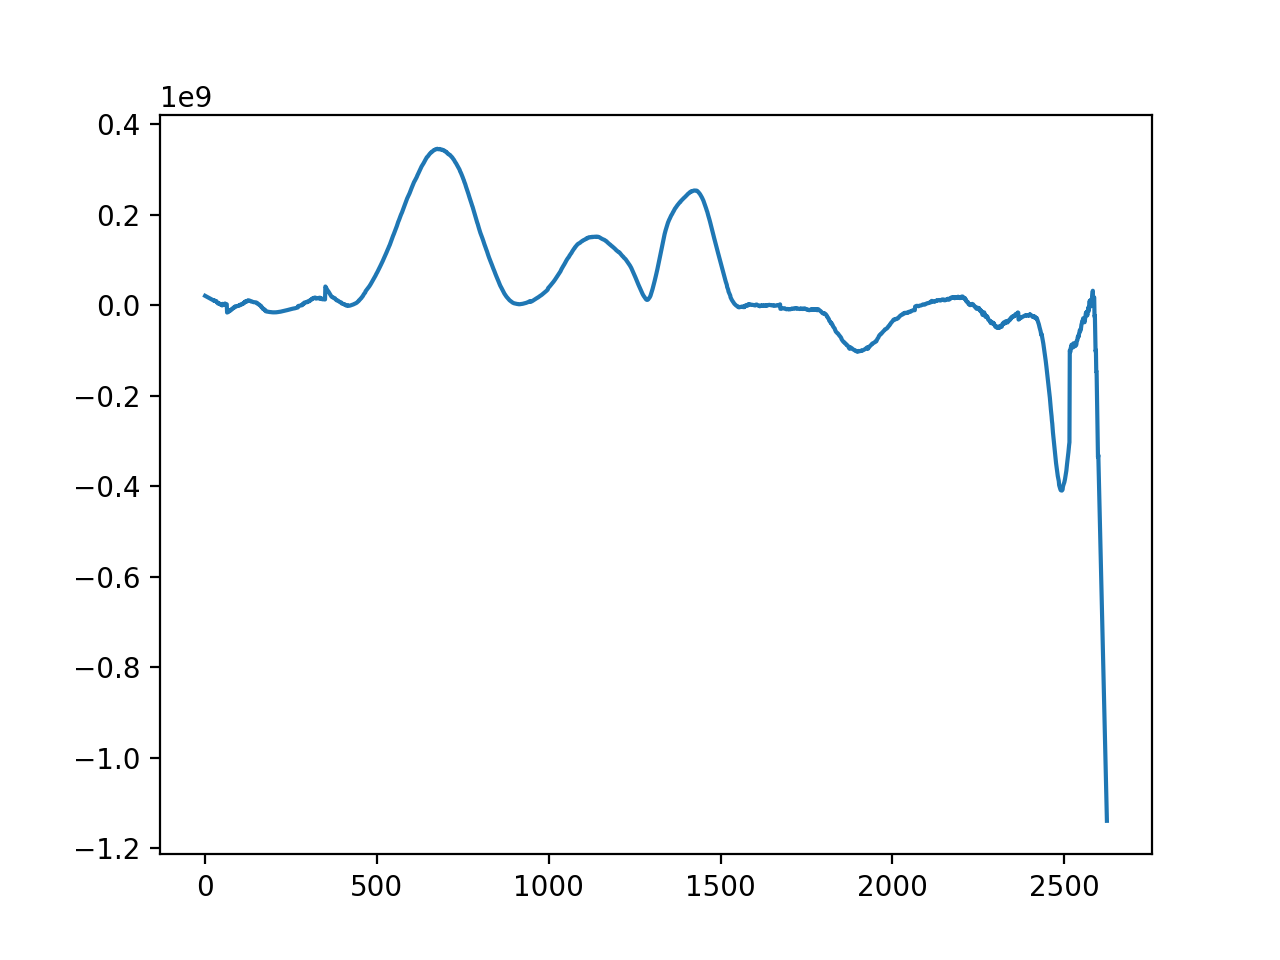

In [132]:
plt.figure()
plt.plot(patch)

In [133]:
def find_peaks(data, u):
    peaks = []
    us = []
    for i in range(len(data)-1):
        if data[i]>data[i+1] and data[i]>data[i-1]:
            peaks.append(data[i])
            us.append(u[i])
    return peaks, us
def find_mins(data, u):
    peaks = []
    us = []
    for i in range(len(data)-1):
        if data[i]<data[i+1] and data[i]<data[i-1]:
            peaks.append(data[i])
            us.append(u[i])
    return peaks, us

In [134]:
peaks, us = find_peaks(v_new_sun*np.conj(eq12), u)
mins, us_m = find_mins(v_new_sun*np.conj(eq12), u)


# peaks = savgol_filter(peaks, 11, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


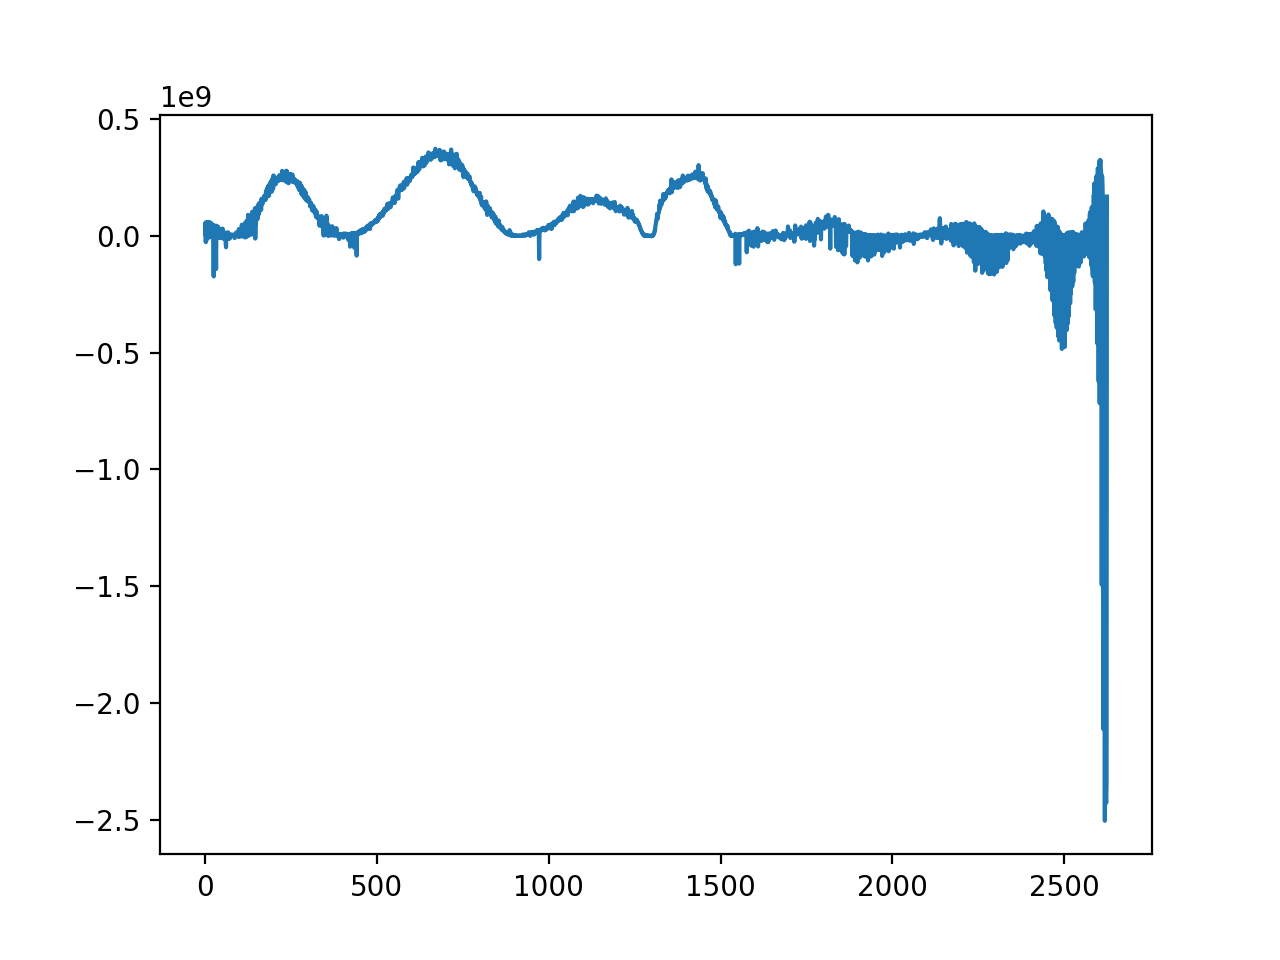

In [135]:
plt.figure()
plt.plot(peaks)

In [136]:
swap = [2568.35, 2405.35, 1873, 1567]

In [137]:
bessel_recon = np.abs(peaks)
bessel_recon[1567:1873] = -bessel_recon[1567:1873]
bessel_recon[2405:2568] = -bessel_recon[2405:2568]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


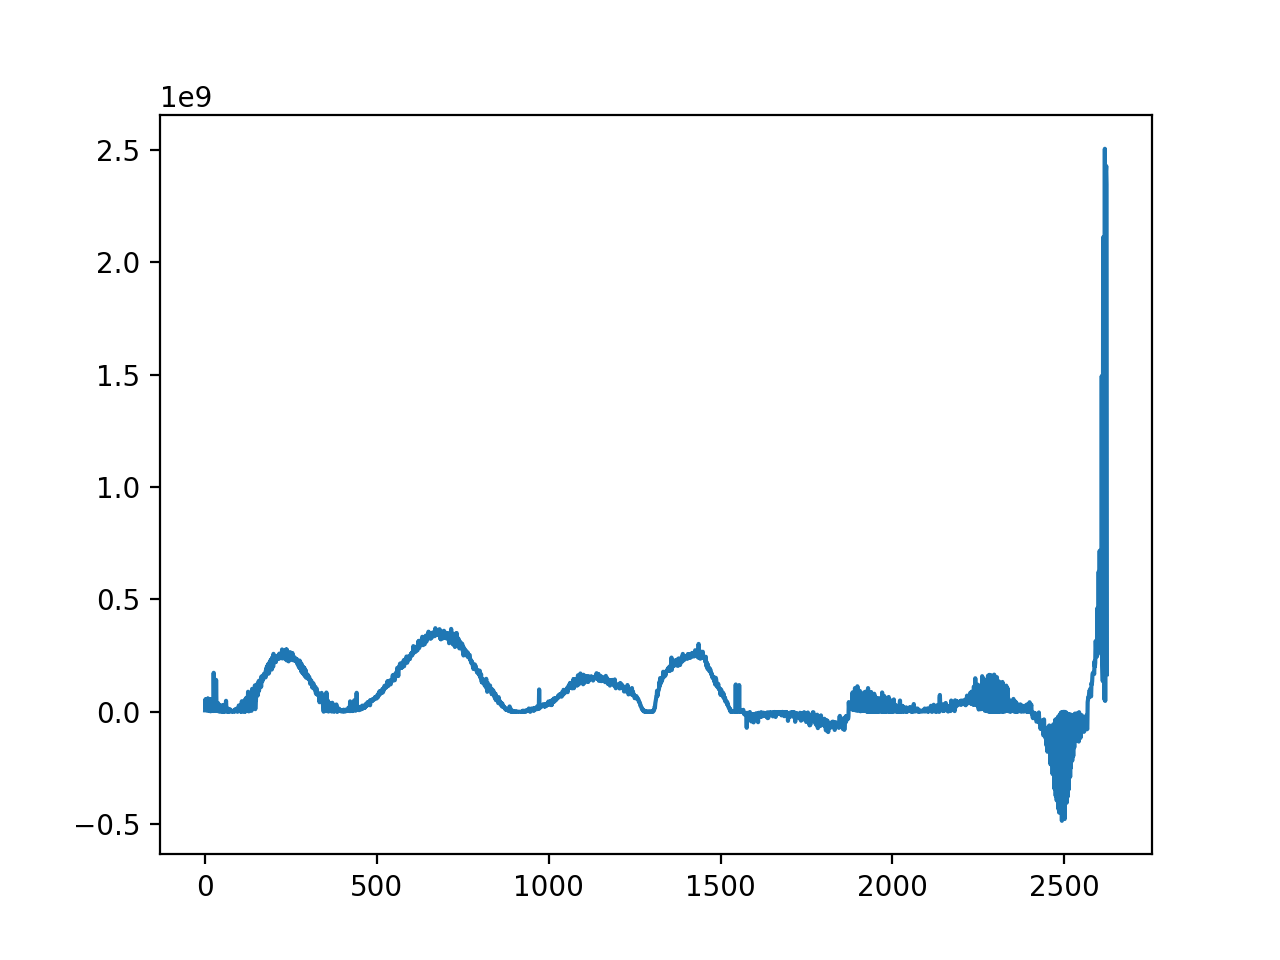

In [138]:
plt.figure()
plt.plot(bessel_recon)

# Local Fringe Frequency

In [139]:
ff_sun = f_f(B_EW, B_NS, dec, HA, nch.lat*np.pi/180, 2.8e-2)*np.pi/12*1/3600

In [140]:
1/ff_sun, 18/np.cos(dec)

(array([ 45.12743627,  45.12282604,  45.11821699, ..., 384.80054624,
        385.21153349, 385.62340163]), 18.010456363868503)

In [141]:
v_filt_sun, fringe_freq_sun = get_fft(v_tot_sun, lsts_sun)

In [142]:
indices = []
for i in range(len(fringe_freq_sun)):
    if fringe_freq_sun[i] <ff_sun[-1] and fringe_freq_sun[i] >-ff_sun[-1]:
        indices.append(i)
    if fringe_freq_sun[i] > ff_sun[0] or fringe_freq_sun[i] <-ff_sun[0]:
        indices.append(i)
v_filt_sun[indices] =0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


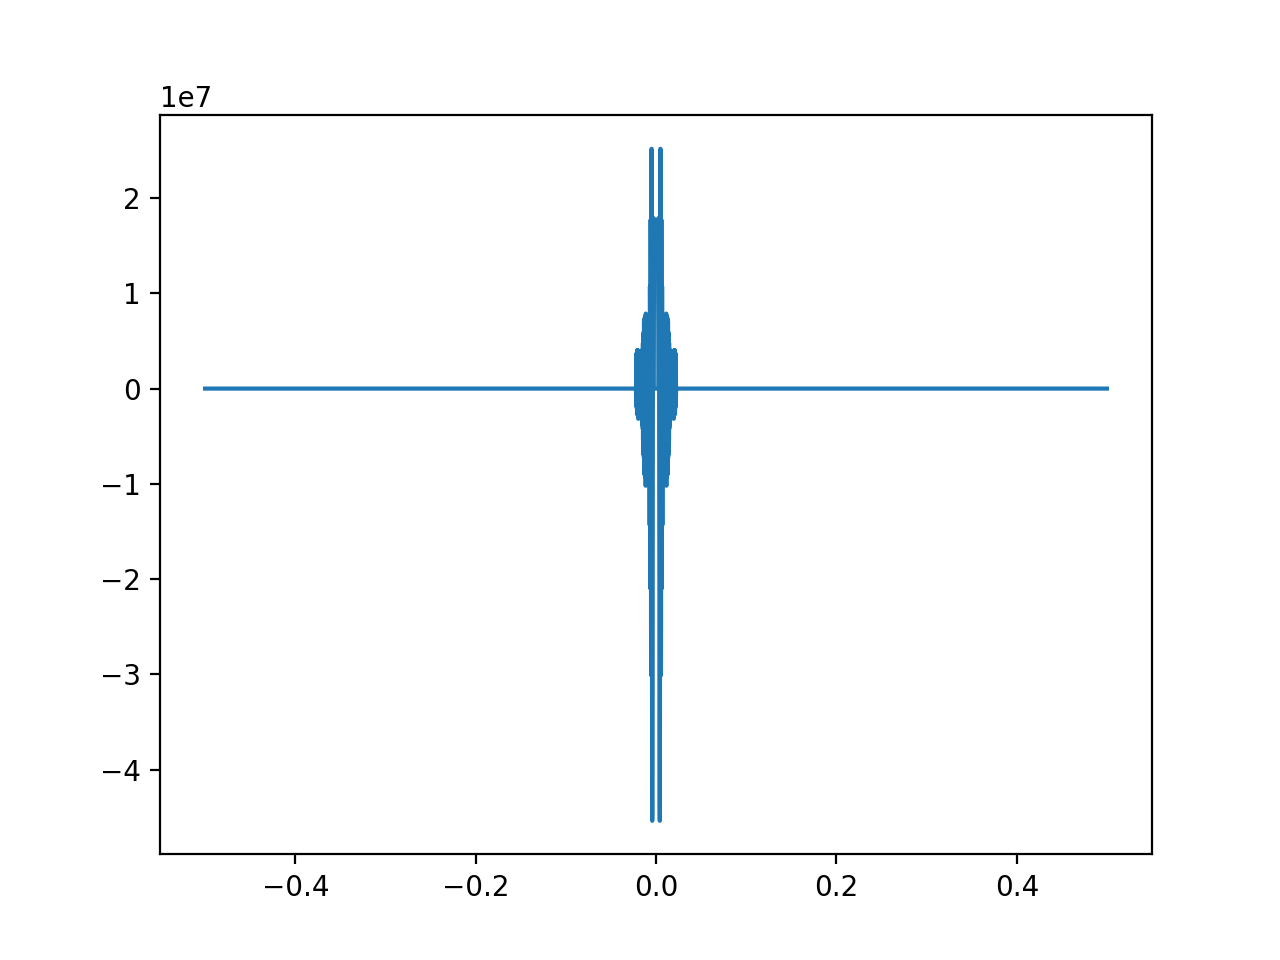

In [143]:
plt.figure()
plt.plot(np.fft.fftshift(fringe_freq_sun), np.fft.fftshift(v_filt_sun))

In [144]:
ff_sun[0]

0.022159468444364352

In [145]:
v_new = np.fft.ifft(v_filt_sun)

In [146]:
ff_sun

array([0.02215947, 0.02216173, 0.022164  , ..., 0.00259875, 0.00259598,
       0.0025932 ])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


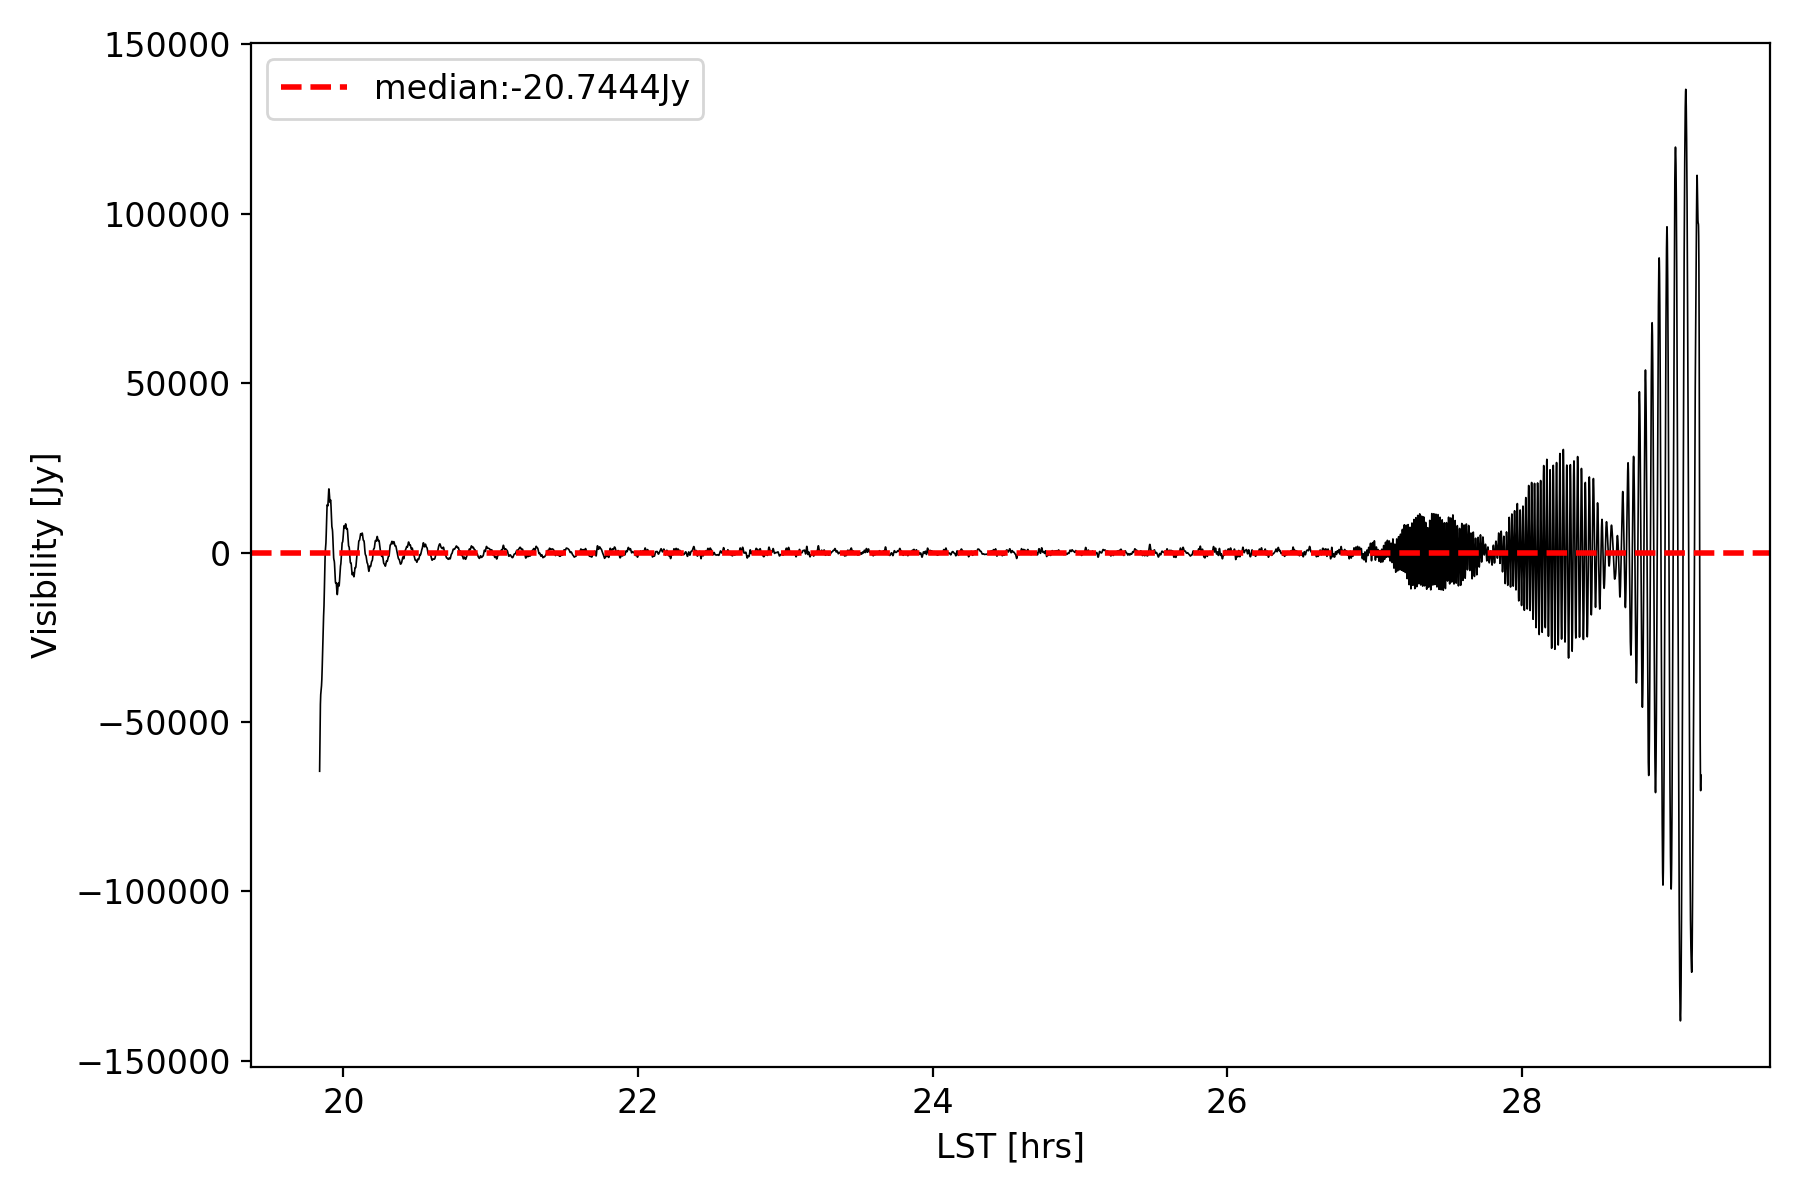

In [147]:
plot_raw(np.real(v_new), lsts_sun)

# Measuring the Diameter of the sun

MF theory = 0 when 2pi ff *R n /N =pi/2

In [148]:
def ff(R, N):
    n = np.arange(-N, N)
    return N/(4*R*n)

In [149]:
def get_DH(R, N):
    dh = R/N
    n = np.arange(-N, N)
    Dh = n*dh
    return dh, Dh, n

def MF_theory(R, ff):
    N = len(ff)*2+1
    dh, Dh, n = get_DH(R, N)
    sum_arg = np.sqrt(1-(n/N)**2)*np.cos(2*np.pi*R/N*np.einsum('i,j->ij', ff,n))
    return dh*np.sum(sum_arg, axis=1)


In [150]:
def get_nulls(y):
    null_arr = []
    pos_args = np.where(y>0)
    neg_args = np.where(y<0)
    for i in pos_args[0]:
        try:
            if y[i-1] <0 or y[i+1]<0:
                null_arr.append(i)
        except:
            pass
    return null_arr

In [1154]:
u_e

array([0.193, 0.34 , 0.54 , 0.72 ])

In [ ]:
501, 519.063,

In [100]:
# nulls = [348.526, 445.236, 204.179, 312.775, 421.371]
# nulls = [331.148, 431.553, 116, 222.6, 331.152, 430.848]

In [1553]:

u_nulls = [511.736, 473.567, 407.342, 298.4]
u_err = [ 5, 4.32, 1.93, 3.4]
# u_nulls = [285, 383, 467]#[458, 383, 269]
# u_nulls = [519.063, 485.809, 422.14, 317.512]
nulls = [96.95, 208.422, 318.838,422.266 ]

In [1626]:
u_n = np.array(nulls[:])[:-1]
u_e = np.array(u_err[:])[:-1]*10

In [1627]:
u_n

array([ 96.95 , 208.422, 318.838])

In [1633]:
m,b = np.polyfit(u_n, model_u, 1, full=False)

In [1634]:
m/np.pi*180/np.pi/2

0.2606263347867651

In [1635]:
b

1.0601005082831296

In [1636]:
model_u = np.array([3.83171, 7.01559, 10.17347, 13.323369])[:-1]

In [1637]:
model_u

array([ 3.83171,  7.01559, 10.17347])

In [1644]:
def chi2(model,pred, sigma):
    return np.sum(np.abs(model-pred)**2/2/sigma**2)
def pred(theta_r, x):
    return x/2/np.pi/theta_r
    

In [1645]:
chi = []
theta_r = np.linspace(1e-3, .07, 10000)
predicted = []
for r in theta_r:
    model = pred(r, model_u)
#     predicted.append(model)
    chi.append(chi2( model,u_n, u_e))

In [1646]:
error_bars = np.ones((2, len(model_u)))
error_bars[0, : ] = 0.010107172437551715
error_bars[1, :] = 0.011062827562448307

# error_bars_1 = np.ones((2, len(model_u)))
# error_bars_1[0, : ] = .071
# error_bars_1[1, :] = .2

In [1647]:
u_n

array([ 96.95 , 208.422, 318.838])

In [1648]:
angular_r = theta_r[np.argmin(chi)]*180/np.pi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


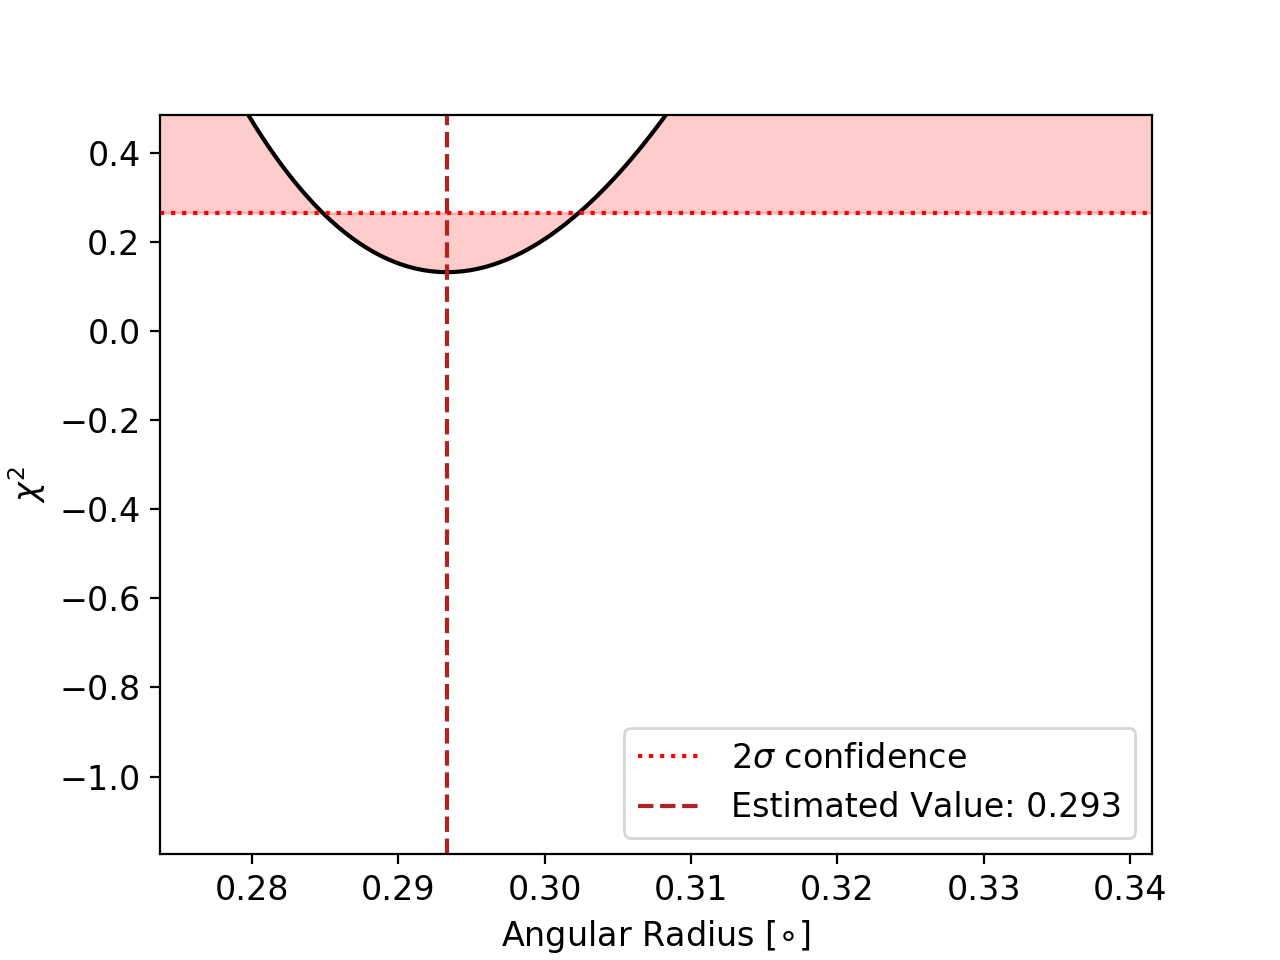

In [1649]:
fig, ax1 =plt.subplots(nrows=1, sharex=False, gridspec_kw={'hspace':.35})
ax1.plot(theta_r*180/np.pi, chi, 'k')
# plt.axvline(theta_r[np.argmin(chi)]*180/np.pi, ls = ':', c='k', label=round(theta_r[np.argmin(chi)]*180/np.pi, 2))
ax1.axhline(np.array(chi).min()*2, ls=':', c='r', label=r'2$\sigma$ confidence')
# plt.axhline(np.array(chi).min()*1.5, ls=':', c='b', label=r'1$\sigma$ confidence')

# ax1.axvline(31/120+27/7200, ls='-.',c='firebrick', label='True Value')
ax1.axvline(theta_r[np.argmin(chi)]*180/np.pi, ls='--',c='firebrick',  label='Estimated Value: {}'.format(round(angular_r, 3)))


ax1.fill_between(theta_r[267:2246]*180/np.pi, chi[267:2246],  np.array(chi).min()*2, alpha=.2, color='r')
# plt.fill_between(theta_r[117:809]*180/np.pi, chi[117:809],  np.array(chi).min()*1.5, alpha=.2, color='blue')


# ax1.set_ylim(20, 120)
# ax1.set_xlim(0.245, .275)
ax1.set_xlabel('Angular Radius [$\circ$]', fontsize=12)
ax1.set_ylabel(r'$\chi^2$', fontsize=12)
ax1.legend(fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=12)

# ax2.scatter(np.arange(len(model_u)), model_u/2/np.pi/u_n*180/np.pi, zorder=2.5, c='k')
# ax2.errorbar(np.arange(len(model_u)), model_u/2/np.pi/u_n*180/np.pi, yerr=error_bars, ls='', c='r', capsize=2, label=r'$2\sigma$')
# # plt.errorbar(np.arange(len(model_u)), model_u/2/np.pi/u_nulls*180/np.pi, yerr=error_bars_1, ls='', c='b', capsize=2, label=r'$1\sigma$')
# ax2.axhline(theta_r[np.argmin(chi)]*180/np.pi, ls='--',c='firebrick', label='Estimated Value: {}'.format(round(angular_r, 3)))
# ax2.set_xlabel('Null Count [unitless]', fontsize=12)
# ax2.set_ylabel('Angular Radius [$\circ$]', fontsize=12)
# ax2.tick_params(axis='both', which='major', labelsize=12)
# ax2.tick_params(axis='both', which='minor', labelsize=12)
# ax2.legend(fontsize=12)
plt.savefig('chi2.pdf')

In [1582]:
np.where(theta_r*180/np.pi >  .162496)

(array([ 267,  268,  269, ..., 9997, 9998, 9999]),)

In [1583]:
np.where(theta_r*180/np.pi >.94522)

(array([2246, 2247, 2248, ..., 9997, 9998, 9999]),)

In [421]:
-np.polyfit(np.arange(4), model_u/2/np.pi/u_n*180/np.pi, 1)

array([ 0.19257304, -0.59667758])

In [201]:
angular_r = .259

In [202]:
from scipy.special import j1

In [203]:
angular_r_low = angular_r - 0.010107172437551715
angular_r_high = angular_r + 0.011062827562448307

In [204]:
angular_r_low

0.2488928275624483

In [288]:
phase=7*np.pi/16
phase_up = 7*np.pi/16
phase_low= 7*np.pi/16#4*np.pi/9
env = j1(u*angular_r*np.pi/180*2*np.pi+phase)/(u*angular_r*np.pi/180*2*np.pi+phase)
env_lower = j1(u*angular_r_low*np.pi/180*2*np.pi+phase_low)/(u*angular_r_low*np.pi/180*2*np.pi+phase_low)
env_upper = j1(u*angular_r_high*np.pi/180*2*np.pi+phase_up)/(u*angular_r_high*np.pi/180*2*np.pi+phase_up)





In [289]:
u = np.cos(dec)*np.cos(HA)*B_EW/lamb - np.cos(dec)*np.sin(HA)*B_NS/lamb

<IPython.core.display.Javascript object>


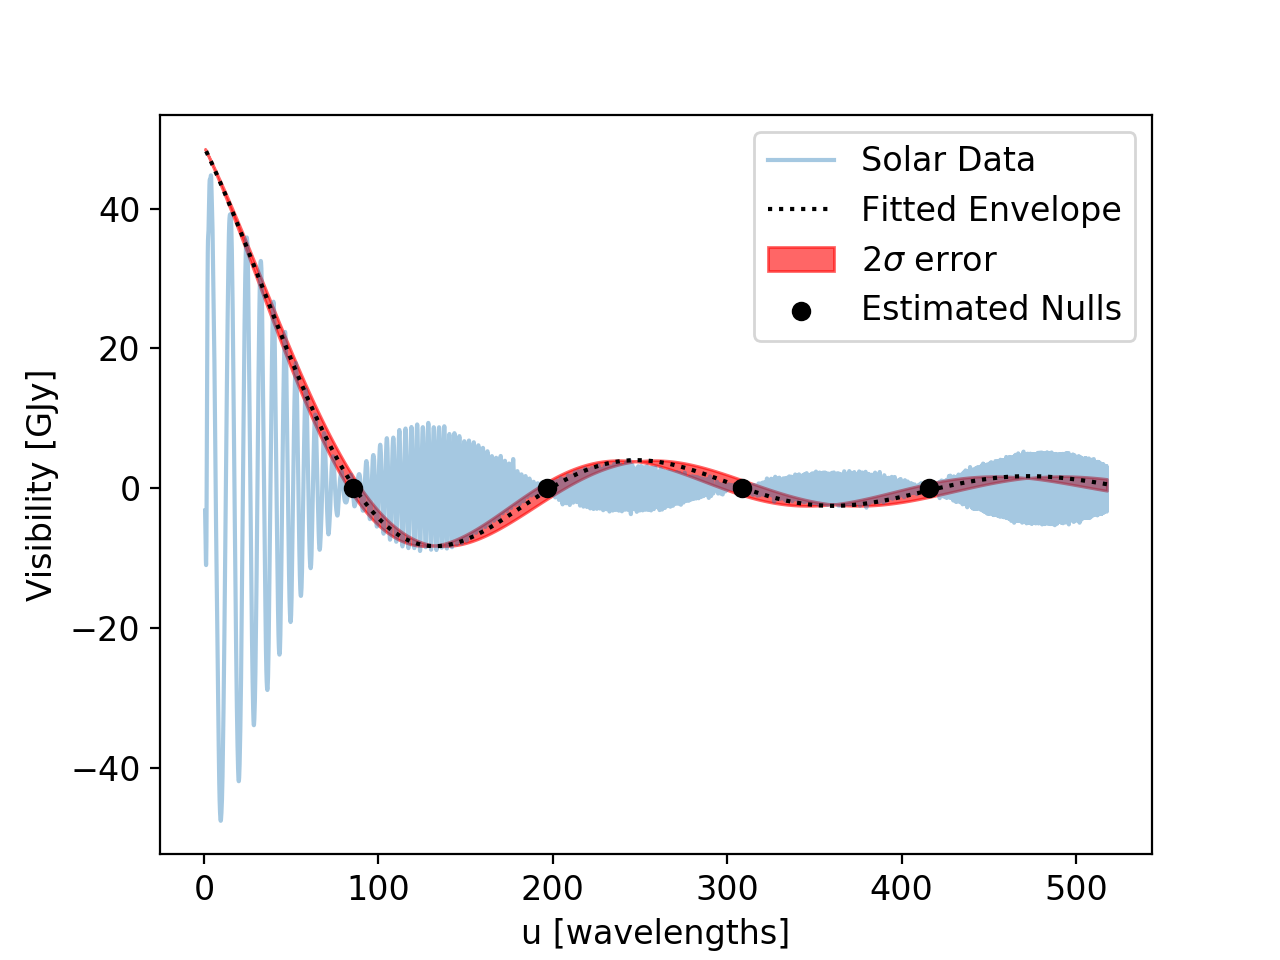

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [301]:
plt.figure()
plt.plot(u[14981:], v_new_sun[14981:]/1e9, alpha=.4, label='Solar Data')

plt.plot(u[14981:], 125000000000000000*env[14981:]/1e15, ls=':', c='k', label='Fitted Envelope')
plt.fill_between(u[14981:], 125000000000000000*env_upper[14981:]/1e15, 125000000000000000*env_lower[14981:]/1e15, color='r',alpha=.6, label=r'2$\sigma$ error')
# plt.plot(w, 450000*env_lower)
plt.scatter(n, meh, c='k', zorder=2.5, label='Estimated Nulls')
plt.xlabel('u [wavelengths]', fontsize=12)
plt.ylabel('Visibility [GJy]', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize=12)
plt.savefig('env.pdf')

In [294]:
n = [85.2744, 196.404,308.582, 415.518]
meh = np.zeros_like(n)

In [ ]:
sun_envelope

In [533]:
len(HA)

5000

In [542]:
chi=[]
for r in theta_r:
    env = np.abs(j1(u*r*2*np.pi)/(u*r*2*np.pi))
    chi.append(chi2(env, sun_envelope, 100))



<IPython.core.display.Javascript object>


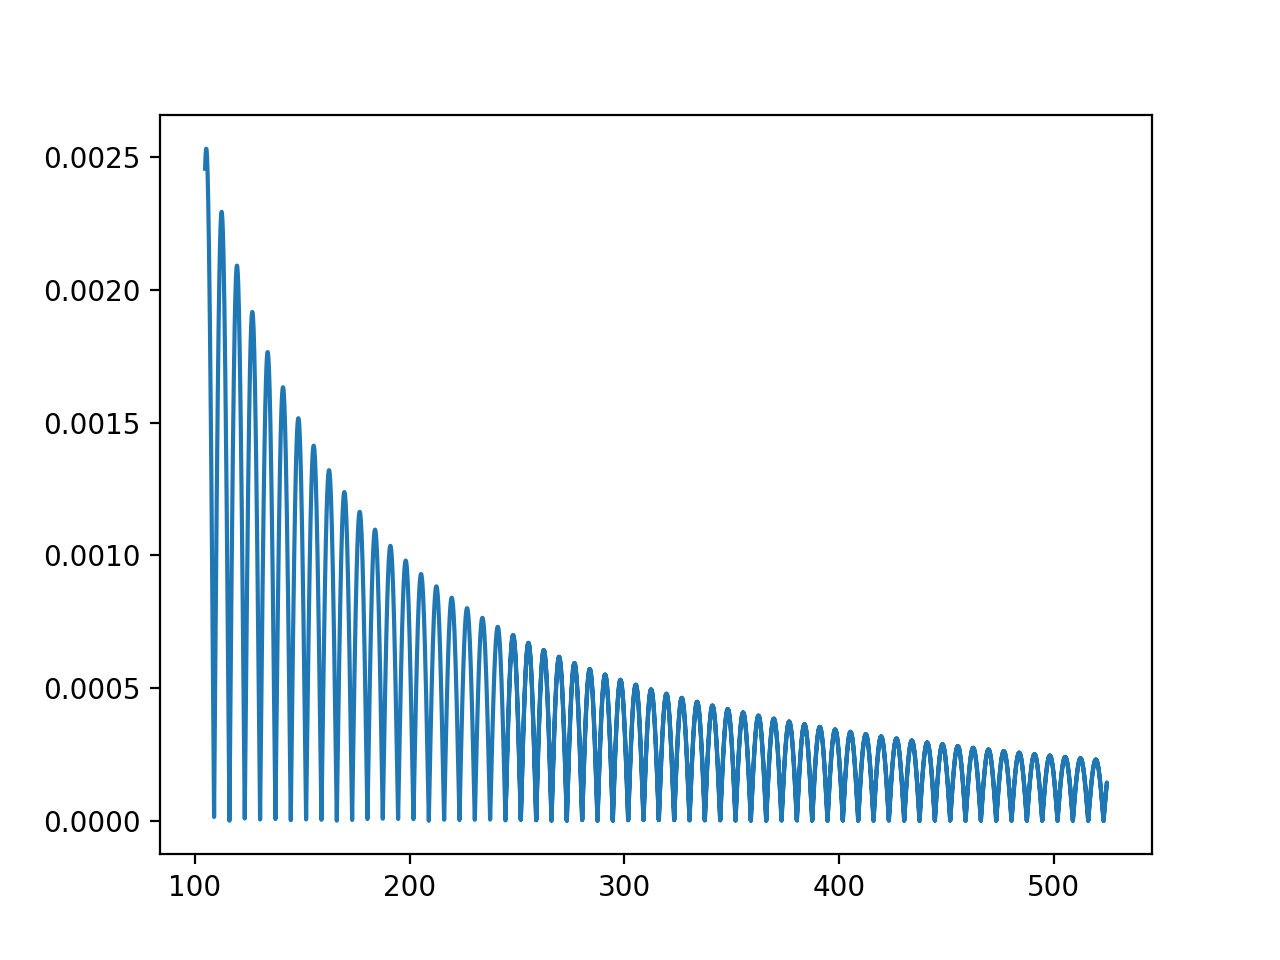

In [545]:
plt.figure()
plt.plot(u, env)

In [1997]:
 B_EW, B_NS= (14.68937875751503, 1.5931863727454907)

In [1998]:
np.sqrt(B_EW**2+B_NS**2)

14.775523378210186

In [512]:
from astropy.constants import R_sun
from astropy.units import AU

In [515]:
d = 1*AU
d.to('m')

<Quantity 1.49597871e+11 m>

In [525]:
np.sin(.259*np.pi/180)*d.to('m')-np.sin((.259+.011)*np.pi/180)*d.to('m')#np.sin((.259-.01)*np.pi/180)*d.to('m')

<Quantity -28720423.29567707 m>

In [522]:
np.sin((.259-.01)*np.pi/180)*d.to('m'), np.sin((.259+.011)*np.pi/180)*d.to('m')

(<Quantity 6.50130828e+08 m>, <Quantity 7.04960748e+08 m>)

In [517]:
R_sun

<<class 'astropy.constants.iau2015.IAU2015'> name='Nominal solar radius' value=695700000.0 uncertainty=0.0 unit='m' reference='IAU 2015 Resolution B 3'>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


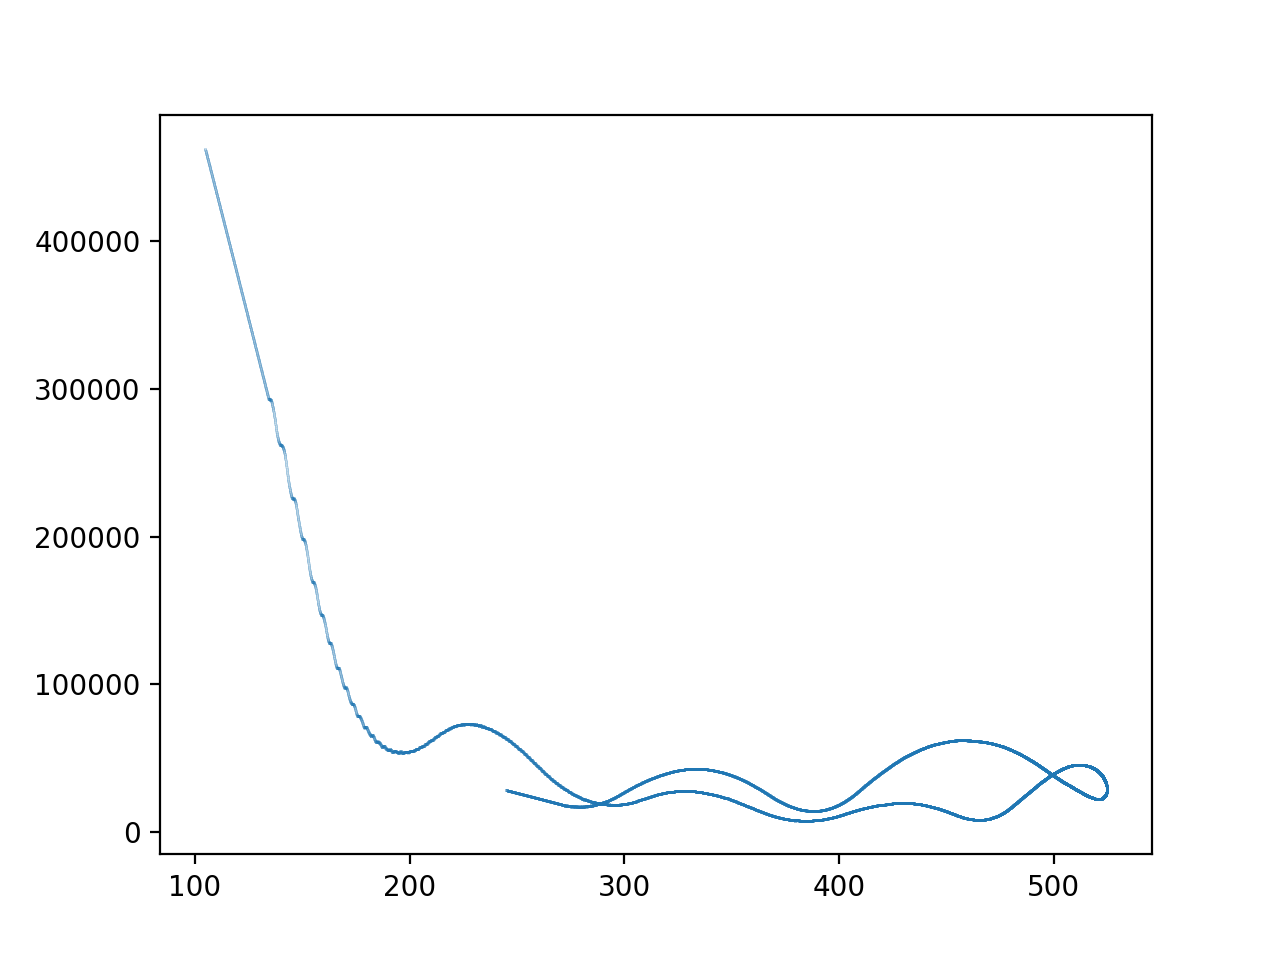

In [549]:
plt.figure()
plt.scatter(u, sun_envelope, s=.001)

In [553]:
def bess(x):
    return j1(x)/x

In [554]:
import scipy.optimize as opt

In [ ]:
opt.leastsq(bess, u*2*np.pi*.005)